<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/orderml

/content/drive/.shortcut-targets-by-id/1FKl2J9VPA88stIpA_grTLED-Fv9_B7CF/orderml


Any other drive folder is, hint, probably not the correct one! Navigate to where your orderml folder is in your drive. This code should work for a top-level folder.

Check you're in the right folder.



In [ ]:
ls

chisurface.png  orderparams.ipynb          problems.txt  test.png
logs/           OrderPresentation.gslides  __pycache__/


Install non-default packages here.

In [ ]:
!pip install bumps
!pip install gym
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

     |████████████████████████████████| 522kB 5.2MB/s 
  Created wheel for bumps: filename=bumps-0.7.16-cp36-none-any.whl size=546174 sha256=94d13184c2a2f3490ee1bdb3a7a6e23ef3690961bf9c2bda07aecf57ee5a1151
  Stored in directory: /root/.cache/pip/wheels/41/f7/17/a898c85754ad1c6d7de087e28809af7989b81f14f200547de3
Successfully built bumps
TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 4.9MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


"Compile" code.

In [ ]:
class OrderMethods():

    def getData(T, p):
        Jt, Nf, Bk = p
        return OrderMethods.orderparameter(T, 160, Jt, Nf, Bk)

    def bsol(temp,p):
        Tn,Jt,Nf,Bk=p
        t=4.0*(Jt/(Jt+1.0))*Tn/temp
        #print t
        if (Tn<=0) or (Jt<=0) or temp>=Tn:
            xout=0.0
        else:
            xout=optimize.brentq(OrderMethods.bfun,0.0,t,args=(temp,p),xtol=1e-6)

        return xout


    def bfun(x,T,p):
        Tn,Jt,Nf,Bk=p
        if x==0.0:
            B=-1.0 # so that it wont find solution at zero
        else:
            B=(x-3*OrderMethods.brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
        return B

    def brill(j,x):
        temp=(2*j+1.0)/2/j
        if x==0:
            Br=0.0
        else:
            Br=temp/np.tanh(temp*x)-1.0/np.tanh(x/2/j)/2/j
        return Br

    def Intensity(T,p):
        Tn,Jt,Nf,Bk=p
        br=OrderMethods.brill(Jt,OrderMethods.bsol(T,p))
        bout=Bk+Nf*br**2 + 100
        return bout

    def orderparameter(T, Tn, Jt, Nf, Bk):
        p=[Tn, Jt, Nf, Bk]
        I=[]
        for t in T:
            I.append(OrderMethods.Intensity(t,p))
        return np.array(I)

    def fit(model):
        nllfs = []
        zin = []
        for tns in np.arange(50,200, 5):
            #print("zs", zs)
            model.Tn.value = tns
            model.update()
            schi=model.nllf()
            nllfs.append(schi)
            zin.append(tns)
        plt.scatter(zin, nllfs)
        plt.xlabel("tn in")
        plt.ylabel("chi") 
        plt.show()
        plt.savefig("chisurface")
        plt.close()
        problem = FitProblem(model)
        result = fitters.fit(problem, method='lm')
        for p, v in zip(problem._parameters, result.dx):
            p.dx = v
        return result.x, result.dx, problem.chisq(), problem._parameters
        

Execute main class.

In [ ]:
import sys
import numpy as np
import pylab as plt
import scipy.optimize as optimize
from bumps.names import *
import bumps.fitters as fitters
import gym.spaces as spaces
import gym

class OrderEnv(gym.Env): #add gym.env

    def __init__(self):
        self.reward_scale = 100
        self.episodeNum = 0
        self.steps = 0
        self.T = np.array([])
        self.startTn = 150
        self.p = [.885,330,.3]
        self.error = []

        # self.observation_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        # self.action_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        # self.action_space = spaces.Discrete(4)
        self.curTemp = 3
        self.x = self.startTn

        #logging arrays and vars
        self.rewards = [] #interepisodic
        self.chisqds = []
        self.transTemps = []
        self.totReward = 0 
        self.info = {}     

    def step(self, action): 
        # if (action == 0):
        #     action = 1
        # if (action == 1):
        #     action = 5
        # elif (action == 2):
        #     action = 10
        # elif (action == 3):
        #     action = 20

        print("stepping: ", self.episodeNum)
        print("ACTION            : ", action)

        self.curTemp += action
        #self.curTemp = action
        self.curTemp = self.round_to(self.curTemp, 0.5)
        print("curtemp: ", self.curTemp)

        self.steps += 1
        reward = -self.reward_scale
        self.T = np.append(self.T, self.curTemp)
        print("Temperature: ", self.T)
        
        if self.steps > 1:
            self.I = OrderMethods.getData(self.T, self.p)
            print("Intensity: ", self.I)
            self.error= np.sqrt(self.I)
            M = Curve(OrderMethods.orderparameter, self.T, self.I, self.error, Jt = self.p[0], Nf = self.p[1], Bk = self.p[2])
            M.Tn.range(10, 400)

            self.x, dx, chisq, params = OrderMethods.fit(M)
            self.x = self.x[0]
            print("THE RESULT:", self.x)

            dx = params[0].dx

            print("chisqds: ", chisq)
            print("BUT ARE WE SURE?:", dx)

            plt.plot(self.T, self.I, 'ro')
            plt.show()
            plt.close()

            # if(action > 0.5):
            #   reward += 1000

            if chisq < 2 and dx < 2:
                  reward += 100 + 1/dx

            self.chisqds.append(chisq)
            self.transTemps.append(self.x)

        print("highHIIIIGHHHHHH: ", (340-self.curTemp))
        print("rewaRD:: ", reward)

        self.totReward += reward
        np.append(self.state, self.curTemp)
        delta = abs(340 - self.curTemp)

        if (self.steps > 20 and chisq < 0.05 and dx < 10000000): #less than or equal to?
            print("terminated: excellent conditions")
            terminal = True
            self.log()

        elif (self.curTemp >= 340):
            print("terminated: oveer max temp")
            terminal = True
            self.log()
        elif (self.steps > 100):
            print("terminated: too long")
            terminal = True
            self.log()
        else:
            terminal = False

        return self.state, reward, terminal, self.info


    def reset(self):
        print("reset")
        self.steps = 0
        self.T = np.array([])
        self.I = []
        self.chisqds = []
        self.transTemps = []
        self.totReward = 0
        self.curTemp = 3
        self.state = np.array([self.curTemp])

        return self.state #starting state

    def log(self):
        self.episodeNum += 1

        filename = "logs/chis/chiLog-" + str(self.episodeNum) + ".txt"
        np.savetxt(filename, self.chisqds)

        filename = "logs/temps/tnLog-" + str(self.episodeNum) + ".txt"
        np.savetxt(filename, self.transTemps)

        self.rewards.append(self.totReward)
        filename = "logs/runrewards.txt"
        np.savetxt(filename, self.rewards)

    @property
    def action_space(self):
        return spaces.Box(low = np.array([0.5]), high = np.array([340 - self.curTemp]))
        # return spaces.Box(low = np.array([self.curTemp + 0.5]), high = np.array([340]))

    @property 
    def observation_space(self):
        return spaces.Box(low=3.0, high=340.0, shape=(self.steps + 1,), dtype=np.float32)


    def round_to(self, n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

reset
stepping:  0
ACTION            :  [29.234047]
curtemp:  32.0
Temperature:  [32.]
highHIIIIGHHHHHH:  308.0
rewaRD::  -100
stepping:  0
ACTION            :  [156.08406]
curtemp:  188.0
Temperature:  [ 32. 188.]
Intensity:  [430.03811335 100.3       ]


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/stable_baselines/common/env_checker.py:210: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn("We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


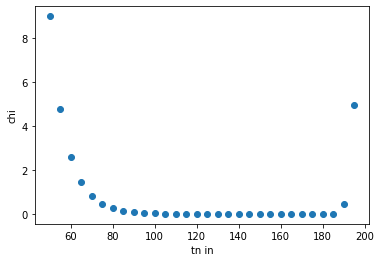

THE RESULT: 160.00000000000037
chisqds:  0.0
BUT ARE WE SURE?: 1588.1350826524558


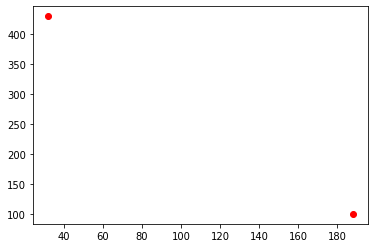

highHIIIIGHHHHHH:  152.0
rewaRD::  -100
stepping:  0
ACTION            :  [22.787853]
curtemp:  211.0
Temperature:  [ 32. 188. 211.]
Intensity:  [430.03811335 100.3        100.3       ]


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


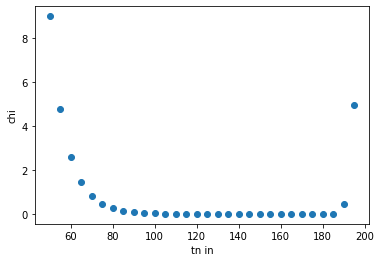

THE RESULT: 160.00000000000037
chisqds:  0.0
BUT ARE WE SURE?: 1588.1350826524558


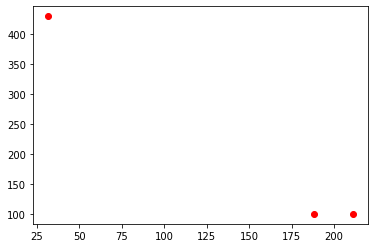

highHIIIIGHHHHHH:  129.0
rewaRD::  -100
stepping:  0
ACTION            :  [3.242818]
curtemp:  214.0
Temperature:  [ 32. 188. 211. 214.]
Intensity:  [430.03811335 100.3        100.3        100.3       ]


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


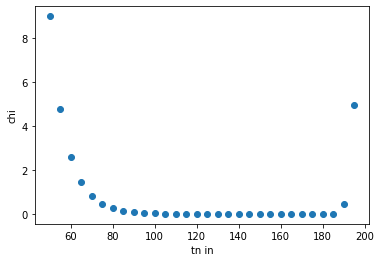

THE RESULT: 160.00000000000037
chisqds:  0.0
BUT ARE WE SURE?: 1588.1350826524558


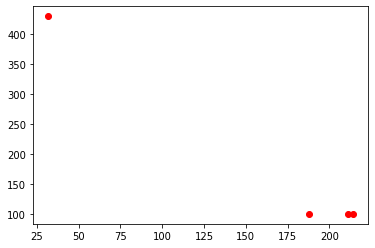

highHIIIIGHHHHHH:  126.0
rewaRD::  -100
stepping:  0
ACTION            :  [29.280153]
curtemp:  243.5
Temperature:  [ 32.  188.  211.  214.  243.5]
Intensity:  [430.03811335 100.3        100.3        100.3        100.3       ]


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


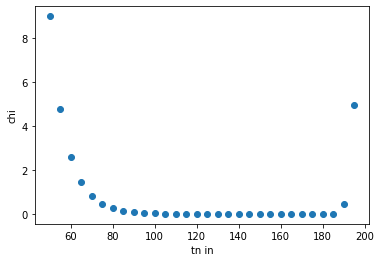

THE RESULT: 160.00000000000037
chisqds:  0.0
BUT ARE WE SURE?: 1588.1350826524558


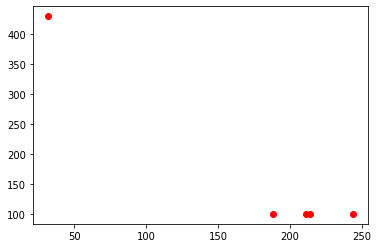

highHIIIIGHHHHHH:  96.5
rewaRD::  -100
stepping:  0
ACTION            :  [88.75806]
curtemp:  332.5
Temperature:  [ 32.  188.  211.  214.  243.5 332.5]
Intensity:  [430.03811335 100.3        100.3        100.3        100.3
 100.3       ]


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


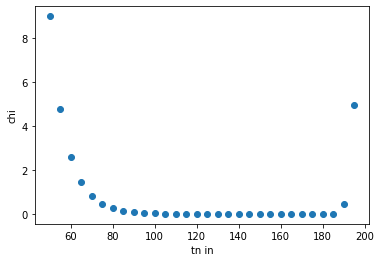

THE RESULT: 160.00000000000037
chisqds:  0.0
BUT ARE WE SURE?: 1588.1350826524558


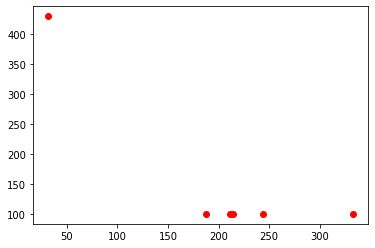

highHIIIIGHHHHHH:  7.5
rewaRD::  -100
stepping:  0
ACTION            :  [5.3934236]
curtemp:  338.0
Temperature:  [ 32.  188.  211.  214.  243.5 332.5 338. ]
Intensity:  [430.03811335 100.3        100.3        100.3        100.3
 100.3        100.3       ]


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


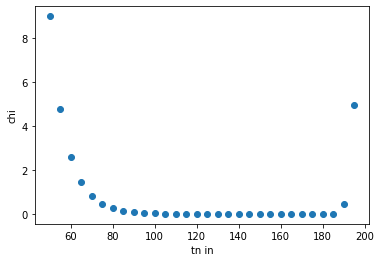

THE RESULT: 160.00000000000037
chisqds:  0.0
BUT ARE WE SURE?: 1588.1350826524558


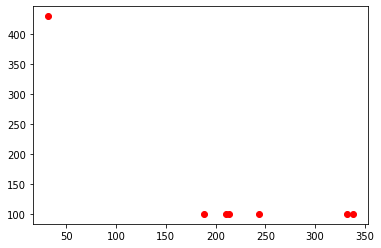

highHIIIIGHHHHHH:  2.0
rewaRD::  -100
stepping:  0
ACTION            :  [1.8013113]
curtemp:  340.0
Temperature:  [ 32.  188.  211.  214.  243.5 332.5 338.  340. ]
Intensity:  [430.03811335 100.3        100.3        100.3        100.3
 100.3        100.3        100.3       ]


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


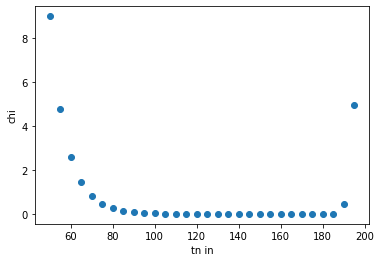

THE RESULT: 160.00000000000037
chisqds:  0.0
BUT ARE WE SURE?: 1588.1350826524558


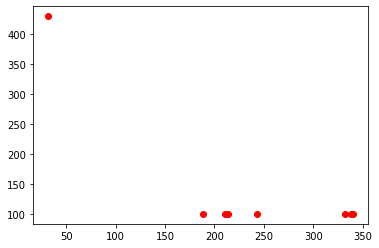

highHIIIIGHHHHHH:  0.0
rewaRD::  -100
terminated: oveer max temp
reset
stepping:  1
ACTION            :  [52.177017]
curtemp:  55.0
Temperature:  [55.]
highHIIIIGHHHHHH:  285.0
rewaRD::  -100
stepping:  1
ACTION            :  [257.56082]
curtemp:  312.5
Temperature:  [ 55.  312.5]
Intensity:  [422.58943412 100.3       ]


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


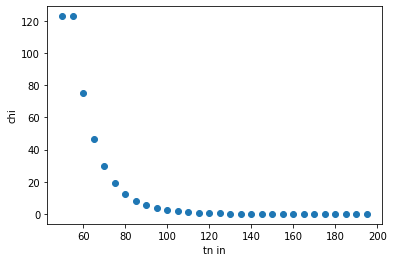

THE RESULT: 159.9999999997461
chisqds:  8.333793683310809e-24
BUT ARE WE SURE?: 87.87345321845652


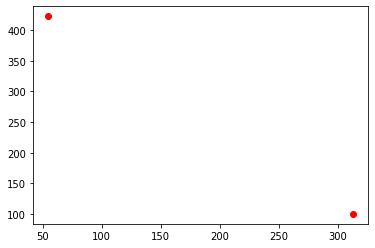

highHIIIIGHHHHHH:  27.5
rewaRD::  -100
stepping:  1
ACTION            :  [22.51403]
curtemp:  335.0
Temperature:  [ 55.  312.5 335. ]
Intensity:  [422.58943412 100.3        100.3       ]


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


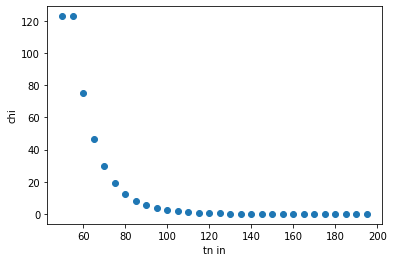

THE RESULT: 159.9999999997461
chisqds:  4.1668968416554046e-24
BUT ARE WE SURE?: 87.87345321845652


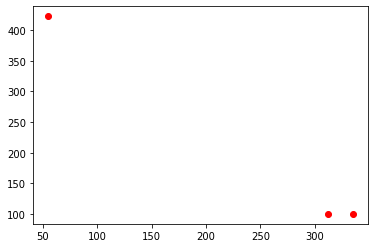

highHIIIIGHHHHHH:  5.0
rewaRD::  -100
Box(1,)
(1,)
True
[5.]
[0.5]
Box(4,)
(4,)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
from stable_baselines.common.env_checker import check_env
env = OrderEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)
a = env.action_space
o = env.observation_space
print(a)                    #prints Box(1,)
print(a.shape)              #prints (1,), note that you can do a.shape[0] which is 1 here
print(a.is_bounded())       #prints True if your action space is bounded
print(a.high)               #prints [1.] an array with the maximum value for each dim
print(a.low)                #prints [-1.] same for minimum value
print(o)
print(o.shape)

In [ ]:
from stable_baselines import DQN, PPO2, A2C, ACKTR
from stable_baselines.common.cmd_util import make_vec_env

# Instantiate the env
env = OrderEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1) #retrieve?

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))






Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



reset
stepping:  0
ACTION            :  [0.5]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  4.0
Temperature:  [3.5 4. ]
Intensity:  [430.3 430.3]


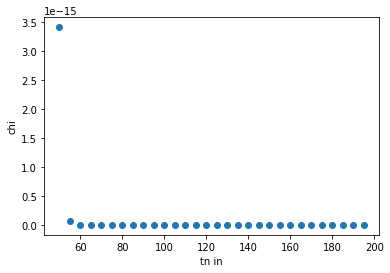

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


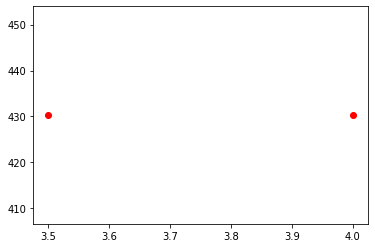

highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  4.5
Temperature:  [3.5 4.  4.5]
Intensity:  [430.3 430.3 430.3]


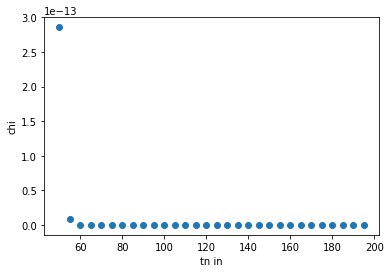

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


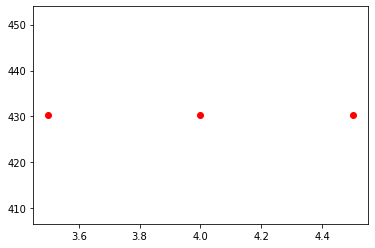

highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.65817547]
curtemp:  5.0
Temperature:  [3.5 4.  4.5 5. ]
Intensity:  [430.3 430.3 430.3 430.3]


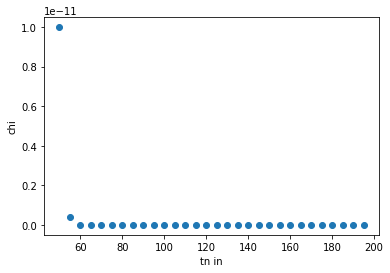

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


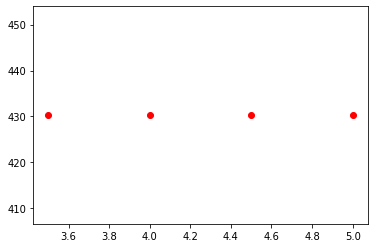

highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  5.5
Temperature:  [3.5 4.  4.5 5.  5.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


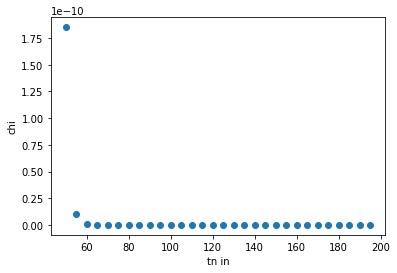

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


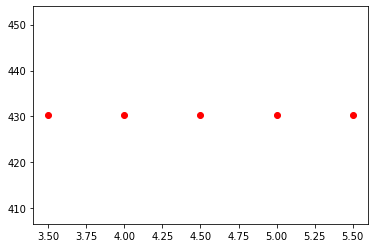

highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  6.0
Temperature:  [3.5 4.  4.5 5.  5.5 6. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


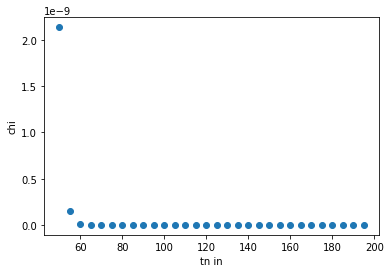

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


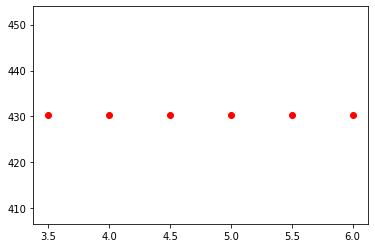

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  6.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3]


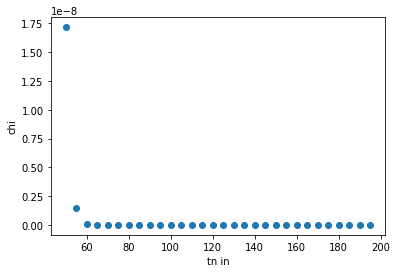

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


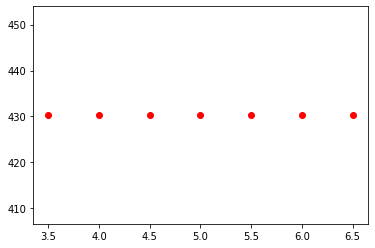

highHIIIIGHHHHHH:  333.5
rewaRD::  -100
stepping:  0
ACTION            :  [1.5287433]
curtemp:  8.0
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 8. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


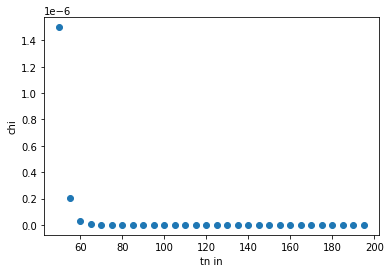

THE RESULT: 195.0
chisqds:  4.1210049689997656e-26
BUT ARE WE SURE?: 99999999.99999999


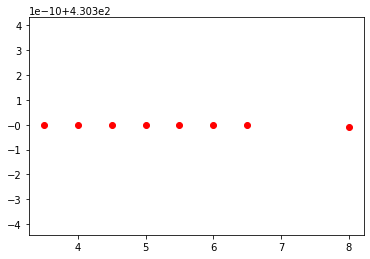

highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  0
ACTION            :  [1.1276888]
curtemp:  9.0
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 8.  9. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


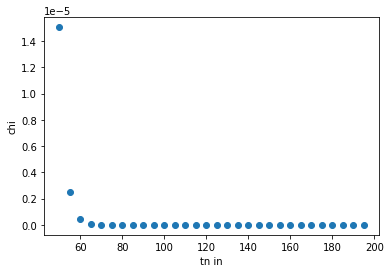

THE RESULT: 195.0
chisqds:  4.2802842890648655e-23
BUT ARE WE SURE?: 99999999.99999999


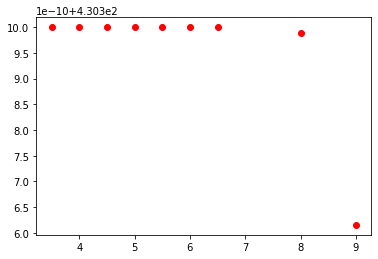

highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  9.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 8.  9.  9.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


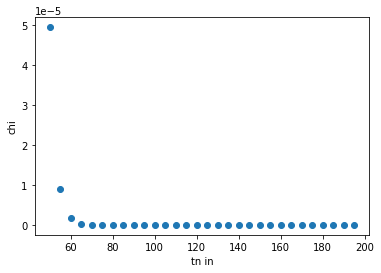

THE RESULT: 195.0
chisqds:  7.839113260853864e-22
BUT ARE WE SURE?: 99999999.99999999


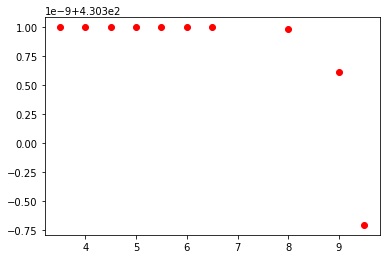

highHIIIIGHHHHHH:  330.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  10.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  8.   9.   9.5 10. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.29999999]


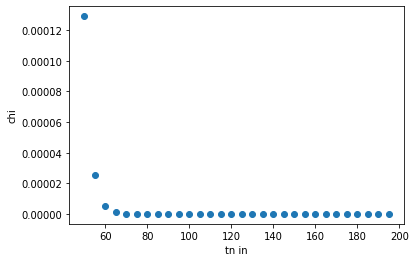

THE RESULT: 159.99998105703685
chisqds:  0.0
BUT ARE WE SURE?: 19329405453.4553


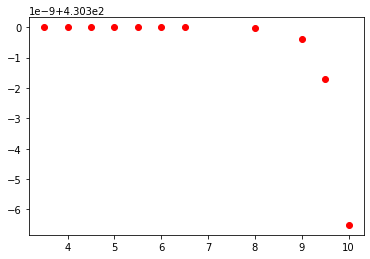

highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  10.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  8.   9.   9.5 10.  10.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.29999999 430.29999998]


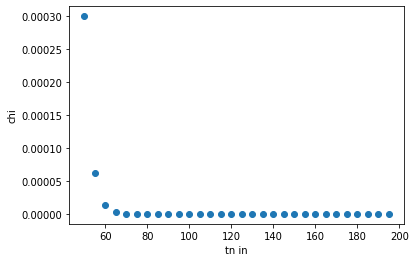

THE RESULT: 160.0000005320969
chisqds:  0.0
BUT ARE WE SURE?: 5953848172.657495


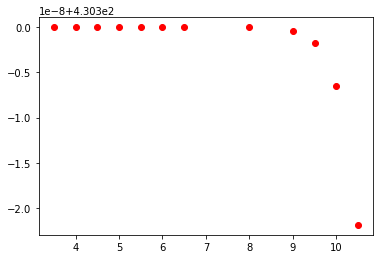

highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  11.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  8.   9.   9.5 10.  10.5 11. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.29999999 430.29999998 430.29999993]


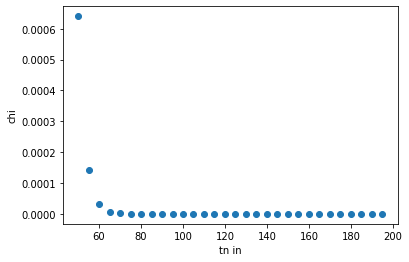

THE RESULT: 159.99999759214555
chisqds:  0.0
BUT ARE WE SURE?: 2043969533.6676157


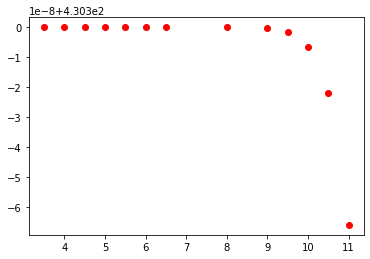

highHIIIIGHHHHHH:  329.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  11.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  8.   9.   9.5 10.  10.5 11.  11.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.29999999 430.29999998 430.29999993 430.29999982]


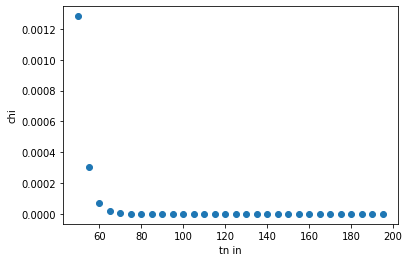

THE RESULT: 159.99999993699882
chisqds:  0.0
BUT ARE WE SURE?: 770587666.8324091


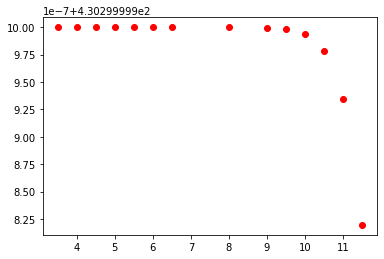

highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  12.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  8.   9.   9.5 10.  10.5 11.  11.5
 12. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.29999999 430.29999998 430.29999993 430.29999982 430.29999955]


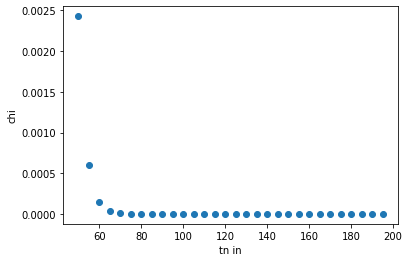

THE RESULT: 160.0000009588207
chisqds:  5.363657035278408e-31
BUT ARE WE SURE?: 314915188.74298173


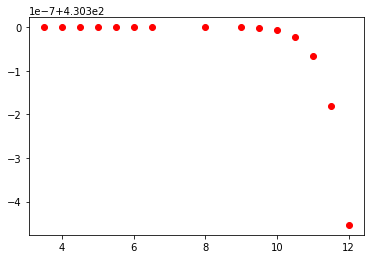

highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  12.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  8.   9.   9.5 10.  10.5 11.  11.5
 12.  12.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.29999999 430.29999998 430.29999993 430.29999982 430.29999955
 430.29999894]


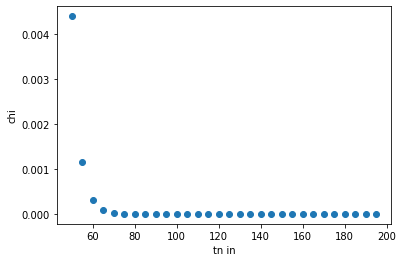

THE RESULT: 159.9999995923646
chisqds:  0.0
BUT ARE WE SURE?: 138214234.56521487


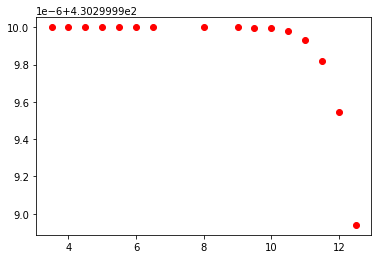

highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  13.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  8.   9.   9.5 10.  10.5 11.  11.5
 12.  12.5 13. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.29999999 430.29999998 430.29999993 430.29999982 430.29999955
 430.29999894 430.29999768]


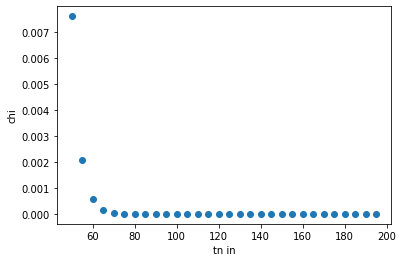

THE RESULT: 160.00000008313629
chisqds:  9.386399818353052e-31
BUT ARE WE SURE?: 64596612.463621885


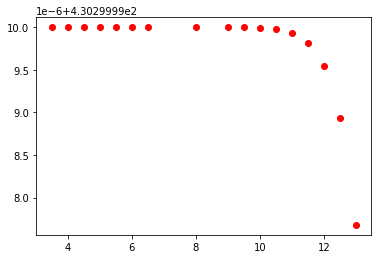

highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  13.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  8.   9.   9.5 10.  10.5 11.  11.5
 12.  12.5 13.  13.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.29999999 430.29999998 430.29999993 430.29999982 430.29999955
 430.29999894 430.29999768 430.29999521]


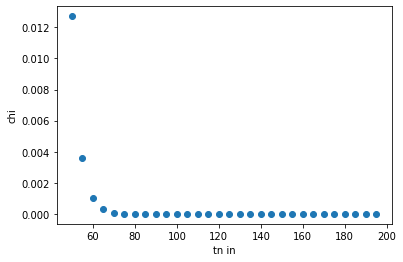

THE RESULT: 159.9999999941397
chisqds:  0.0
BUT ARE WE SURE?: 31930267.794429973


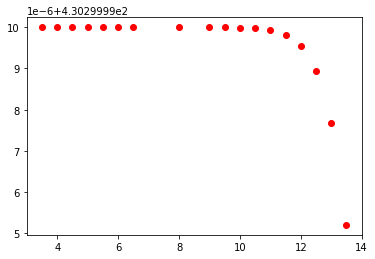

highHIIIIGHHHHHH:  326.5
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  14.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  8.   9.   9.5 10.  10.5 11.  11.5
 12.  12.5 13.  13.5 14. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.29999999 430.29999998 430.29999993 430.29999982 430.29999955
 430.29999894 430.29999768 430.29999521 430.2999906 ]


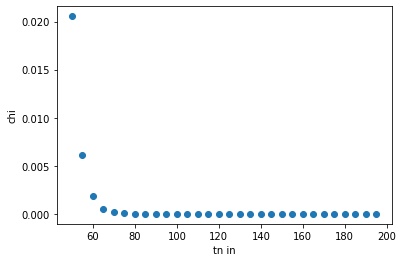

THE RESULT: 160.00000001560332
chisqds:  4.171733249660984e-31
BUT ARE WE SURE?: 16592321.939187458


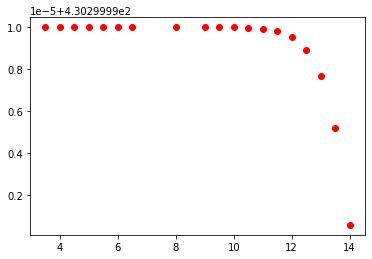

highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  0
ACTION            :  [0.5]
curtemp:  14.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  8.   9.   9.5 10.  10.5 11.  11.5
 12.  12.5 13.  13.5 14.  14.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.29999999 430.29999998 430.29999993 430.29999982 430.29999955
 430.29999894 430.29999768 430.29999521 430.2999906  430.29998239]


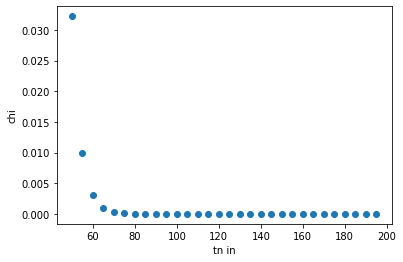

THE RESULT: 160.0000000012731
chisqds:  0.0
BUT ARE WE SURE?: 9017320.056932464


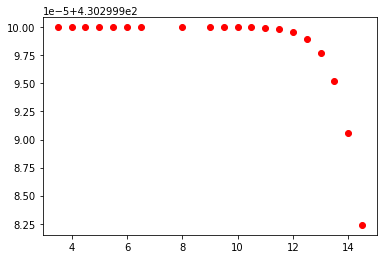

highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  0
ACTION            :  [1.3509551]
curtemp:  16.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  8.   9.   9.5 10.  10.5 11.  11.5
 12.  12.5 13.  13.5 14.  14.5 16. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.29999999 430.29999998 430.29999993 430.29999982 430.29999955
 430.29999894 430.29999768 430.29999521 430.2999906  430.29998239
 430.29990864]


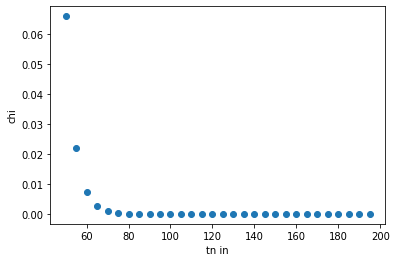

THE RESULT: 160.00000000512838
chisqds:  3.7545599246948857e-31
BUT ARE WE SURE?: 2214516.2455157912


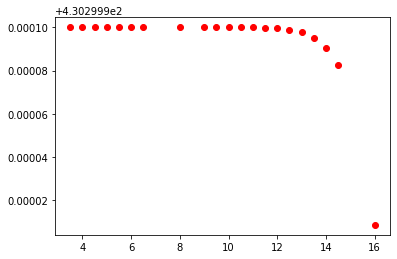

highHIIIIGHHHHHH:  324.0
rewaRD::  -100
terminated: excellent conditions
reset
stepping:  1
ACTION            :  [0.5]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  1
ACTION            :  [0.5283927]
curtemp:  4.0
Temperature:  [3.5 4. ]
Intensity:  [430.3 430.3]


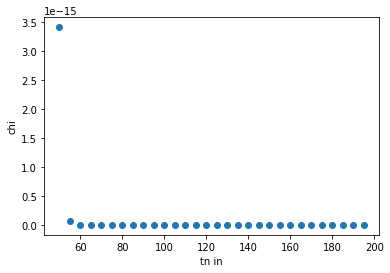

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


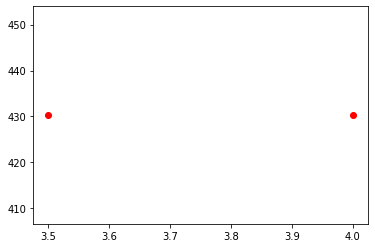

highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  4.5
Temperature:  [3.5 4.  4.5]
Intensity:  [430.3 430.3 430.3]


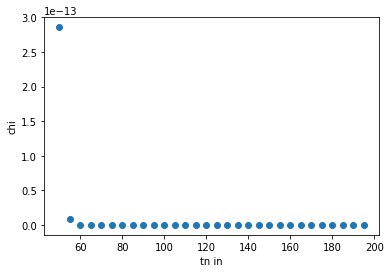

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


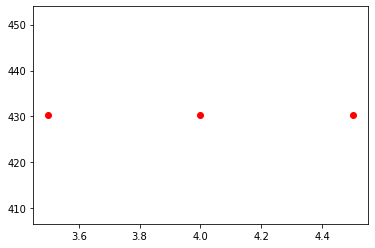

highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  5.0
Temperature:  [3.5 4.  4.5 5. ]
Intensity:  [430.3 430.3 430.3 430.3]


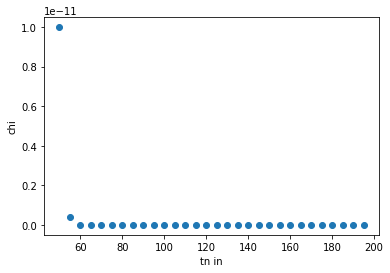

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


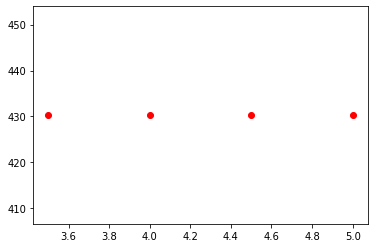

highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  5.5
Temperature:  [3.5 4.  4.5 5.  5.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


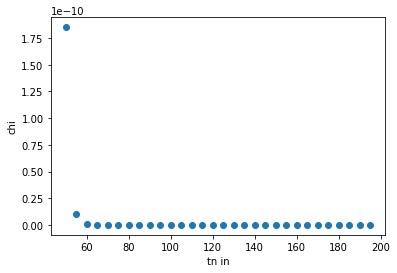

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


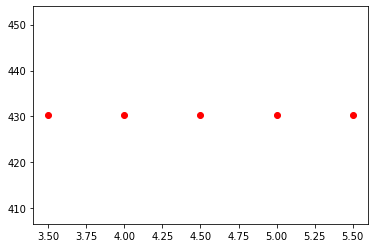

highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  6.0
Temperature:  [3.5 4.  4.5 5.  5.5 6. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


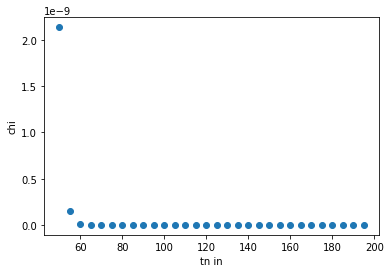

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


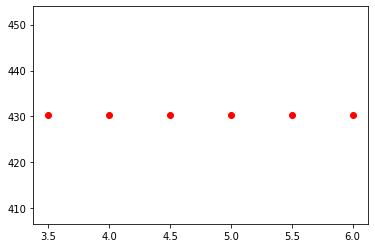

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  6.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3]


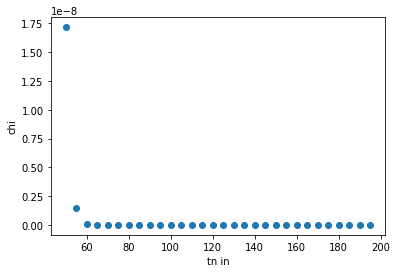

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


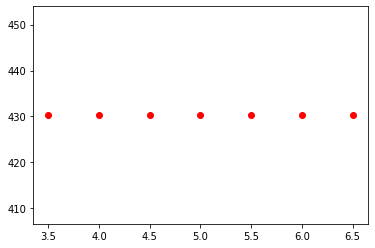

highHIIIIGHHHHHH:  333.5
rewaRD::  -100
stepping:  1
ACTION            :  [0.98185253]
curtemp:  7.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


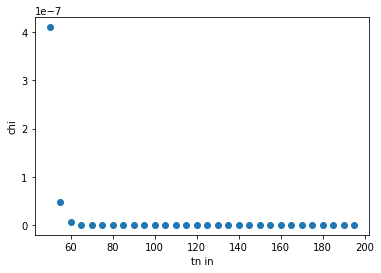

THE RESULT: 195.0
chisqds:  5.674749137340759e-28
BUT ARE WE SURE?: 99999999.99999999


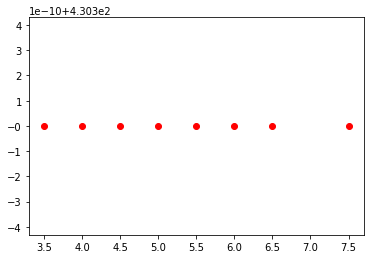

highHIIIIGHHHHHH:  332.5
rewaRD::  -100
stepping:  1
ACTION            :  [0.89600104]
curtemp:  8.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.5 8.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


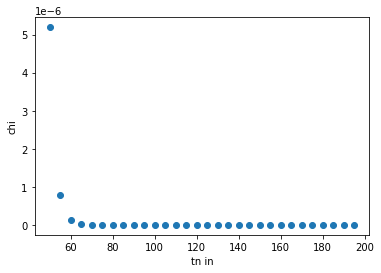

THE RESULT: 170.0984999999971
chisqds:  1.1074036940613027e-24
BUT ARE WE SURE?: 99999999.99999999


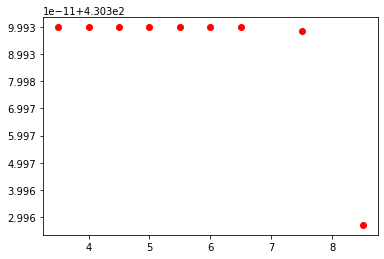

highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  9.0
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.5 8.5 9. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


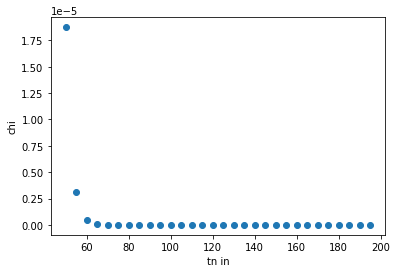

THE RESULT: 160.0003790155056
chisqds:  0.0
BUT ARE WE SURE?: 276787509650.8506


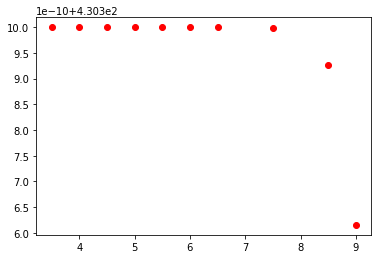

highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  9.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.5 8.5 9.  9.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


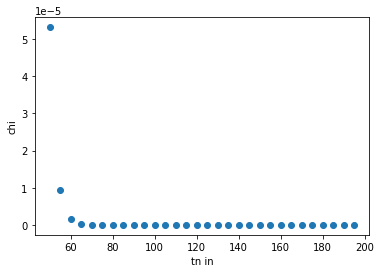

THE RESULT: 159.99994323672445
chisqds:  0.0
BUT ARE WE SURE?: 72040327735.53572


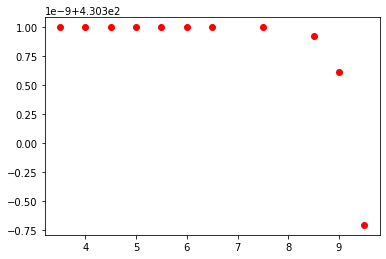

highHIIIIGHHHHHH:  330.5
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  10.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.5  9.   9.5 10. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999]


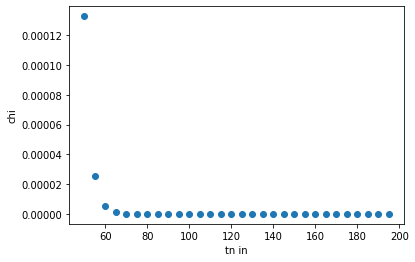

THE RESULT: 160.00001333323934
chisqds:  0.0
BUT ARE WE SURE?: 19328985689.77442


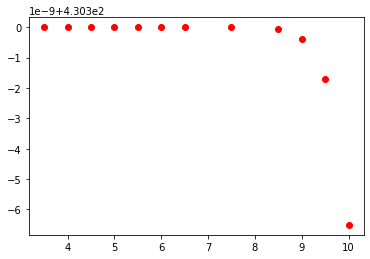

highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  1
ACTION            :  [1.8851923]
curtemp:  12.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.5  9.   9.5 10.  12. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999955]


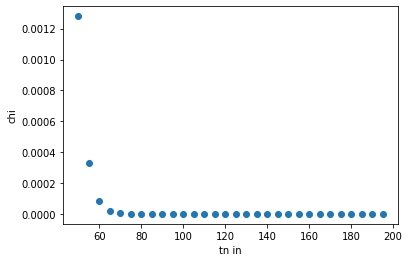

THE RESULT: 160.00000098915035
chisqds:  6.257599874491476e-31
BUT ARE WE SURE?: 344988478.4556932


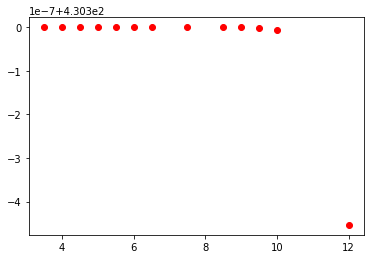

highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  1
ACTION            :  [0.6197907]
curtemp:  12.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.5  9.   9.5 10.  12.  12.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999955 430.29999894]


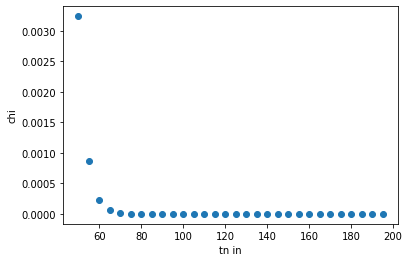

THE RESULT: 159.99999956457754
chisqds:  0.0
BUT ARE WE SURE?: 140488874.6259276


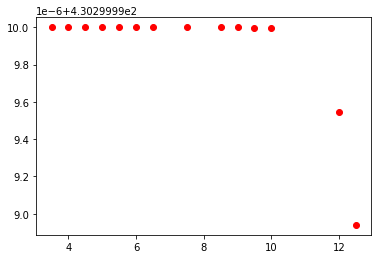

highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  13.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.5  9.   9.5 10.  12.  12.5
 13. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999955 430.29999894 430.29999768]


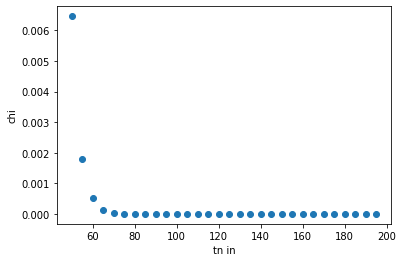

THE RESULT: 160.00000005337625
chisqds:  1.0727314078117775e-30
BUT ARE WE SURE?: 64824414.13741261


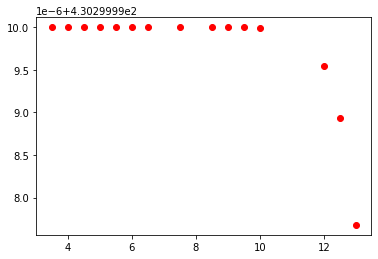

highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  13.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.5  9.   9.5 10.  12.  12.5
 13.  13.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999955 430.29999894 430.29999768
 430.29999521]


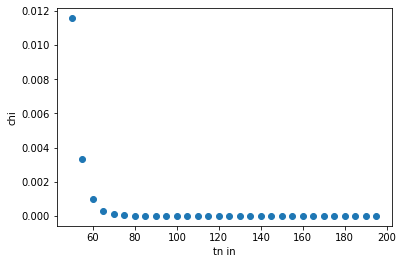

THE RESULT: 160.00000002829086
chisqds:  5.006079899593181e-31
BUT ARE WE SURE?: 31957671.01820067


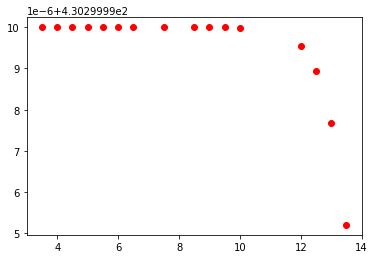

highHIIIIGHHHHHH:  326.5
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  14.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.5  9.   9.5 10.  12.  12.5
 13.  13.5 14. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999955 430.29999894 430.29999768
 430.29999521 430.2999906 ]


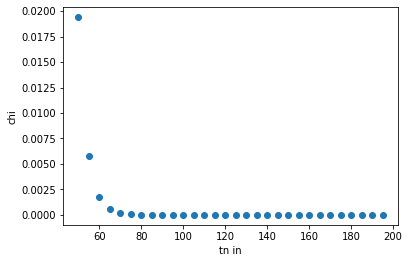

THE RESULT: 160.00000000167876
chisqds:  0.0
BUT ARE WE SURE?: 16596168.590207087


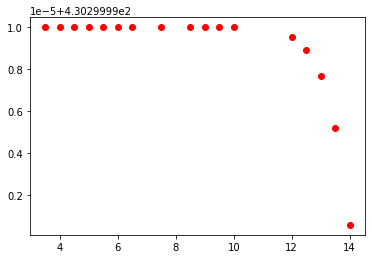

highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  14.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.5  9.   9.5 10.  12.  12.5
 13.  13.5 14.  14.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999955 430.29999894 430.29999768
 430.29999521 430.2999906  430.29998239]


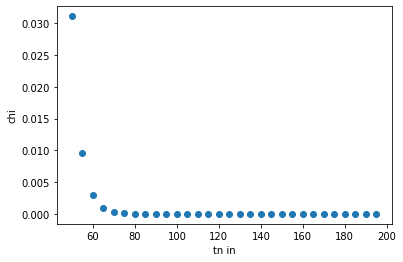

THE RESULT: 160.00000003276145
chisqds:  4.417129323170454e-31
BUT ARE WE SURE?: 9017930.425314946


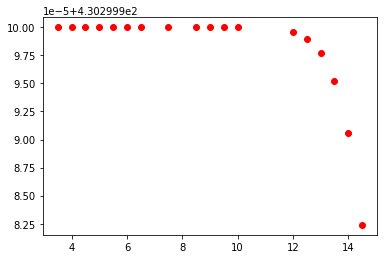

highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  15.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.5  9.   9.5 10.  12.  12.5
 13.  13.5 14.  14.5 15. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999955 430.29999894 430.29999768
 430.29999521 430.2999906  430.29998239 430.29996838]


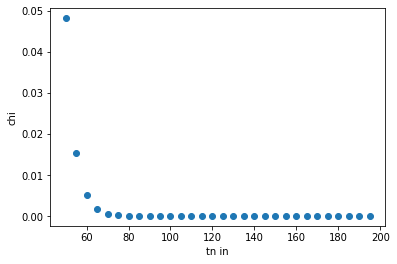

THE RESULT: 159.99999999991462
chisqds:  0.0
BUT ARE WE SURE?: 5102475.44281274


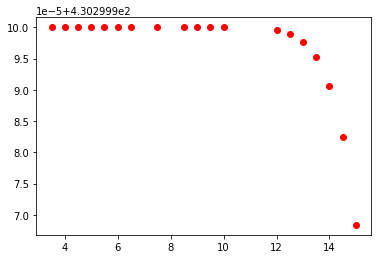

highHIIIIGHHHHHH:  325.0
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  15.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.5  9.   9.5 10.  12.  12.5
 13.  13.5 14.  14.5 15.  15.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999955 430.29999894 430.29999768
 430.29999521 430.2999906  430.29998239 430.29996838 430.29994532]


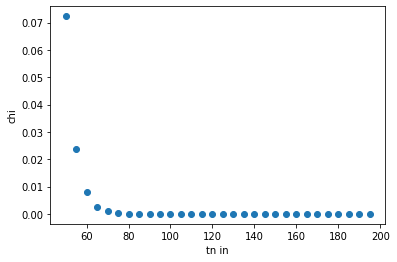

THE RESULT: 159.99999999023458
chisqds:  3.9521684993493145e-31
BUT ARE WE SURE?: 2994331.035179759


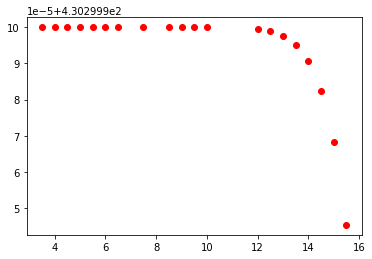

highHIIIIGHHHHHH:  324.5
rewaRD::  -100
stepping:  1
ACTION            :  [0.5]
curtemp:  16.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.5  9.   9.5 10.  12.  12.5
 13.  13.5 14.  14.5 15.  15.5 16. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999955 430.29999894 430.29999768
 430.29999521 430.2999906  430.29998239 430.29996838 430.29994532
 430.29990864]


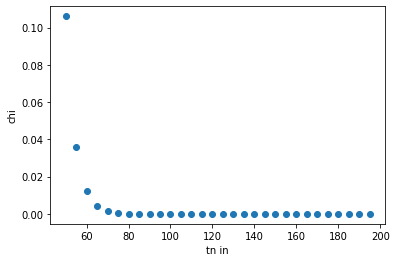

THE RESULT: 159.9999999995888
chisqds:  0.0
BUT ARE WE SURE?: 1816244.195410364


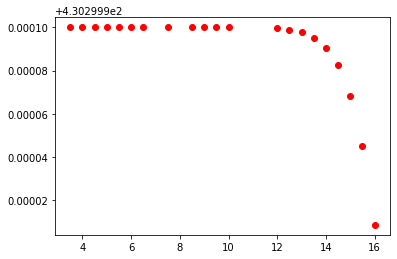

highHIIIIGHHHHHH:  324.0
rewaRD::  -100
terminated: excellent conditions
reset
stepping:  2
ACTION            :  [0.5]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  2
ACTION            :  [0.5]
curtemp:  4.0
Temperature:  [3.5 4. ]
Intensity:  [430.3 430.3]


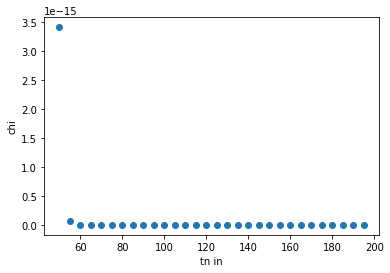

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


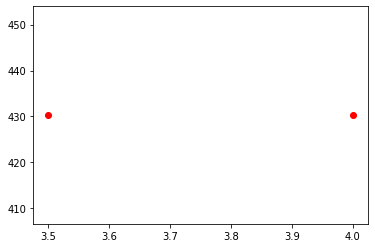

highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  2
ACTION            :  [0.61584467]
curtemp:  4.5
Temperature:  [3.5 4.  4.5]
Intensity:  [430.3 430.3 430.3]


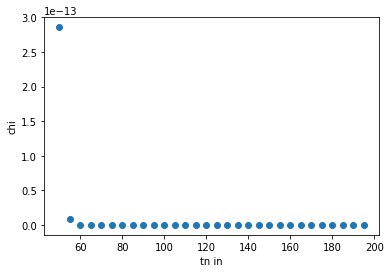

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


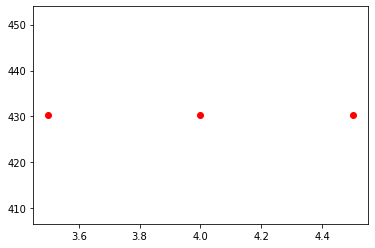

highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  2
ACTION            :  [0.5]
curtemp:  5.0
Temperature:  [3.5 4.  4.5 5. ]
Intensity:  [430.3 430.3 430.3 430.3]


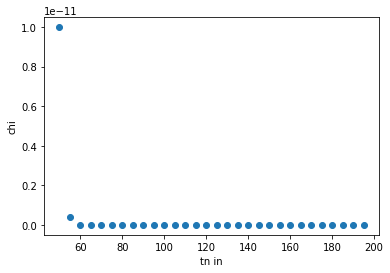

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


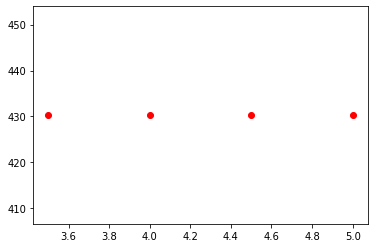

highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  2
ACTION            :  [0.5766263]
curtemp:  5.5
Temperature:  [3.5 4.  4.5 5.  5.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


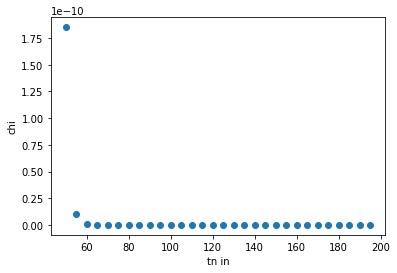

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


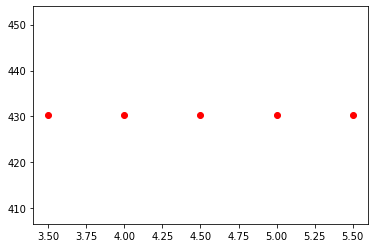

highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  2
ACTION            :  [0.5]
curtemp:  6.0
Temperature:  [3.5 4.  4.5 5.  5.5 6. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


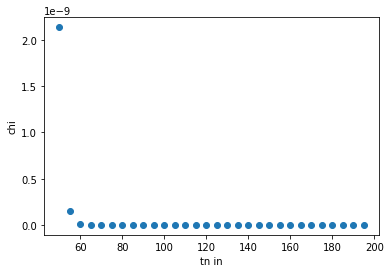

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


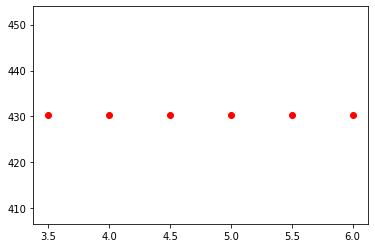

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  2
ACTION            :  [1.5288686]
curtemp:  7.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  7.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3]


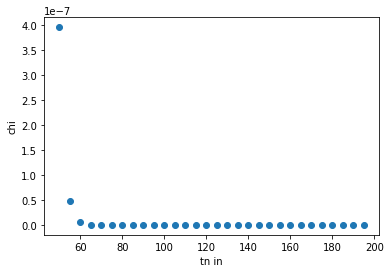

THE RESULT: 195.0
chisqds:  6.6205406602308845e-28
BUT ARE WE SURE?: 99999999.99999999


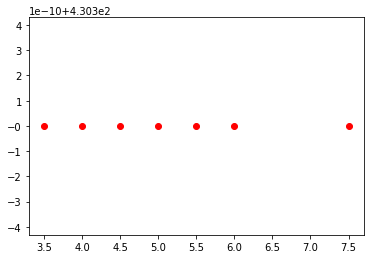

highHIIIIGHHHHHH:  332.5
rewaRD::  -100
stepping:  2
ACTION            :  [0.5]
curtemp:  8.0
Temperature:  [3.5 4.  4.5 5.  5.5 6.  7.5 8. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


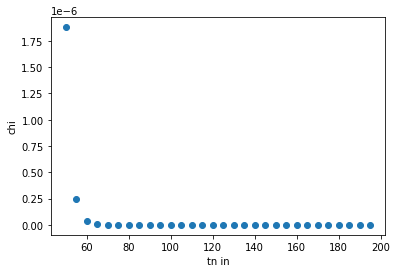

THE RESULT: 195.0
chisqds:  4.1777524603731734e-26
BUT ARE WE SURE?: 99999999.99999999


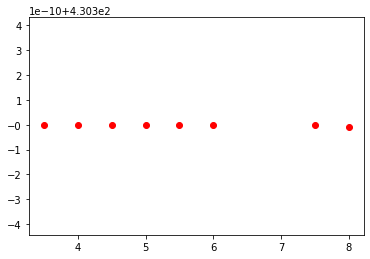

highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  2
ACTION            :  [0.70397896]
curtemp:  8.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  7.5 8.  8.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


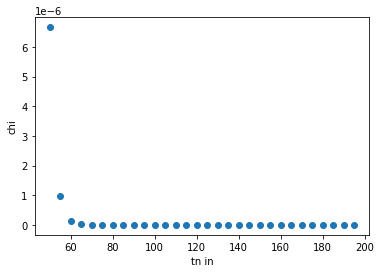

THE RESULT: 170.0984999999971
chisqds:  1.1345303894886198e-24
BUT ARE WE SURE?: 99999999.99999999


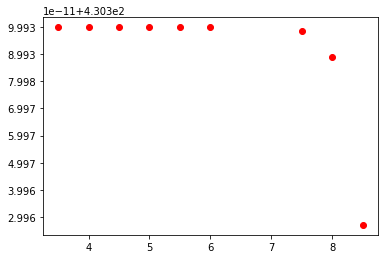

highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  2
ACTION            :  [2.028707]
curtemp:  10.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998]


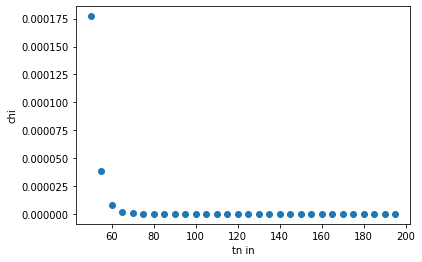

THE RESULT: 159.99999958197841
chisqds:  0.0
BUT ARE WE SURE?: 6258104663.328709


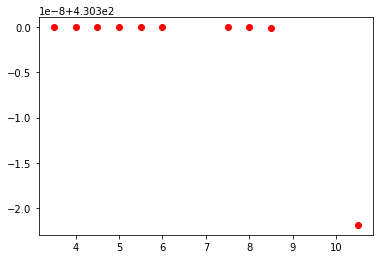

highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  2
ACTION            :  [0.7674479]
curtemp:  11.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5 11.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999982]


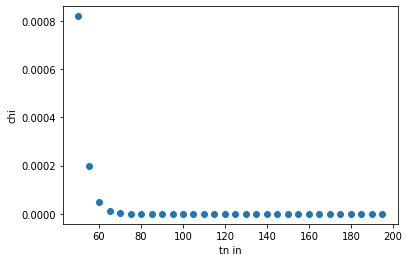

THE RESULT: 160.00000387887744
chisqds:  7.509119844618947e-31
BUT ARE WE SURE?: 824722303.7278295


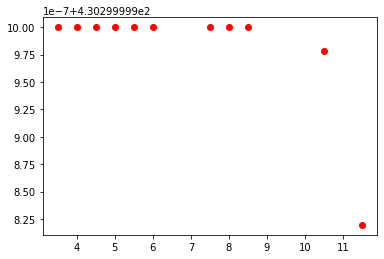

highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  2
ACTION            :  [0.5]
curtemp:  12.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5 11.5 12. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999982 430.29999955]


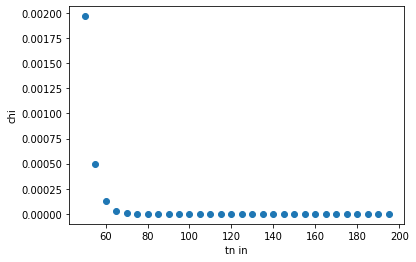

THE RESULT: 160.00000125556758
chisqds:  6.826472590354337e-31
BUT ARE WE SURE?: 318308210.02524817


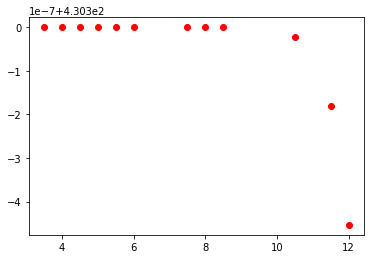

highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  2
ACTION            :  [0.5]
curtemp:  12.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5 11.5 12.  12.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999982 430.29999955 430.29999894]


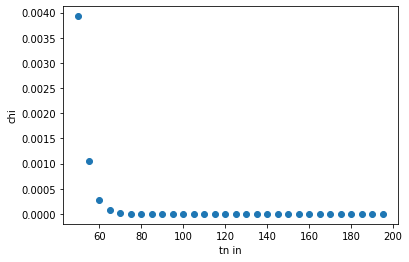

THE RESULT: 159.99999988397258
chisqds:  0.0
BUT ARE WE SURE?: 138493111.48411256


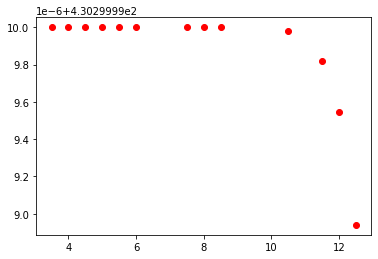

highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  2
ACTION            :  [1.3988001]
curtemp:  14.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5 11.5 12.  12.5 14. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906 ]


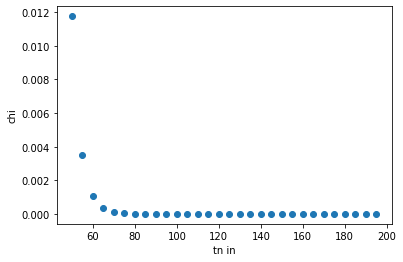

THE RESULT: 159.99999998405494
chisqds:  0.0
BUT ARE WE SURE?: 19232059.297127265


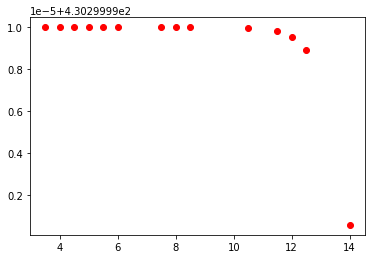

highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  2
ACTION            :  [2.024478]
curtemp:  16.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5 11.5 12.  12.5 14.
 16. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29990864]


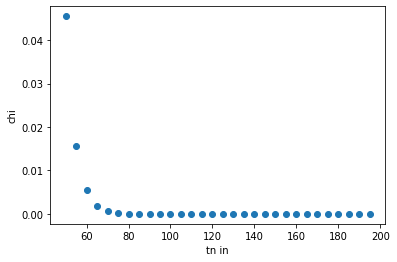

THE RESULT: 160.00000000756756
chisqds:  5.363657035278408e-31
BUT ARE WE SURE?: 2268528.994422944


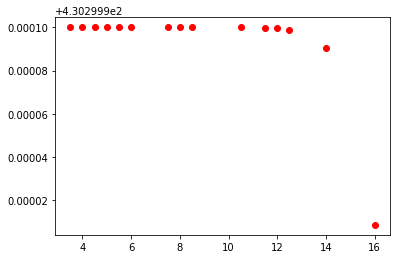

highHIIIIGHHHHHH:  324.0
rewaRD::  -100
stepping:  2
ACTION            :  [0.5]
curtemp:  16.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5 11.5 12.  12.5 14.
 16.  16.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29990864
 430.29985202]


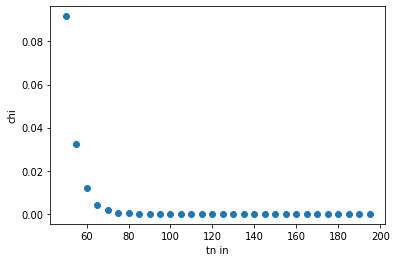

THE RESULT: 159.99999999906805
chisqds:  2.0024323828734025e-30
BUT ARE WE SURE?: 1224387.9551895943


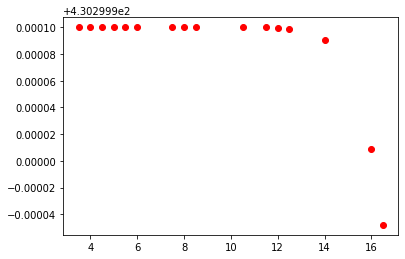

highHIIIIGHHHHHH:  323.5
rewaRD::  -100
stepping:  2
ACTION            :  [0.5]
curtemp:  17.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5 11.5 12.  12.5 14.
 16.  16.5 17. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29990864
 430.29985202 430.29976701]


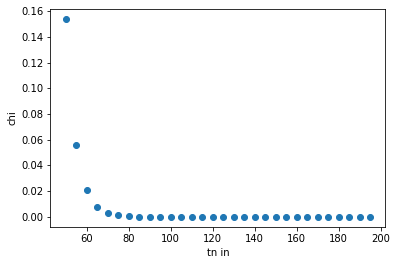

THE RESULT: 159.99999999835626
chisqds:  1.877280358943815e-30
BUT ARE WE SURE?: 751420.2354135254


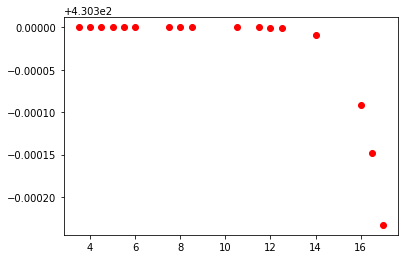

highHIIIIGHHHHHH:  323.0
rewaRD::  -100
stepping:  2
ACTION            :  [0.5]
curtemp:  17.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5 11.5 12.  12.5 14.
 16.  16.5 17.  17.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29990864
 430.29985202 430.29976701 430.29964256]


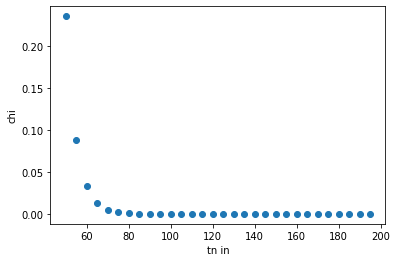

THE RESULT: 159.99999999943165
chisqds:  1.766853195076863e-30
BUT ARE WE SURE?: 486607.1435570303


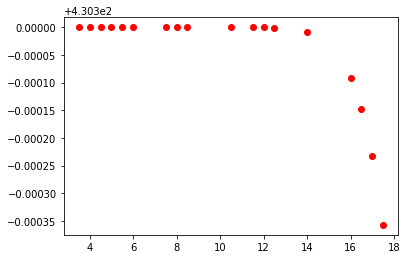

highHIIIIGHHHHHH:  322.5
rewaRD::  -100
stepping:  2
ACTION            :  [0.5]
curtemp:  18.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5 11.5 12.  12.5 14.
 16.  16.5 17.  17.5 18. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29990864
 430.29985202 430.29976701 430.29964256 430.29946452]


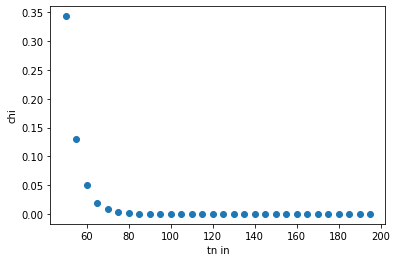

THE RESULT: 159.9999999997202
chisqds:  1.6686946842392596e-30
BUT ARE WE SURE?: 325725.47796808486


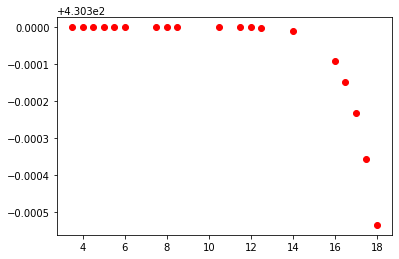

highHIIIIGHHHHHH:  322.0
rewaRD::  -100
stepping:  2
ACTION            :  [0.6738662]
curtemp:  18.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5 11.5 12.  12.5 14.
 16.  16.5 17.  17.5 18.  18.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29990864
 430.29985202 430.29976701 430.29964256 430.29946452 430.29921514]


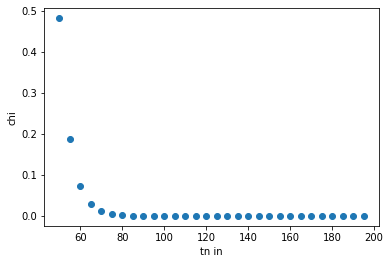

THE RESULT: 159.99999999997019
chisqds:  0.0
BUT ARE WE SURE?: 223574.00011801743


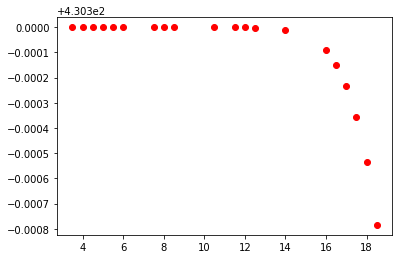

highHIIIIGHHHHHH:  321.5
rewaRD::  -100
stepping:  2
ACTION            :  [0.5]
curtemp:  19.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.5  8.   8.5 10.5 11.5 12.  12.5 14.
 16.  16.5 17.  17.5 18.  18.5 19. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29990864
 430.29985202 430.29976701 430.29964256 430.29946452 430.29921514
 430.29887253]


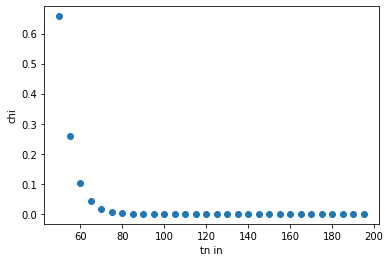

THE RESULT: 159.99999999939374
chisqds:  5.256389645726614e-30
BUT ARE WE SURE?: 156734.9134208056


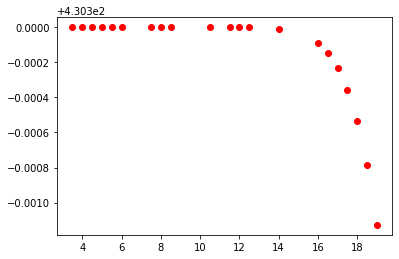

highHIIIIGHHHHHH:  321.0
rewaRD::  -100
terminated: excellent conditions
reset
stepping:  3
ACTION            :  [0.5]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  4.0
Temperature:  [3.5 4. ]
Intensity:  [430.3 430.3]


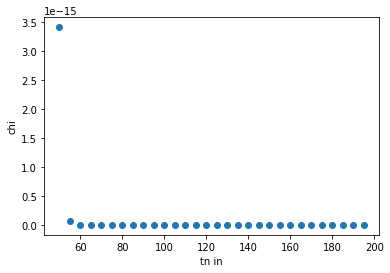

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


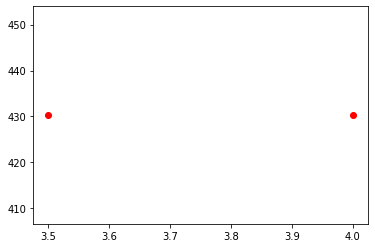

highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  4.5
Temperature:  [3.5 4.  4.5]
Intensity:  [430.3 430.3 430.3]


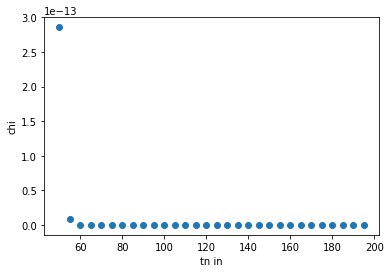

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


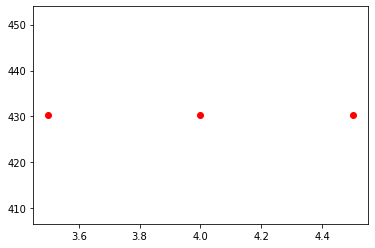

highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  3
ACTION            :  [1.1104206]
curtemp:  5.5
Temperature:  [3.5 4.  4.5 5.5]
Intensity:  [430.3 430.3 430.3 430.3]


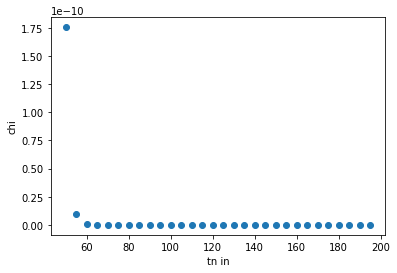

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


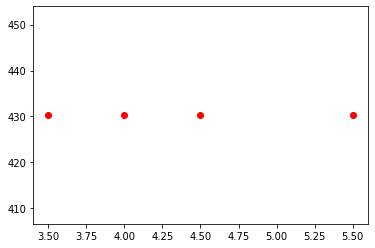

highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  3
ACTION            :  [0.7172385]
curtemp:  6.0
Temperature:  [3.5 4.  4.5 5.5 6. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


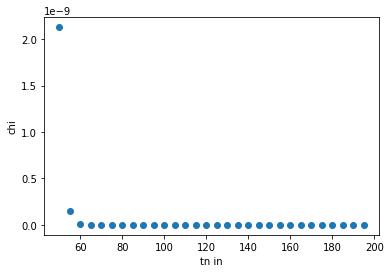

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


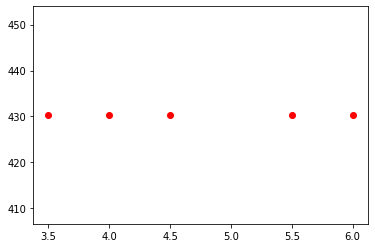

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  6.5
Temperature:  [3.5 4.  4.5 5.5 6.  6.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


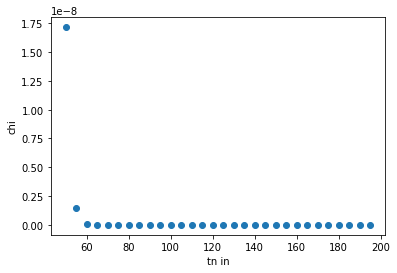

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


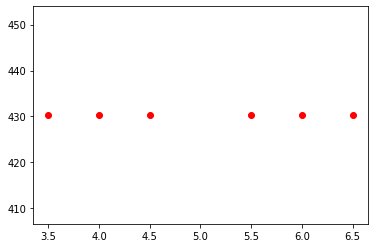

highHIIIIGHHHHHH:  333.5
rewaRD::  -100
stepping:  3
ACTION            :  [0.6059481]
curtemp:  7.0
Temperature:  [3.5 4.  4.5 5.5 6.  6.5 7. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3]


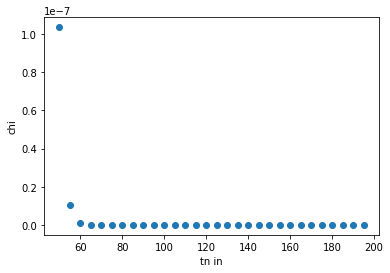

THE RESULT: 195.0
chisqds:  1.1263679762207524e-29
BUT ARE WE SURE?: 99999999.99999999


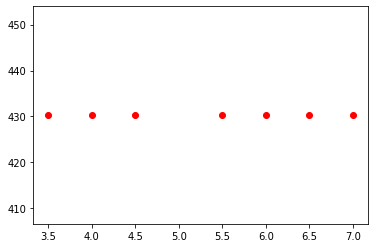

highHIIIIGHHHHHH:  333.0
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  7.5
Temperature:  [3.5 4.  4.5 5.5 6.  6.5 7.  7.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


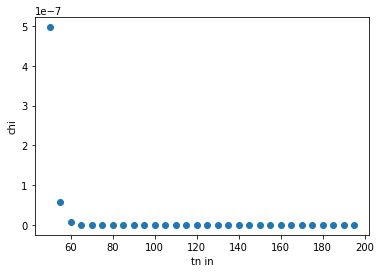

THE RESULT: 195.0
chisqds:  5.771294963873965e-28
BUT ARE WE SURE?: 99999999.99999999


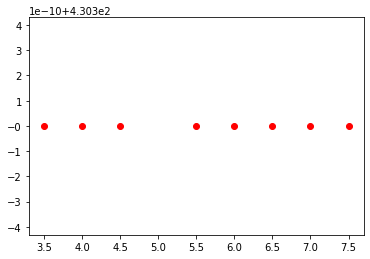

highHIIIIGHHHHHH:  332.5
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  8.0
Temperature:  [3.5 4.  4.5 5.5 6.  6.5 7.  7.5 8. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


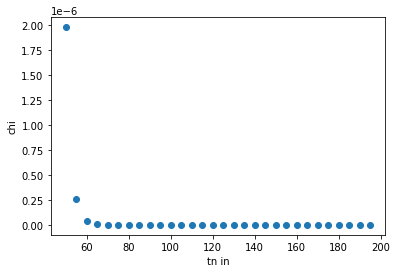

THE RESULT: 195.0
chisqds:  3.656378178808692e-26
BUT ARE WE SURE?: 99999999.99999999


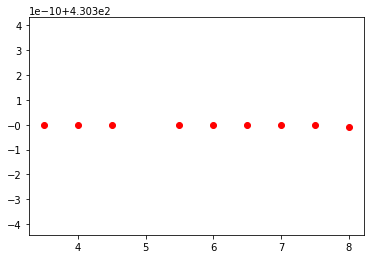

highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  3
ACTION            :  [1.761589]
curtemp:  10.0
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999]


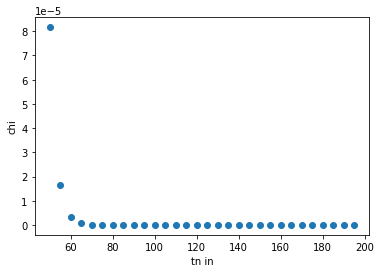

THE RESULT: 160.0000096694281
chisqds:  0.0
BUT ARE WE SURE?: 20064692213.428913


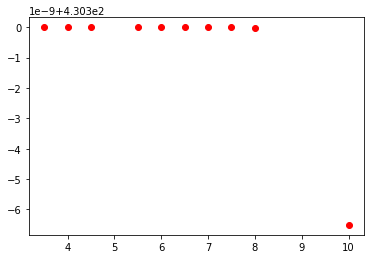

highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  10.5
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10.  10.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999
 430.29999998]


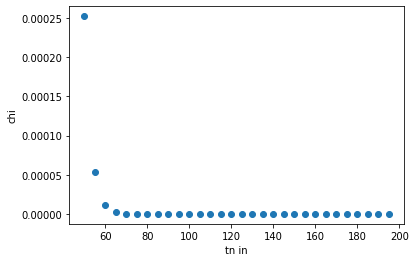

THE RESULT: 160.0000022162027
chisqds:  0.0
BUT ARE WE SURE?: 5974273961.128603


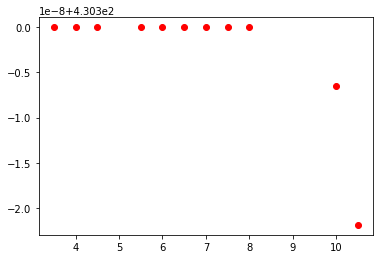

highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  3
ACTION            :  [0.78916556]
curtemp:  11.5
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10.  10.5 11.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999
 430.29999998 430.29999982]


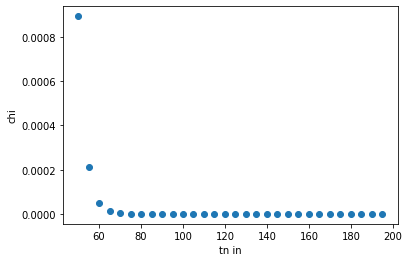

THE RESULT: 160.00000156620104
chisqds:  0.0
BUT ARE WE SURE?: 824026534.3248214


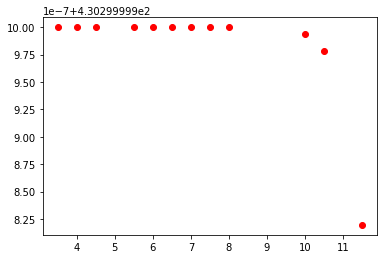

highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  12.0
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10.  10.5 11.5 12. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999
 430.29999998 430.29999982 430.29999955]


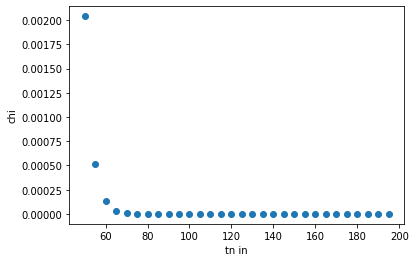

THE RESULT: 160.00000121801614
chisqds:  6.257599874491476e-31
BUT ARE WE SURE?: 318268165.1540269


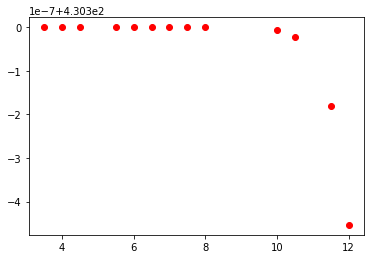

highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  12.5
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10.  10.5 11.5 12.  12.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999
 430.29999998 430.29999982 430.29999955 430.29999894]


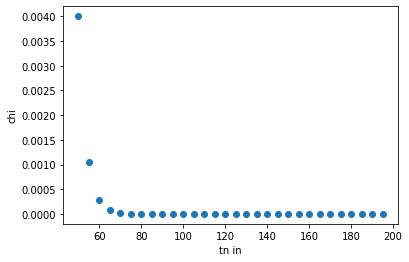

THE RESULT: 159.9999997396285
chisqds:  0.0
BUT ARE WE SURE?: 138489812.57776055


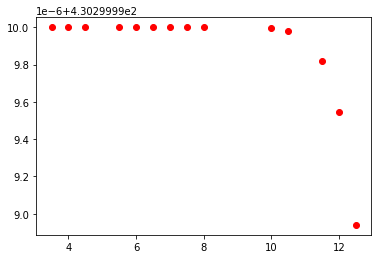

highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  3
ACTION            :  [0.5722295]
curtemp:  13.0
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10.  10.5 11.5 12.  12.5
 13. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999
 430.29999998 430.29999982 430.29999955 430.29999894 430.29999768]


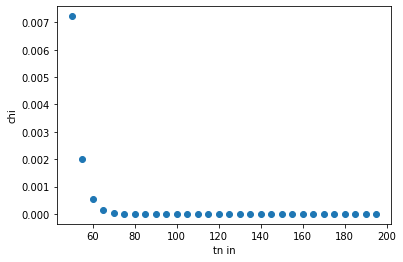

THE RESULT: 159.99999975972318
chisqds:  2.1454628234224227e-30
BUT ARE WE SURE?: 64626814.26347288


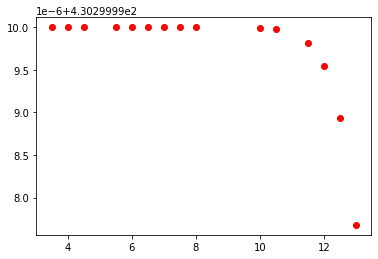

highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  3
ACTION            :  [0.5669063]
curtemp:  13.5
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10.  10.5 11.5 12.  12.5
 13.  13.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999
 430.29999998 430.29999982 430.29999955 430.29999894 430.29999768
 430.29999521]


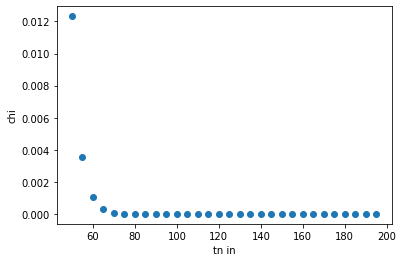

THE RESULT: 159.99999997645952
chisqds:  0.0
BUT ARE WE SURE?: 31933844.883899495


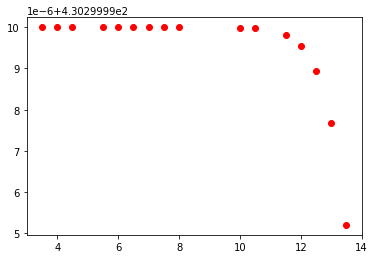

highHIIIIGHHHHHH:  326.5
rewaRD::  -100
stepping:  3
ACTION            :  [0.8028806]
curtemp:  14.5
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10.  10.5 11.5 12.  12.5
 13.  13.5 14.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999
 430.29999998 430.29999982 430.29999955 430.29999894 430.29999768
 430.29999521 430.29998239]


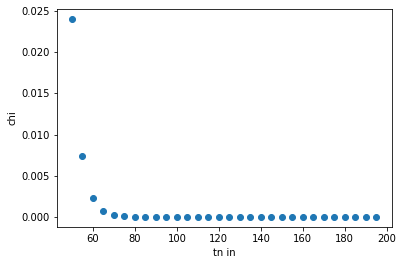

THE RESULT: 160.0000000018266
chisqds:  0.0
BUT ARE WE SURE?: 10181532.811946237


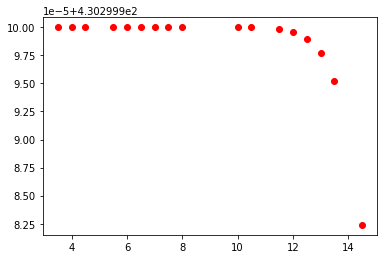

highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  15.0
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10.  10.5 11.5 12.  12.5
 13.  13.5 14.5 15. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999
 430.29999998 430.29999982 430.29999955 430.29999894 430.29999768
 430.29999521 430.29998239 430.29996838]


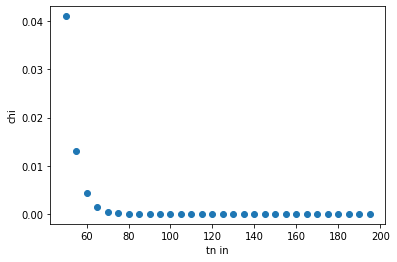

THE RESULT: 159.99999997857745
chisqds:  4.417129499272764e-31
BUT ARE WE SURE?: 5288157.784747043


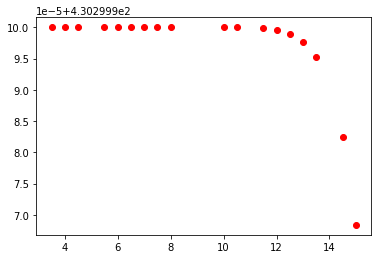

highHIIIIGHHHHHH:  325.0
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  15.5
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10.  10.5 11.5 12.  12.5
 13.  13.5 14.5 15.  15.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999
 430.29999998 430.29999982 430.29999955 430.29999894 430.29999768
 430.29999521 430.29998239 430.29996838 430.29994532]


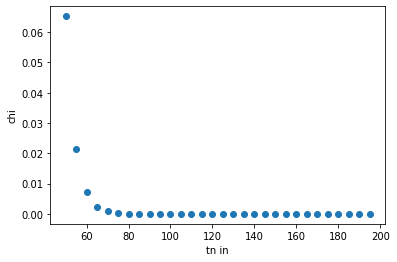

THE RESULT: 159.99999999396772
chisqds:  4.171733415979832e-31
BUT ARE WE SURE?: 3030552.3567869863


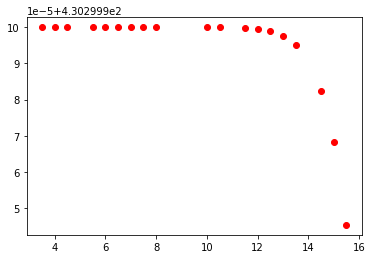

highHIIIIGHHHHHH:  324.5
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  16.0
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10.  10.5 11.5 12.  12.5
 13.  13.5 14.5 15.  15.5 16. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999
 430.29999998 430.29999982 430.29999955 430.29999894 430.29999768
 430.29999521 430.29998239 430.29996838 430.29994532 430.29990864]


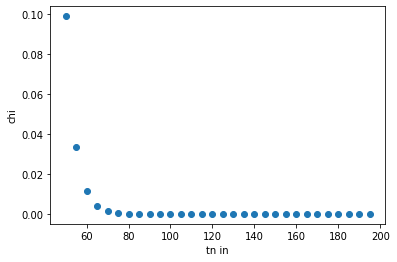

THE RESULT: 160.00000000036354
chisqds:  0.0
BUT ARE WE SURE?: 1824235.3845461842


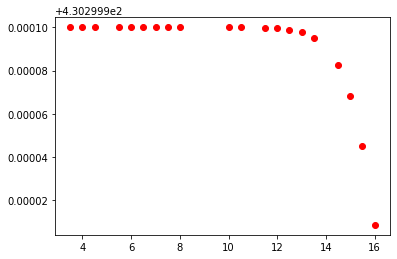

highHIIIIGHHHHHH:  324.0
rewaRD::  -100
stepping:  3
ACTION            :  [0.5]
curtemp:  16.5
Temperature:  [ 3.5  4.   4.5  5.5  6.   6.5  7.   7.5  8.  10.  10.5 11.5 12.  12.5
 13.  13.5 14.5 15.  15.5 16.  16.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999999
 430.29999998 430.29999982 430.29999955 430.29999894 430.29999768
 430.29999521 430.29998239 430.29996838 430.29994532 430.29990864
 430.29985202]


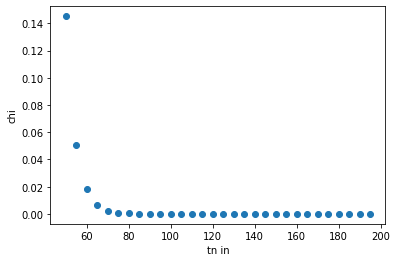

THE RESULT: 159.99999999550525
chisqds:  2.2527364157861963e-30
BUT ARE WE SURE?: 1137220.5645159862


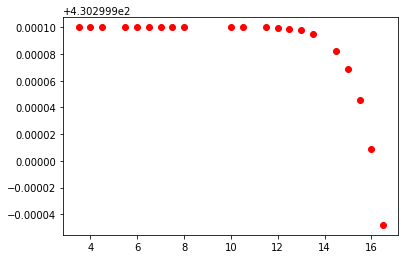

highHIIIIGHHHHHH:  323.5
rewaRD::  -100
terminated: excellent conditions
reset
stepping:  4
ACTION            :  [0.5]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  4.0
Temperature:  [3.5 4. ]
Intensity:  [430.3 430.3]


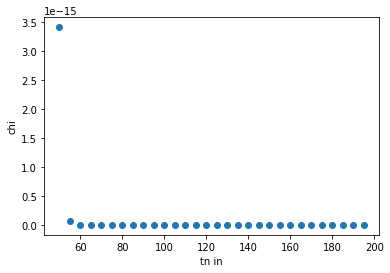

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


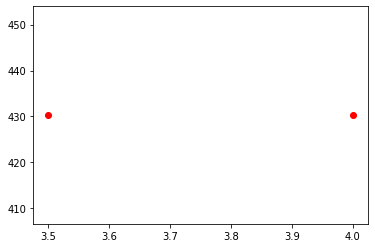

highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  4.5
Temperature:  [3.5 4.  4.5]
Intensity:  [430.3 430.3 430.3]


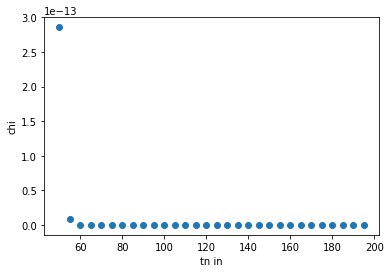

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


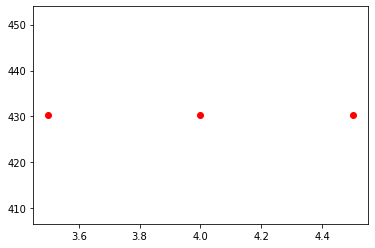

highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  5.0
Temperature:  [3.5 4.  4.5 5. ]
Intensity:  [430.3 430.3 430.3 430.3]


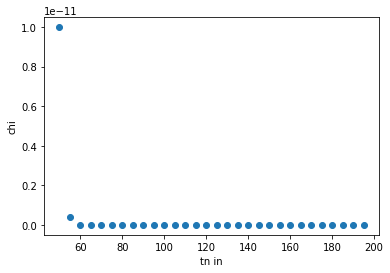

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


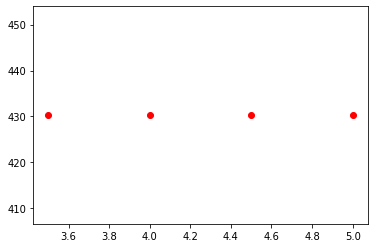

highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  5.5
Temperature:  [3.5 4.  4.5 5.  5.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


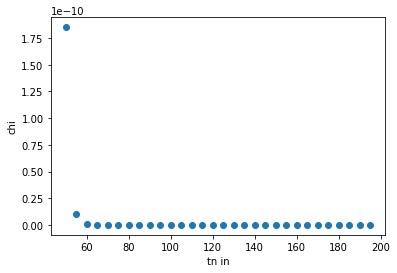

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


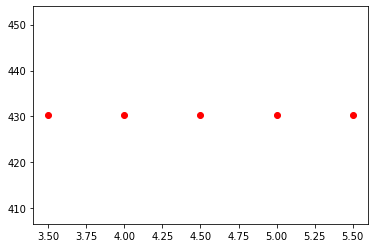

highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  6.0
Temperature:  [3.5 4.  4.5 5.  5.5 6. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


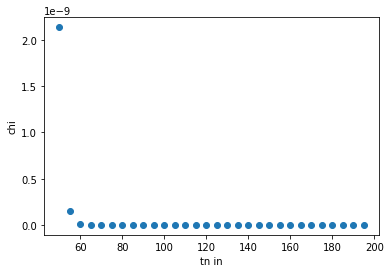

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


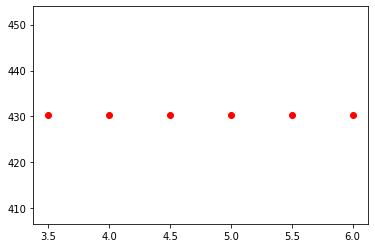

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  6.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3]


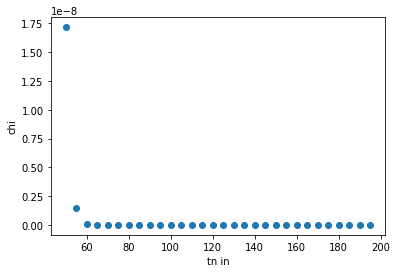

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


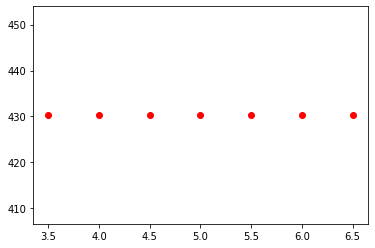

highHIIIIGHHHHHH:  333.5
rewaRD::  -100
stepping:  4
ACTION            :  [0.84201807]
curtemp:  7.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


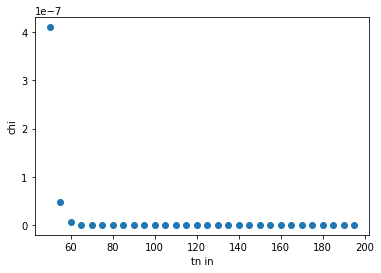

THE RESULT: 195.0
chisqds:  5.674749137340759e-28
BUT ARE WE SURE?: 99999999.99999999


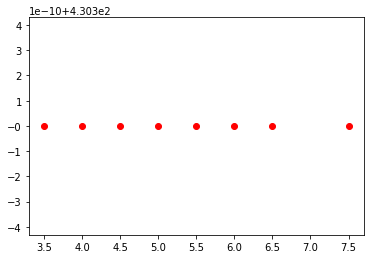

highHIIIIGHHHHHH:  332.5
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  8.0
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.5 8. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


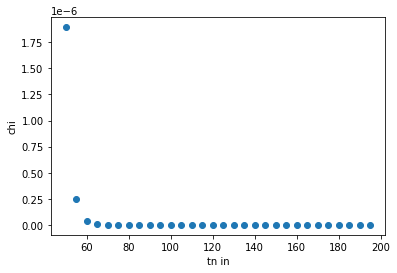

THE RESULT: 195.0
chisqds:  3.6555334028265266e-26
BUT ARE WE SURE?: 99999999.99999999


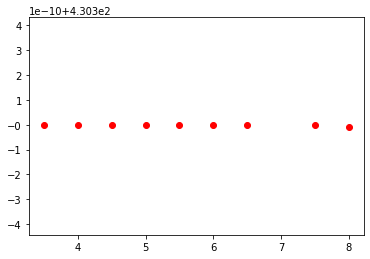

highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  8.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.5 8.  8.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


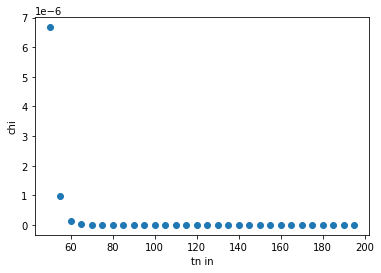

THE RESULT: 170.0984999999971
chisqds:  1.0084714573232177e-24
BUT ARE WE SURE?: 99999999.99999999


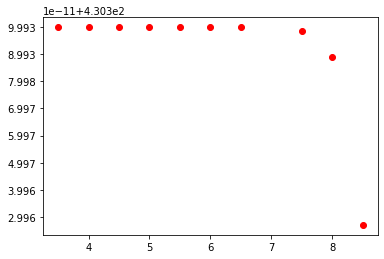

highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  9.0
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.5 8.  8.5 9. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


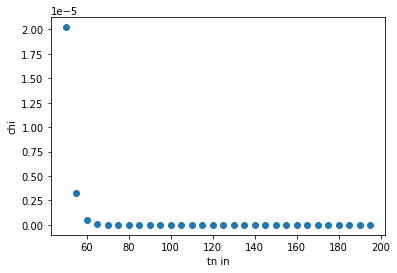

THE RESULT: 160.00017393673943
chisqds:  0.0
BUT ARE WE SURE?: 322395532582.5595


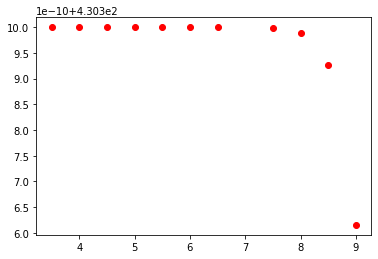

highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  4
ACTION            :  [0.52980953]
curtemp:  9.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.5 8.  8.5 9.  9.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


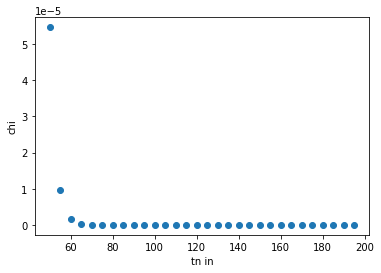

THE RESULT: 159.99995406482773
chisqds:  0.0
BUT ARE WE SURE?: 72040332610.91313


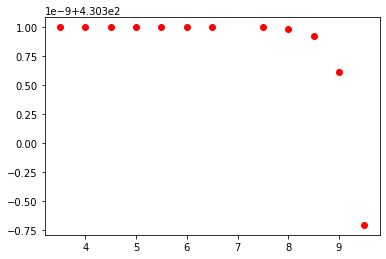

highHIIIIGHHHHHH:  330.5
rewaRD::  -100
stepping:  4
ACTION            :  [0.8824043]
curtemp:  10.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999998]


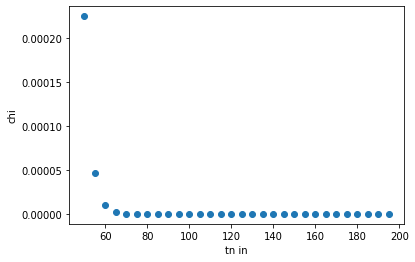

THE RESULT: 159.99999695180537
chisqds:  0.0
BUT ARE WE SURE?: 6234638821.92481


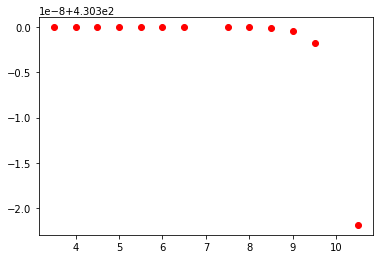

highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  11.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999998 430.29999993]


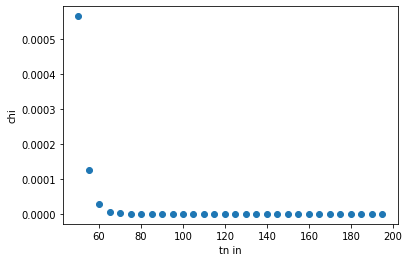

THE RESULT: 159.99999790271193
chisqds:  0.0
BUT ARE WE SURE?: 2054657721.7849195


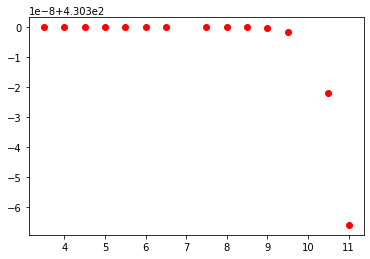

highHIIIIGHHHHHH:  329.0
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  11.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.
 11.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999998 430.29999993 430.29999982]


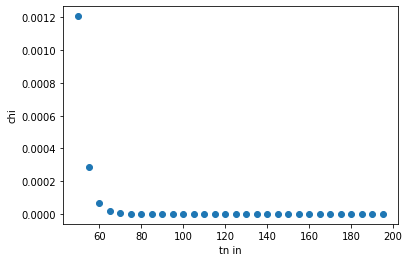

THE RESULT: 159.99999930052368
chisqds:  0.0
BUT ARE WE SURE?: 771156557.8599802


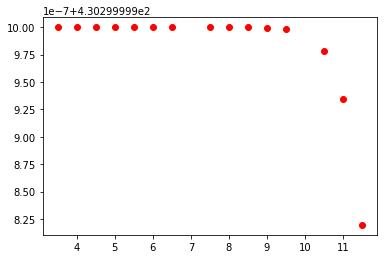

highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  12.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.
 11.5 12. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999998 430.29999993 430.29999982
 430.29999955]


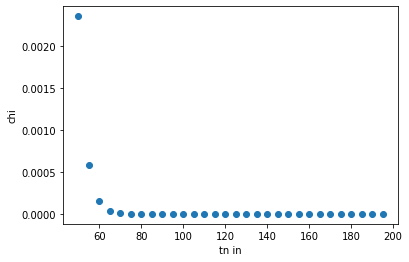

THE RESULT: 159.99999912992644
chisqds:  0.0
BUT ARE WE SURE?: 314988778.7134175


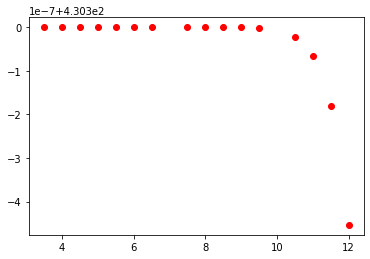

highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  12.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.
 11.5 12.  12.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894]


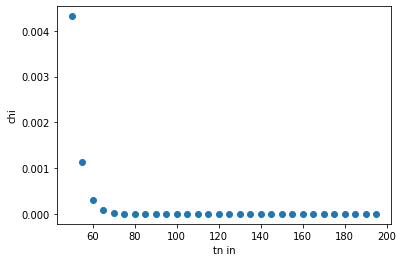

THE RESULT: 159.99999988921707
chisqds:  0.0
BUT ARE WE SURE?: 138213263.0216129


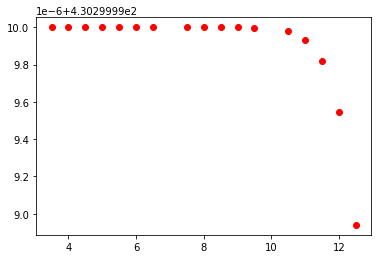

highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  4
ACTION            :  [1.0631788]
curtemp:  13.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.
 11.5 12.  12.5 13.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999521]


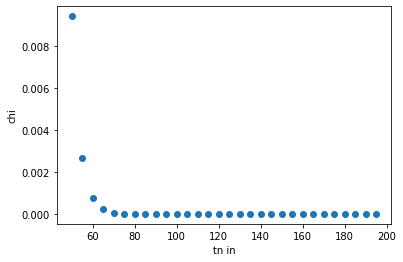

THE RESULT: 159.99999995049623
chisqds:  0.0
BUT ARE WE SURE?: 35499182.09588899


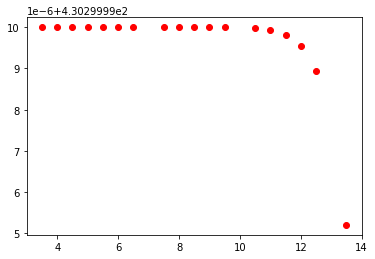

highHIIIIGHHHHHH:  326.5
rewaRD::  -100
stepping:  4
ACTION            :  [0.6746556]
curtemp:  14.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.
 11.5 12.  12.5 13.5 14. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999521 430.2999906 ]


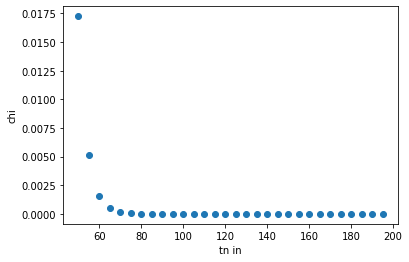

THE RESULT: 160.00000002725514
chisqds:  4.171733249660984e-31
BUT ARE WE SURE?: 17037408.245457392


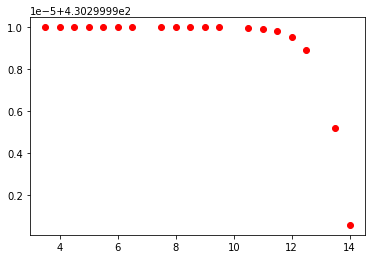

highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  4
ACTION            :  [0.7485117]
curtemp:  14.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.
 11.5 12.  12.5 13.5 14.  14.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999521 430.2999906  430.29998239]


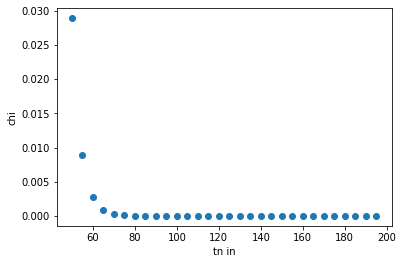

THE RESULT: 160.0000000038551
chisqds:  3.95216834178409e-31
BUT ARE WE SURE?: 9086781.967059398


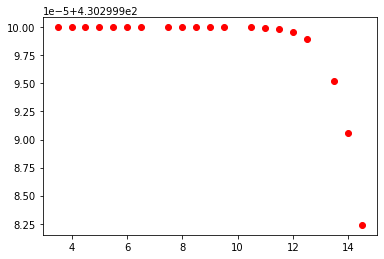

highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  4
ACTION            :  [0.5]
curtemp:  15.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.5  8.   8.5  9.   9.5 10.5 11.
 11.5 12.  12.5 13.5 14.  14.5 15. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999521 430.2999906  430.29998239
 430.29996838]


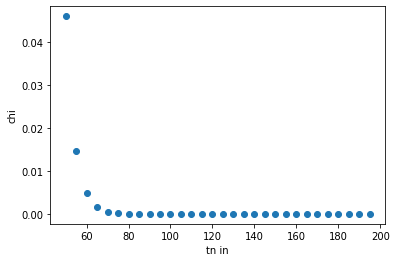

THE RESULT: 159.9999999958949
chisqds:  3.754560074381849e-31
BUT ARE WE SURE?: 5114847.604067822


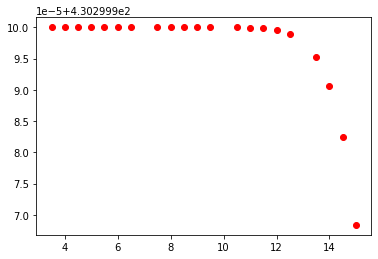

highHIIIIGHHHHHH:  325.0
rewaRD::  -100
terminated: excellent conditions
reset
stepping:  5
ACTION            :  [0.5]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  4.0
Temperature:  [3.5 4. ]
Intensity:  [430.3 430.3]


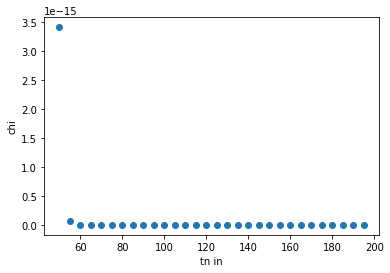

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


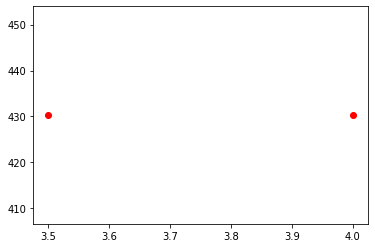

highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  4.5
Temperature:  [3.5 4.  4.5]
Intensity:  [430.3 430.3 430.3]


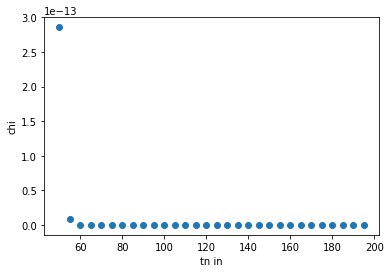

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


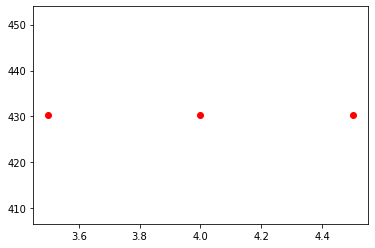

highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  5
ACTION            :  [0.5226296]
curtemp:  5.0
Temperature:  [3.5 4.  4.5 5. ]
Intensity:  [430.3 430.3 430.3 430.3]


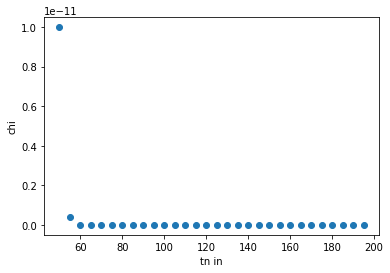

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


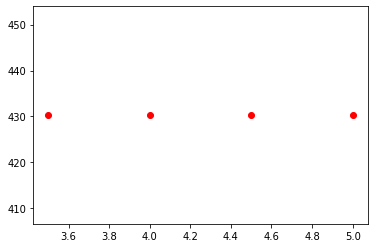

highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  5.5
Temperature:  [3.5 4.  4.5 5.  5.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


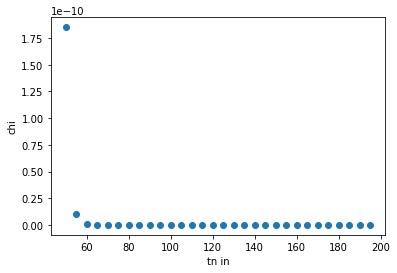

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


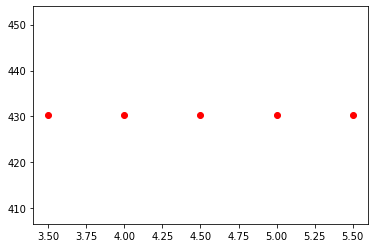

highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  6.0
Temperature:  [3.5 4.  4.5 5.  5.5 6. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


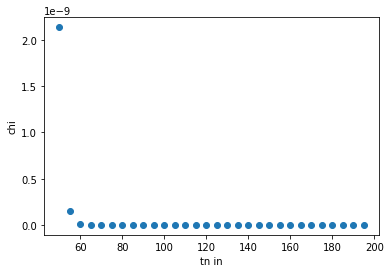

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


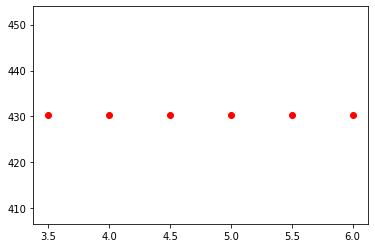

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  6.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3]


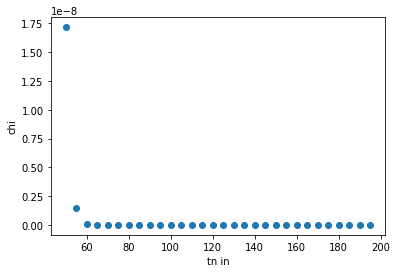

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


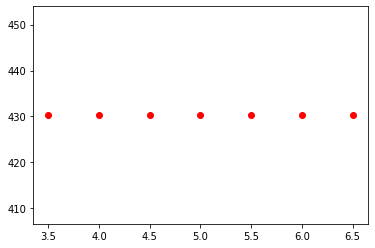

highHIIIIGHHHHHH:  333.5
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  7.0
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


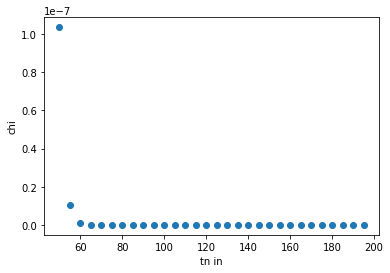

THE RESULT: 195.0
chisqds:  9.654582653320736e-30
BUT ARE WE SURE?: 99999999.99999999


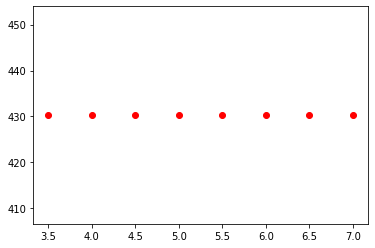

highHIIIIGHHHHHH:  333.0
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  7.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


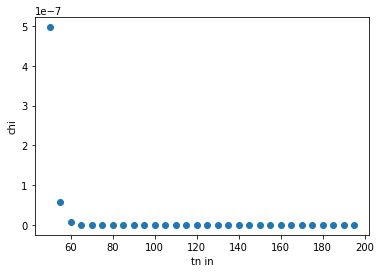

THE RESULT: 195.0
chisqds:  5.04988309338972e-28
BUT ARE WE SURE?: 99999999.99999999


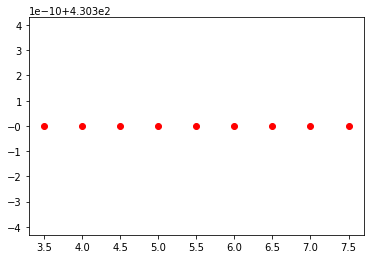

highHIIIIGHHHHHH:  332.5
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  8.0
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


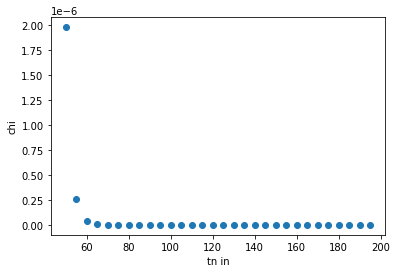

THE RESULT: 195.0
chisqds:  3.250113936718837e-26
BUT ARE WE SURE?: 99999999.99999999


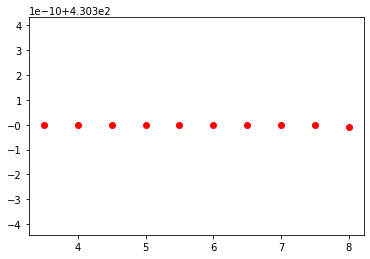

highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  8.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


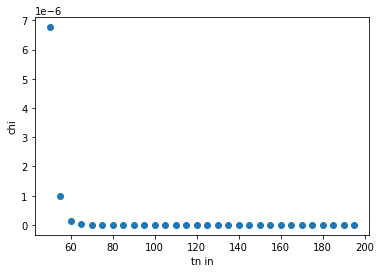

THE RESULT: 170.0984999999971
chisqds:  9.076310697987532e-25
BUT ARE WE SURE?: 99999999.99999999


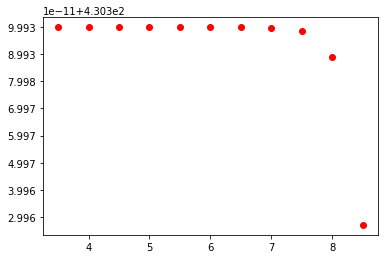

highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  5
ACTION            :  [1.6334581]
curtemp:  10.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5 10. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999]


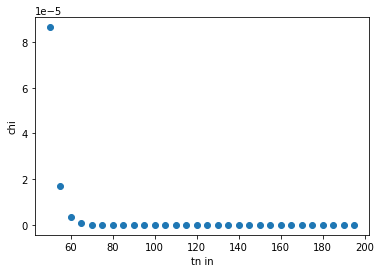

THE RESULT: 160.00002170012021
chisqds:  0.0
BUT ARE WE SURE?: 20064219849.999752


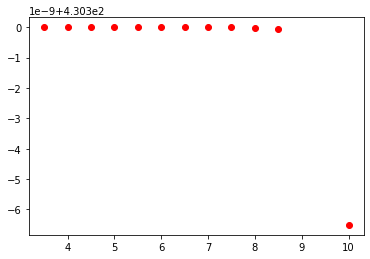

highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  10.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5 10.  10.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998]


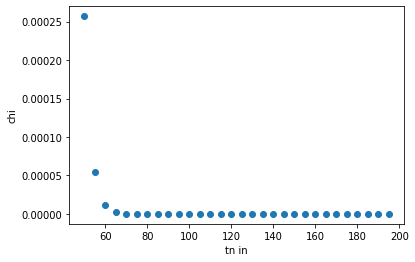

THE RESULT: 159.9999950079388
chisqds:  0.0
BUT ARE WE SURE?: 5980102181.258612


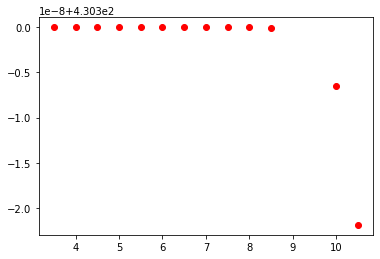

highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  11.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5 10.  10.5 11. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993]


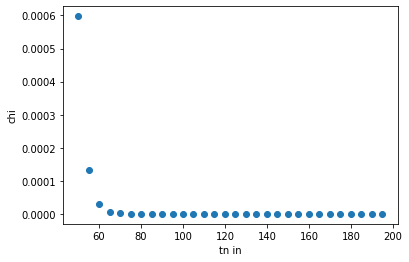

THE RESULT: 159.99999902037652
chisqds:  0.0
BUT ARE WE SURE?: 2044791746.0337737


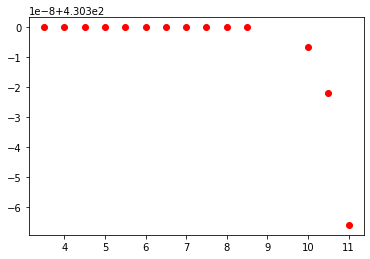

highHIIIIGHHHHHH:  329.0
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  11.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5 10.  10.5 11.
 11.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982]


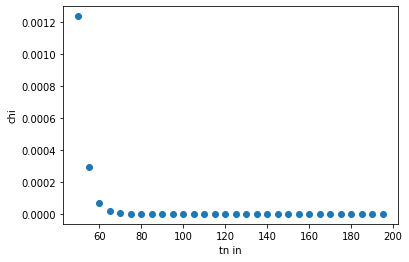

THE RESULT: 159.9999992301006
chisqds:  0.0
BUT ARE WE SURE?: 770631697.8698387


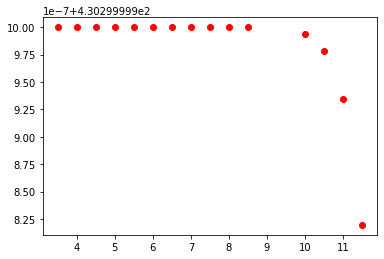

highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  12.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5 10.  10.5 11.
 11.5 12. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955]


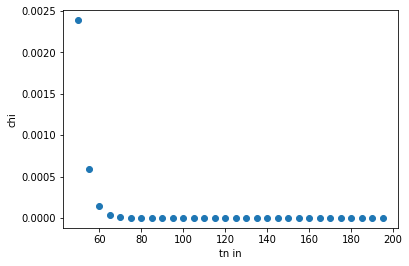

THE RESULT: 159.99999960324504
chisqds:  0.0
BUT ARE WE SURE?: 314918191.29402953


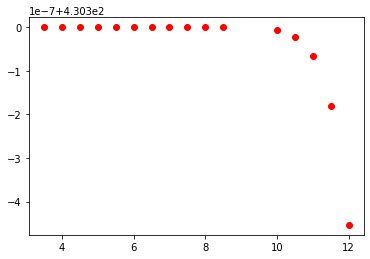

highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  12.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5 10.  10.5 11.
 11.5 12.  12.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894]


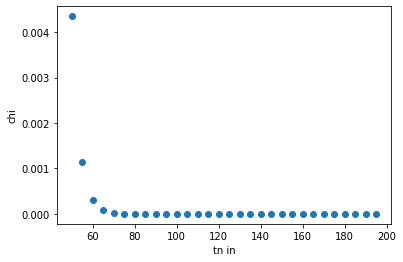

THE RESULT: 159.9999996104714
chisqds:  0.0
BUT ARE WE SURE?: 138214488.6480735


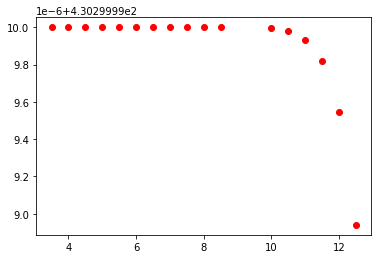

highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  5
ACTION            :  [1.7861158]
curtemp:  14.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5 10.  10.5 11.
 11.5 12.  12.5 14.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29998239]


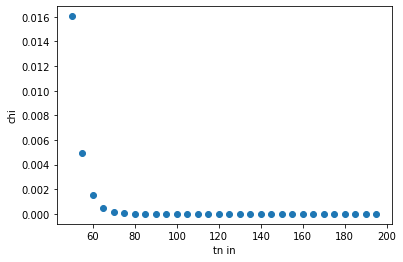

THE RESULT: 160.00000002203566
chisqds:  4.417129323170454e-31
BUT ARE WE SURE?: 10709858.974293208


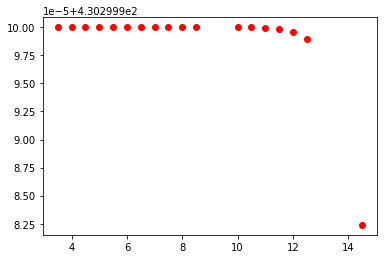

highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  15.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5 10.  10.5 11.
 11.5 12.  12.5 14.5 15. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29998239 430.29996838]


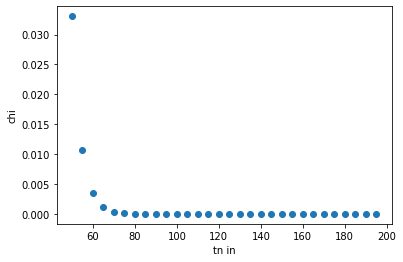

THE RESULT: 159.99999998282988
chisqds:  4.171733415979832e-31
BUT ARE WE SURE?: 5358160.681975211


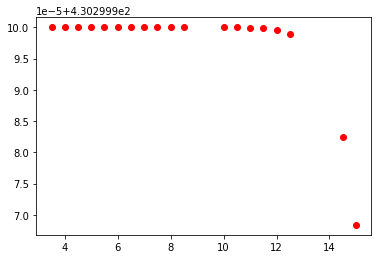

highHIIIIGHHHHHH:  325.0
rewaRD::  -100
stepping:  5
ACTION            :  [0.5]
curtemp:  15.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5 10.  10.5 11.
 11.5 12.  12.5 14.5 15.  15.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29998239 430.29996838 430.29994532]


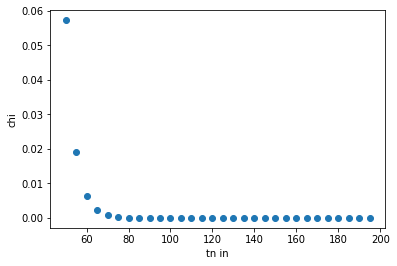

THE RESULT: 159.9999999950494
chisqds:  3.9521684993493145e-31
BUT ARE WE SURE?: 3043552.35884808


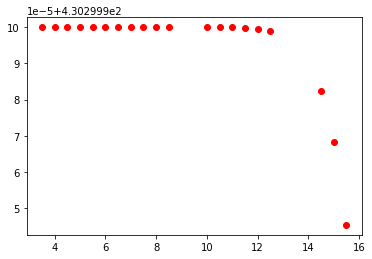

highHIIIIGHHHHHH:  324.5
rewaRD::  -100
stepping:  5
ACTION            :  [1.597168]
curtemp:  17.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5 10.  10.5 11.
 11.5 12.  12.5 14.5 15.  15.5 17. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29998239 430.29996838 430.29994532
 430.29976701]


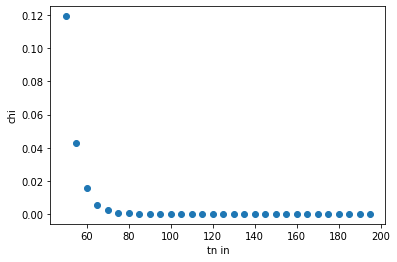

THE RESULT: 159.99999999351905
chisqds:  7.509122028044558e-31
BUT ARE WE SURE?: 908354.9340487185


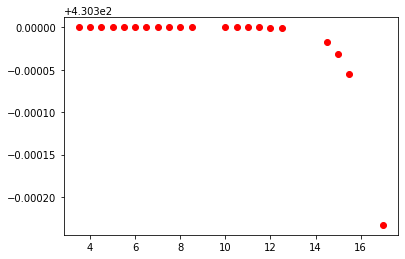

highHIIIIGHHHHHH:  323.0
rewaRD::  -100
terminated: excellent conditions
reset
stepping:  6
ACTION            :  [0.64092886]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  6
ACTION            :  [1.0087036]
curtemp:  4.5
Temperature:  [3.5 4.5]
Intensity:  [430.3 430.3]


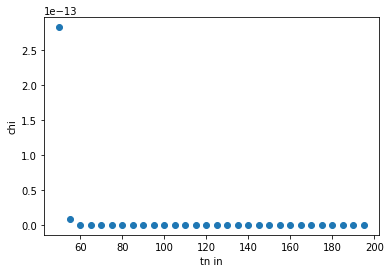

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


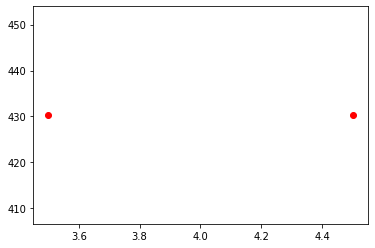

highHIIIIGHHHHHH:  335.5
rewaRD::  -100
--------------------------------------
| approxkl           | 5.9866914e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 21            |
| ep_reward_mean     | -2.1e+03      |
| explained_variance | 0             |
| fps                | 2             |
| n_updates          | 1             |
| policy_entropy     | 1.4185418     |
| policy_loss        | -0.0008794649 |
| serial_timesteps   | 128           |
| time_elapsed       | 2.65e-05      |
| total_timesteps    | 128           |
| value_loss         | 342991.28     |
--------------------------------------
stepping:  6
ACTION            :  [0.5]
curtemp:  5.0
Temperature:  [3.5 4.5 5. ]
Intensity:  [430.3 430.3 430.3]


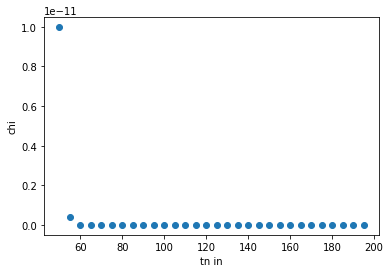

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


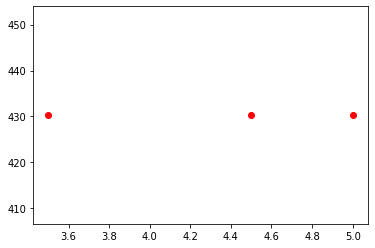

highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  6
ACTION            :  [1.0935439]
curtemp:  6.0
Temperature:  [3.5 4.5 5.  6. ]
Intensity:  [430.3 430.3 430.3 430.3]


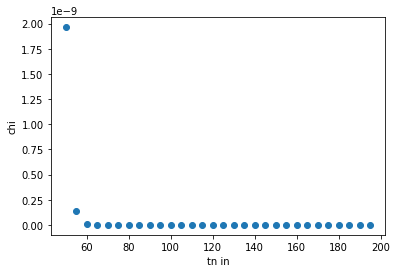

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


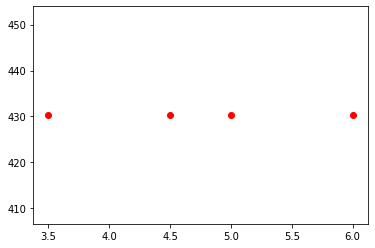

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  6
ACTION            :  [0.79353726]
curtemp:  7.0
Temperature:  [3.5 4.5 5.  6.  7. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


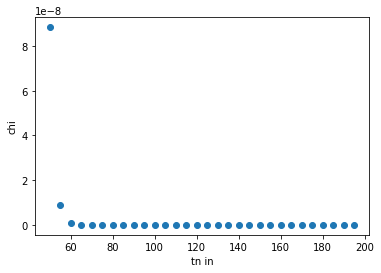

THE RESULT: 195.0
chisqds:  1.6895519643311287e-29
BUT ARE WE SURE?: 99999999.99999999


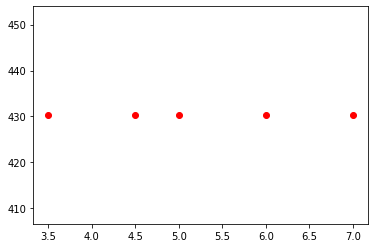

highHIIIIGHHHHHH:  333.0
rewaRD::  -100
stepping:  6
ACTION            :  [1.2070571]
curtemp:  8.0
Temperature:  [3.5 4.5 5.  6.  7.  8. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


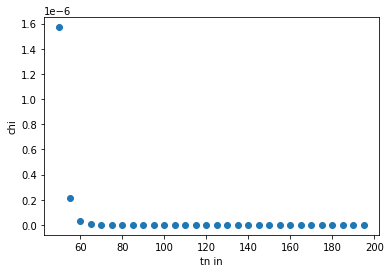

THE RESULT: 195.0
chisqds:  5.770758598171137e-26
BUT ARE WE SURE?: 99999999.99999999


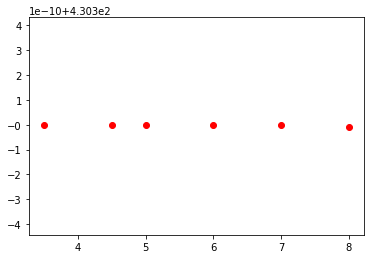

highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  6
ACTION            :  [0.5]
curtemp:  8.5
Temperature:  [3.5 4.5 5.  6.  7.  8.  8.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3]


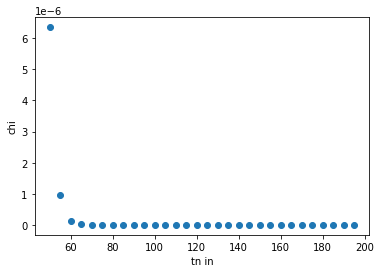

THE RESULT: 170.0984999999971
chisqds:  1.5122178416751573e-24
BUT ARE WE SURE?: 99999999.99999999


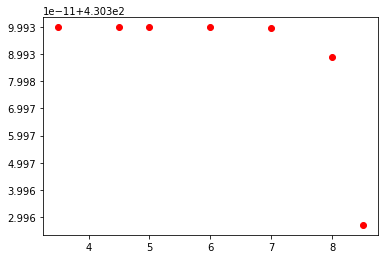

highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  6
ACTION            :  [0.5]
curtemp:  9.0
Temperature:  [3.5 4.5 5.  6.  7.  8.  8.5 9. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


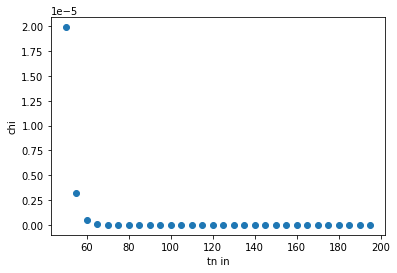

THE RESULT: 160.00000389354074
chisqds:  0.0
BUT ARE WE SURE?: 322395189950.6345


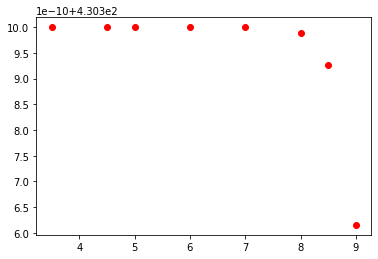

highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  6
ACTION            :  [0.5]
curtemp:  9.5
Temperature:  [3.5 4.5 5.  6.  7.  8.  8.5 9.  9.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


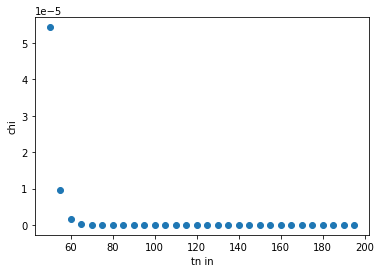

THE RESULT: 159.99995406482773
chisqds:  0.0
BUT ARE WE SURE?: 72040332610.91313


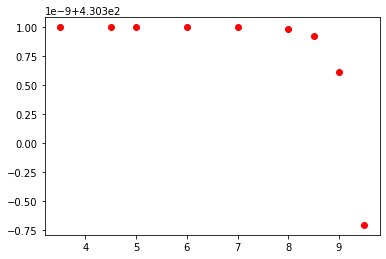

highHIIIIGHHHHHH:  330.5
rewaRD::  -100
stepping:  6
ACTION            :  [0.9270442]
curtemp:  10.5
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998]


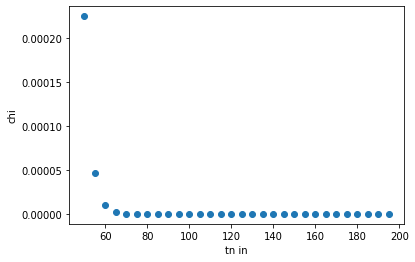

THE RESULT: 159.99999695180537
chisqds:  0.0
BUT ARE WE SURE?: 6234638821.92481


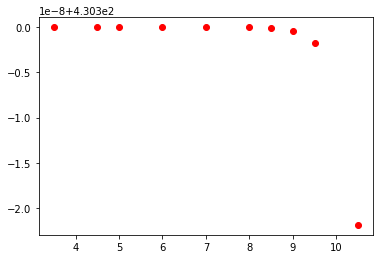

highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  6
ACTION            :  [0.719364]
curtemp:  11.0
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5 11. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999993]


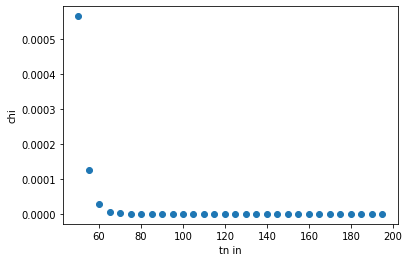

THE RESULT: 159.99999792518219
chisqds:  0.0
BUT ARE WE SURE?: 2054657722.073474


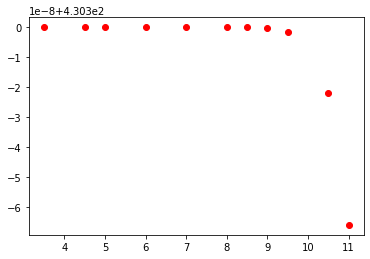

highHIIIIGHHHHHH:  329.0
rewaRD::  -100
stepping:  6
ACTION            :  [0.5]
curtemp:  11.5
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5 11.  11.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999993 430.29999982]


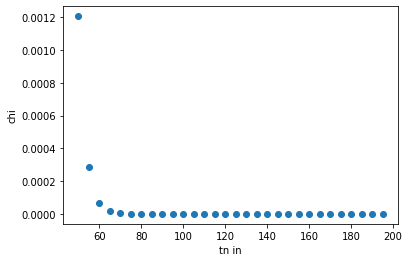

THE RESULT: 159.99999930052368
chisqds:  0.0
BUT ARE WE SURE?: 771156557.8599802


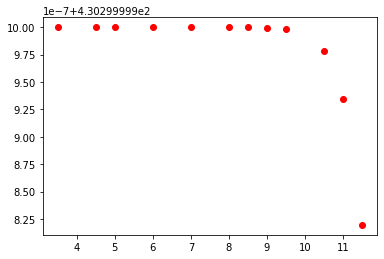

highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  6
ACTION            :  [0.5]
curtemp:  12.0
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5 11.  11.5 12. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999993 430.29999982 430.29999955]


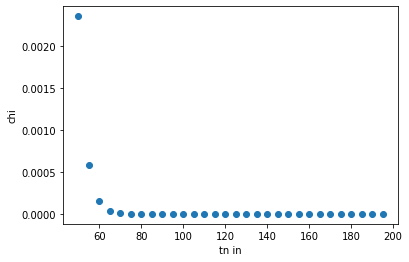

THE RESULT: 159.99999972057728
chisqds:  0.0
BUT ARE WE SURE?: 314953978.6115105


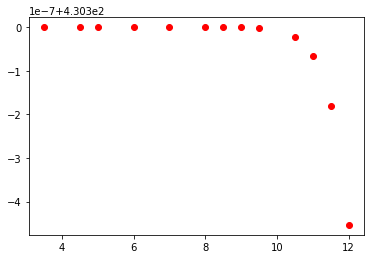

highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  6
ACTION            :  [0.8466425]
curtemp:  13.0
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5 11.  11.5 12.  13. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999993 430.29999982 430.29999955 430.29999768]


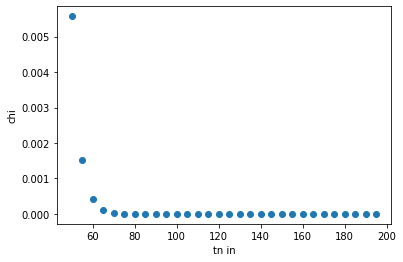

THE RESULT: 159.99999975648103
chisqds:  2.3104984252241473e-30
BUT ARE WE SURE?: 71179905.0331269


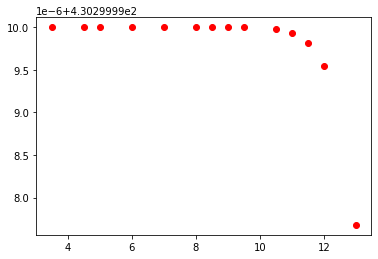

highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  6
ACTION            :  [1.5982714]
curtemp:  14.5
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5 11.  11.5 12.  13.
 14.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999993 430.29999982 430.29999955 430.29999768 430.29998239]


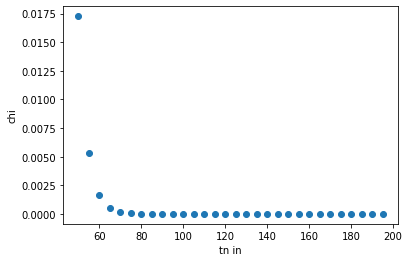

THE RESULT: 159.99999999020108
chisqds:  5.363657249116927e-31
BUT ARE WE SURE?: 10621892.835816618


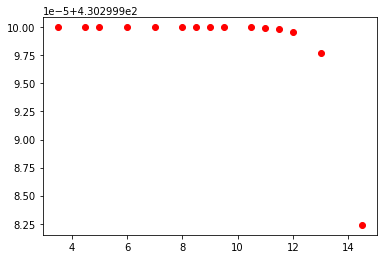

highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  6
ACTION            :  [0.5]
curtemp:  15.0
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5 11.  11.5 12.  13.
 14.5 15. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999993 430.29999982 430.29999955 430.29999768 430.29998239
 430.29996838]


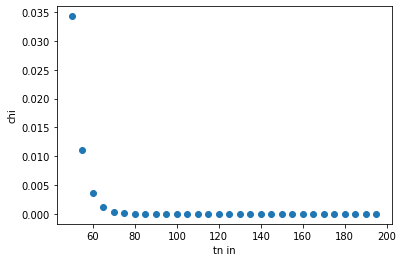

THE RESULT: 159.99999999618024
chisqds:  5.0060800991757985e-31
BUT ARE WE SURE?: 5347041.831650664


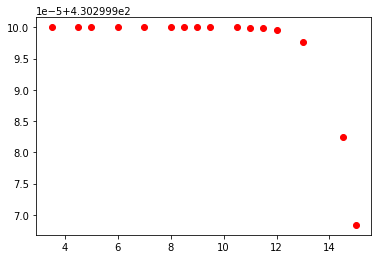

highHIIIIGHHHHHH:  325.0
rewaRD::  -100
stepping:  6
ACTION            :  [0.5]
curtemp:  15.5
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5 11.  11.5 12.  13.
 14.5 15.  15.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999993 430.29999982 430.29999955 430.29999768 430.29998239
 430.29996838 430.29994532]


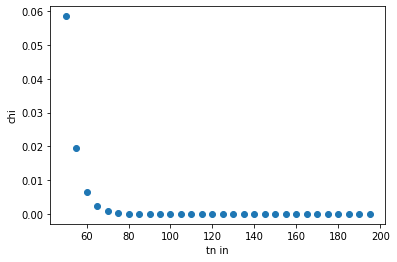

THE RESULT: 159.99999998468428
chisqds:  2.3466002081982396e-30
BUT ARE WE SURE?: 3041510.839737728


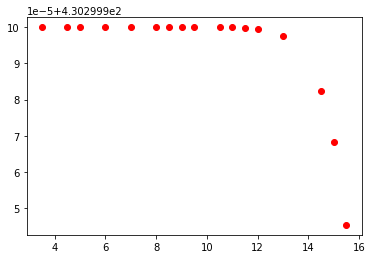

highHIIIIGHHHHHH:  324.5
rewaRD::  -100
stepping:  6
ACTION            :  [0.82871926]
curtemp:  16.5
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5 11.  11.5 12.  13.
 14.5 15.  15.5 16.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999993 430.29999982 430.29999955 430.29999768 430.29998239
 430.29996838 430.29994532 430.29985202]


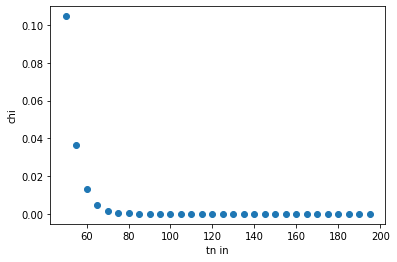

THE RESULT: 159.9999999949389
chisqds:  8.834260336836992e-31
BUT ARE WE SURE?: 1312117.910104018


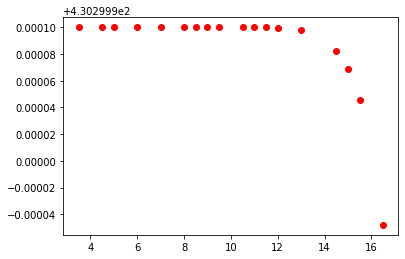

highHIIIIGHHHHHH:  323.5
rewaRD::  -100
stepping:  6
ACTION            :  [0.5]
curtemp:  17.0
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5 11.  11.5 12.  13.
 14.5 15.  15.5 16.5 17. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999993 430.29999982 430.29999955 430.29999768 430.29998239
 430.29996838 430.29994532 430.29985202 430.29976701]


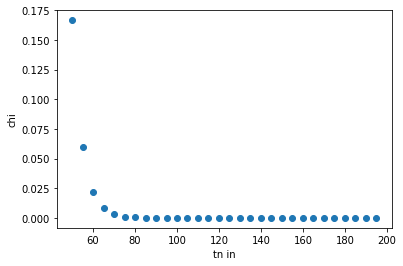

THE RESULT: 159.99999999786544
chisqds:  4.171733415979832e-31
BUT ARE WE SURE?: 770406.5396878301


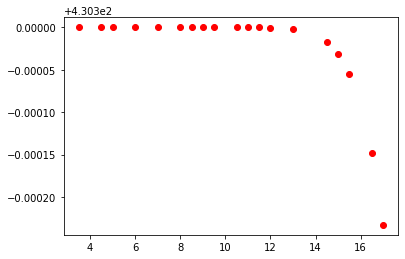

highHIIIIGHHHHHH:  323.0
rewaRD::  -100
stepping:  6
ACTION            :  [0.55879164]
curtemp:  17.5
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5 11.  11.5 12.  13.
 14.5 15.  15.5 16.5 17.  17.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999993 430.29999982 430.29999955 430.29999768 430.29998239
 430.29996838 430.29994532 430.29985202 430.29976701 430.29964256]


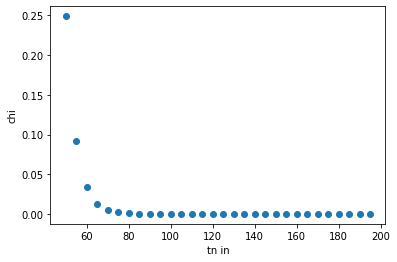

THE RESULT: 159.99999999904455
chisqds:  1.9760854981615987e-30
BUT ARE WE SURE?: 491651.6046279251


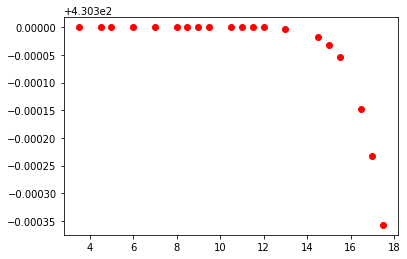

highHIIIIGHHHHHH:  322.5
rewaRD::  -100
stepping:  6
ACTION            :  [0.5]
curtemp:  18.0
Temperature:  [ 3.5  4.5  5.   6.   7.   8.   8.5  9.   9.5 10.5 11.  11.5 12.  13.
 14.5 15.  15.5 16.5 17.  17.5 18. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.3        430.29999998
 430.29999993 430.29999982 430.29999955 430.29999768 430.29998239
 430.29996838 430.29994532 430.29985202 430.29976701 430.29964256
 430.29946452]


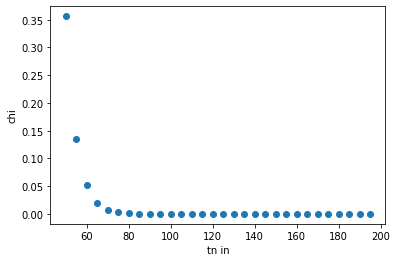

THE RESULT: 159.99999999980136
chisqds:  1.5018252158153337e-30
BUT ARE WE SURE?: 327225.5626941371


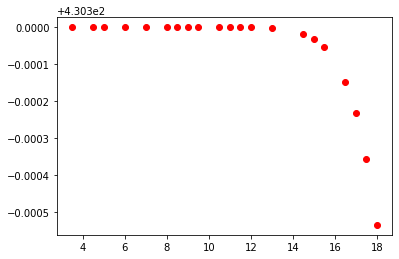

highHIIIIGHHHHHH:  322.0
rewaRD::  -100
terminated: excellent conditions
reset
stepping:  7
ACTION            :  [2.1647344]
curtemp:  5.0
Temperature:  [5.]
highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  7
ACTION            :  [0.94755155]
curtemp:  6.0
Temperature:  [5. 6.]
Intensity:  [430.3 430.3]


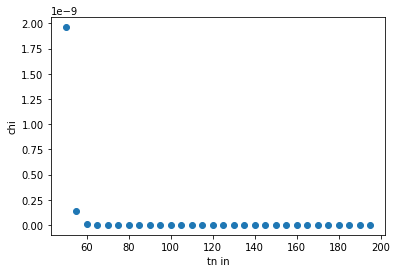

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


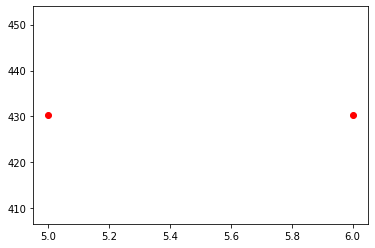

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  7
ACTION            :  [1.291787]
curtemp:  7.5
Temperature:  [5.  6.  7.5]
Intensity:  [430.3 430.3 430.3]


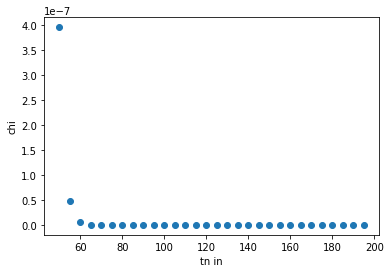

THE RESULT: 195.0
chisqds:  1.9861621980692655e-27
BUT ARE WE SURE?: 99999999.99999999


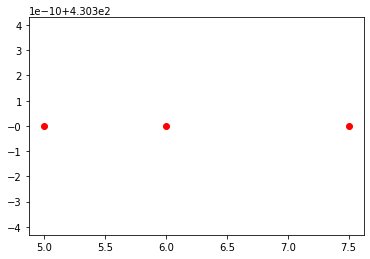

highHIIIIGHHHHHH:  332.5
rewaRD::  -100
stepping:  7
ACTION            :  [0.5]
curtemp:  8.0
Temperature:  [5.  6.  7.5 8. ]
Intensity:  [430.3 430.3 430.3 430.3]


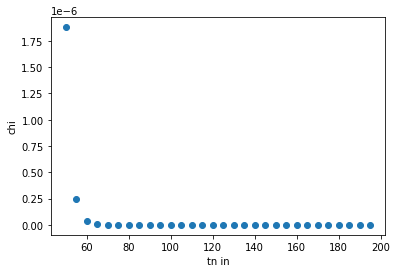

THE RESULT: 195.0
chisqds:  9.748089074204071e-26
BUT ARE WE SURE?: 99999999.99999999


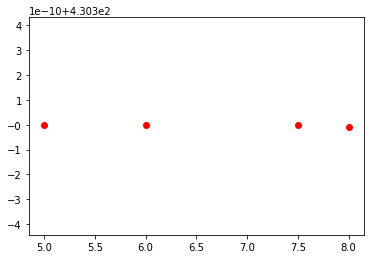

highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  7
ACTION            :  [0.5]
curtemp:  8.5
Temperature:  [5.  6.  7.5 8.  8.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


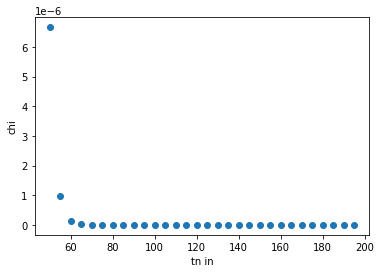

THE RESULT: 170.0984999999971
chisqds:  2.2690607789772396e-24
BUT ARE WE SURE?: 99999999.99999999


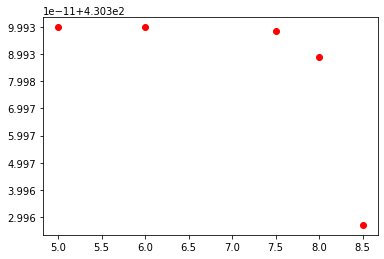

highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  7
ACTION            :  [0.52601826]
curtemp:  9.0
Temperature:  [5.  6.  7.5 8.  8.5 9. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


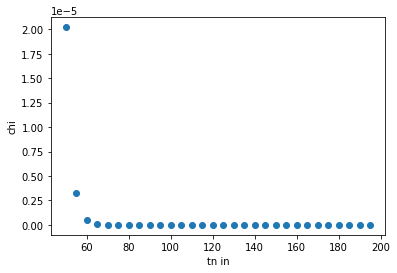

THE RESULT: 160.00017324127703
chisqds:  0.0
BUT ARE WE SURE?: 322395531181.2237


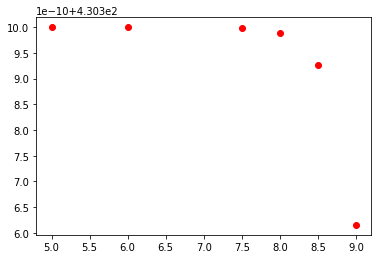

highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  7
ACTION            :  [0.87965584]
curtemp:  10.0
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999]


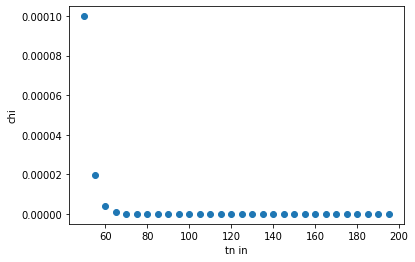

THE RESULT: 160.00003929093862
chisqds:  0.0
BUT ARE WE SURE?: 20025949555.293747


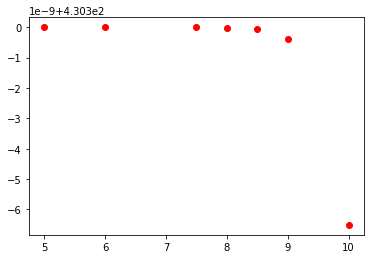

highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  7
ACTION            :  [0.5]
curtemp:  10.5
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998]


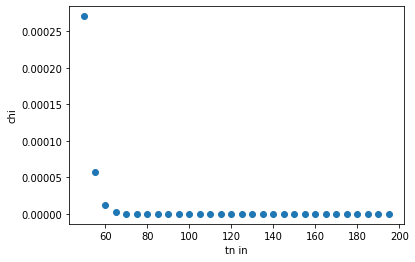

THE RESULT: 160.0000027371531
chisqds:  0.0
BUT ARE WE SURE?: 5973248478.663004


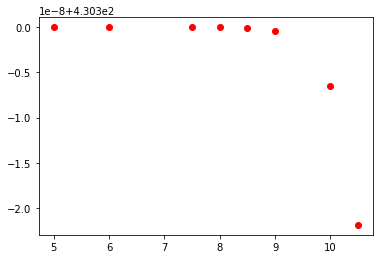

highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  7
ACTION            :  [0.5]
curtemp:  11.0
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993]


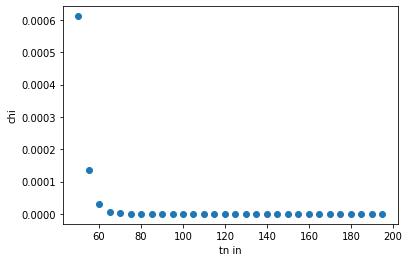

THE RESULT: 159.99999780953195
chisqds:  0.0
BUT ARE WE SURE?: 2044751105.0896401


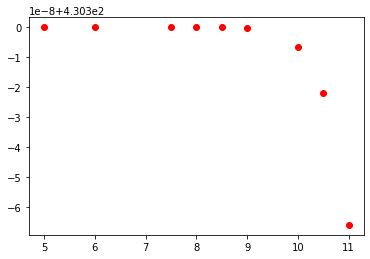

highHIIIIGHHHHHH:  329.0
rewaRD::  -100
stepping:  7
ACTION            :  [0.70561814]
curtemp:  11.5
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982]


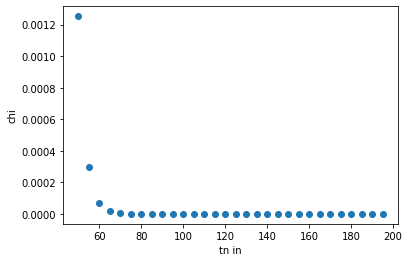

THE RESULT: 160.00000061350838
chisqds:  0.0
BUT ARE WE SURE?: 770629529.8153964


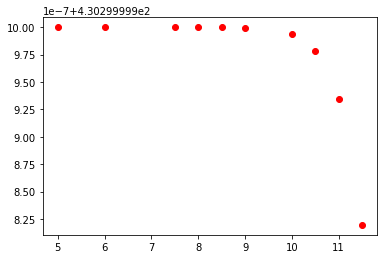

highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  7
ACTION            :  [0.5]
curtemp:  12.0
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955]


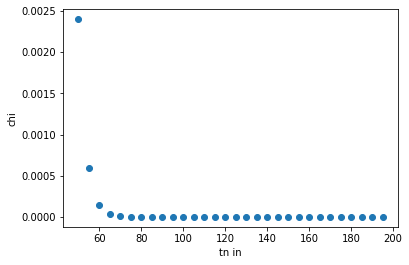

THE RESULT: 159.99999977878412
chisqds:  0.0
BUT ARE WE SURE?: 314918044.7818505


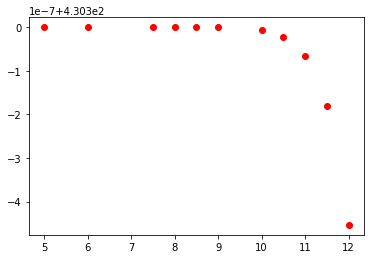

highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  7
ACTION            :  [0.5853882]
curtemp:  12.5
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12.  12.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894]


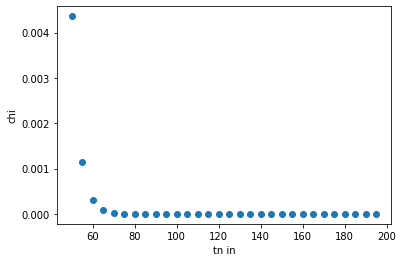

THE RESULT: 159.99999971744154
chisqds:  0.0
BUT ARE WE SURE?: 138210225.54655373


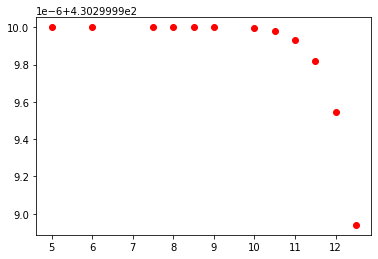

highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  7
ACTION            :  [0.5]
curtemp:  13.0
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12.  12.5 13. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999768]


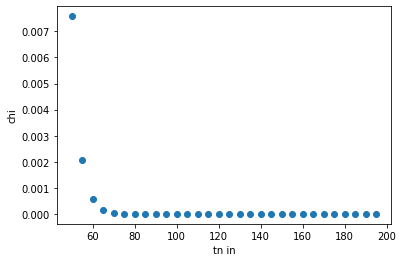

THE RESULT: 159.99999986662348
chisqds:  2.503039960659493e-30
BUT ARE WE SURE?: 64596637.158663064


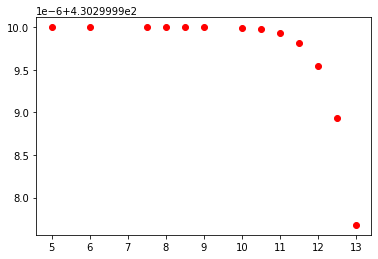

highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  7
ACTION            :  [1.5178208]
curtemp:  14.5
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12.  12.5 13.  14.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999768 430.29998239]


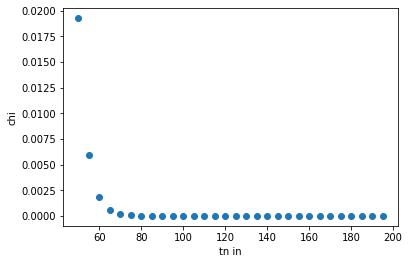

THE RESULT: 160.0000000139034
chisqds:  5.776246037992132e-31
BUT ARE WE SURE?: 10596636.653287875


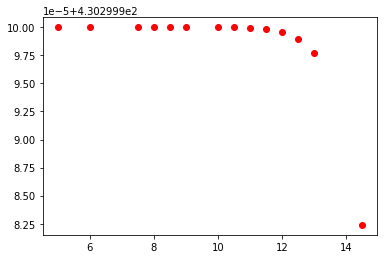

highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  7
ACTION            :  [0.5]
curtemp:  15.0
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12.  12.5 13.  14.5
 15. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999768 430.29998239 430.29996838]


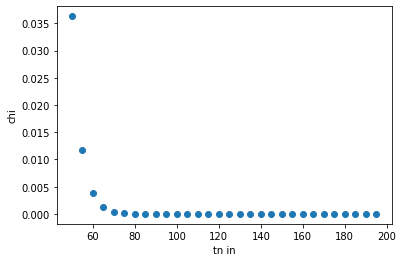

THE RESULT: 159.99999998247745
chisqds:  5.363657249116927e-31
BUT ARE WE SURE?: 5343812.051109702


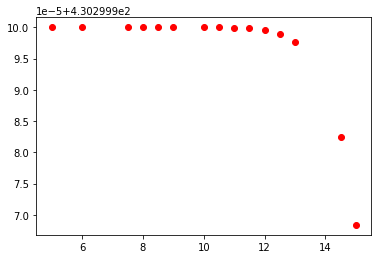

highHIIIIGHHHHHH:  325.0
rewaRD::  -100
stepping:  7
ACTION            :  [0.7920175]
curtemp:  16.0
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12.  12.5 13.  14.5
 15.  16. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999768 430.29998239 430.29996838
 430.29990864]


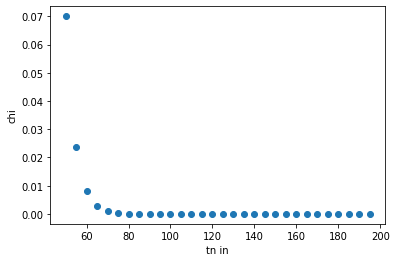

THE RESULT: 159.99999999795904
chisqds:  2.5030403927909826e-30
BUT ARE WE SURE?: 2100581.883080352


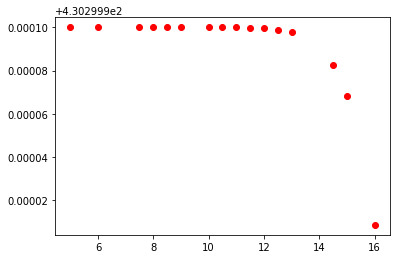

highHIIIIGHHHHHH:  324.0
rewaRD::  -100
stepping:  7
ACTION            :  [1.6154636]
curtemp:  17.5
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12.  12.5 13.  14.5
 15.  16.  17.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999768 430.29998239 430.29996838
 430.29990864 430.29964256]


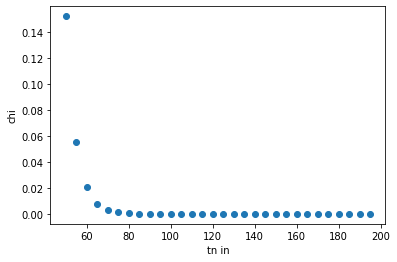

THE RESULT: 160.00000000036414
chisqds:  0.0
BUT ARE WE SURE?: 610986.1744933148


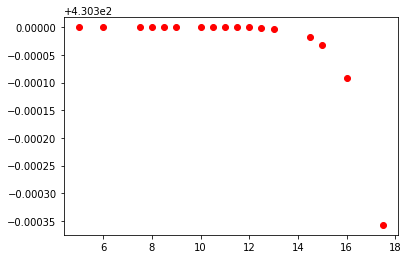

highHIIIIGHHHHHH:  322.5
rewaRD::  -100
stepping:  7
ACTION            :  [0.5]
curtemp:  18.0
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12.  12.5 13.  14.5
 15.  16.  17.5 18. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999768 430.29998239 430.29996838
 430.29990864 430.29964256 430.29946452]


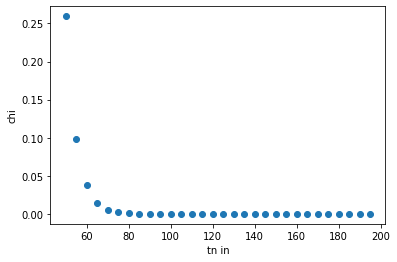

THE RESULT: 160.0000000012479
chisqds:  1.7668518572399996e-30
BUT ARE WE SURE?: 356214.9435967049


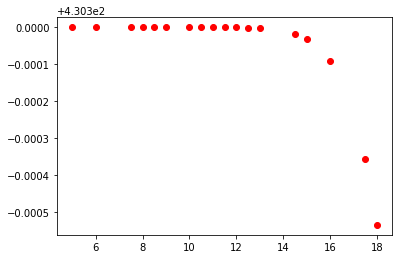

highHIIIIGHHHHHH:  322.0
rewaRD::  -100
stepping:  7
ACTION            :  [0.5]
curtemp:  18.5
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12.  12.5 13.  14.5
 15.  16.  17.5 18.  18.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999768 430.29998239 430.29996838
 430.29990864 430.29964256 430.29946452 430.29921514]


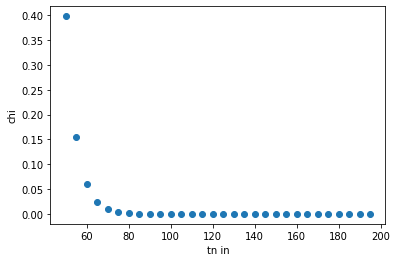

THE RESULT: 159.99999999968088
chisqds:  3.3373910260241814e-30
BUT ARE WE SURE?: 232737.9962188636


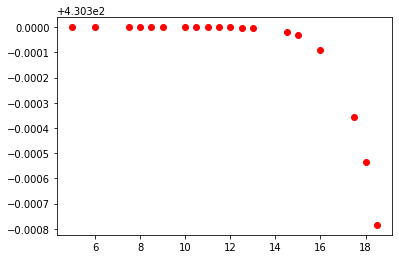

highHIIIIGHHHHHH:  321.5
rewaRD::  -100
stepping:  7
ACTION            :  [0.5]
curtemp:  19.0
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12.  12.5 13.  14.5
 15.  16.  17.5 18.  18.5 19. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999768 430.29998239 430.29996838
 430.29990864 430.29964256 430.29946452 430.29921514 430.29887253]


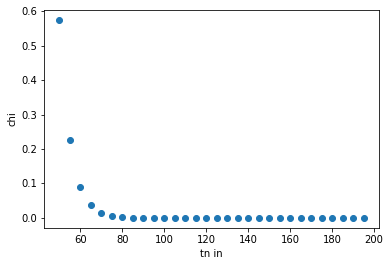

THE RESULT: 159.99999999966104
chisqds:  3.5569567360738785e-30
BUT ARE WE SURE?: 159795.56285211202


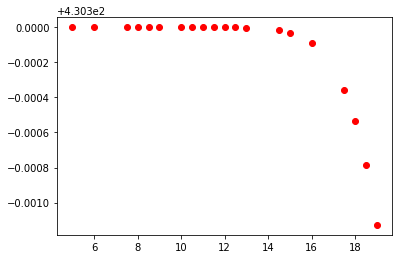

highHIIIIGHHHHHH:  321.0
rewaRD::  -100
stepping:  7
ACTION            :  [0.5631364]
curtemp:  19.5
Temperature:  [ 5.   6.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12.  12.5 13.  14.5
 15.  16.  17.5 18.  18.5 19.  19.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999993 430.29999982
 430.29999955 430.29999894 430.29999768 430.29998239 430.29996838
 430.29990864 430.29964256 430.29946452 430.29921514 430.29887253
 430.29841016]


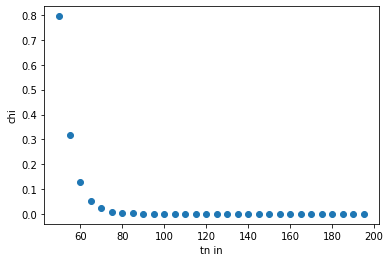

THE RESULT: 160.00000000015666
chisqds:  0.0
BUT ARE WE SURE?: 113052.47583724167


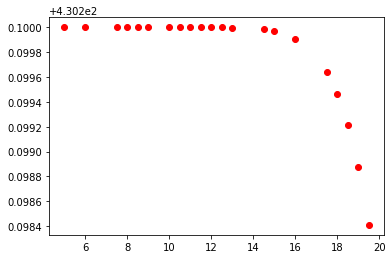

highHIIIIGHHHHHH:  320.5
rewaRD::  -100
terminated: excellent conditions
reset
stepping:  8
ACTION            :  [0.5]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  8
ACTION            :  [0.67778796]
curtemp:  4.0
Temperature:  [3.5 4. ]
Intensity:  [430.3 430.3]


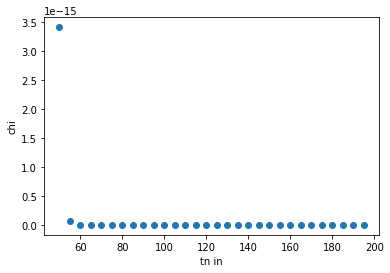

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


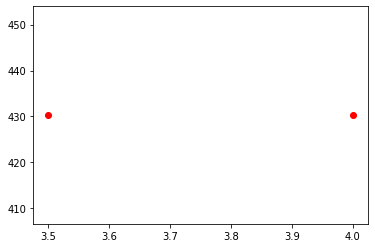

highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  8
ACTION            :  [1.3519437]
curtemp:  5.5
Temperature:  [3.5 4.  5.5]
Intensity:  [430.3 430.3 430.3]


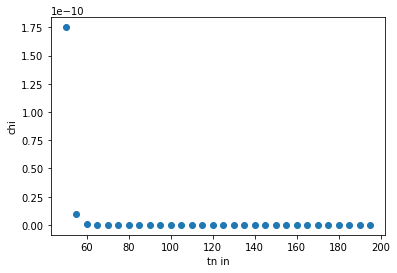

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


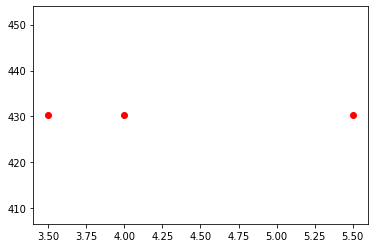

highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  8
ACTION            :  [0.5]
curtemp:  6.0
Temperature:  [3.5 4.  5.5 6. ]
Intensity:  [430.3 430.3 430.3 430.3]


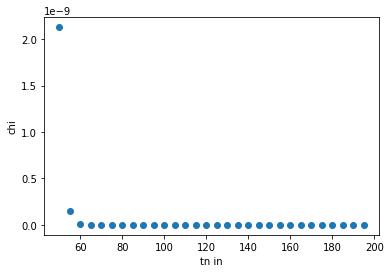

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


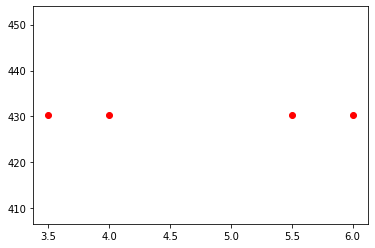

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  8
ACTION            :  [0.5]
curtemp:  6.5
Temperature:  [3.5 4.  5.5 6.  6.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


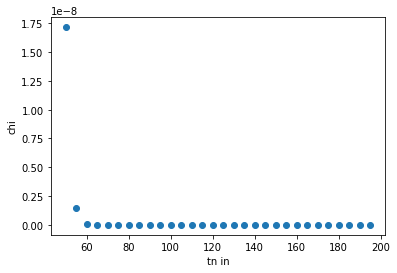

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


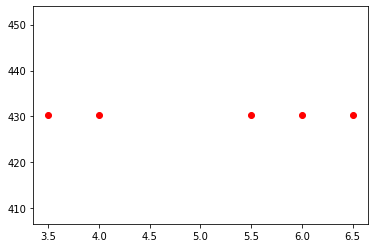

highHIIIIGHHHHHH:  333.5
rewaRD::  -100
stepping:  8
ACTION            :  [2.0036514]
curtemp:  8.5
Temperature:  [3.5 4.  5.5 6.  6.5 8.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


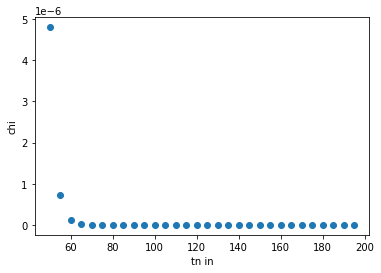

THE RESULT: 170.0984999999971
chisqds:  1.7712451809107666e-24
BUT ARE WE SURE?: 99999999.99999999


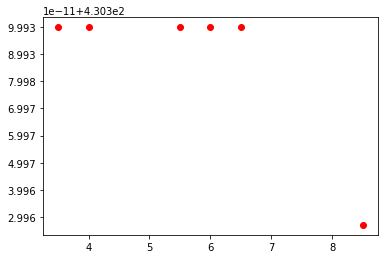

highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  8
ACTION            :  [1.7251989]
curtemp:  10.0
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999]


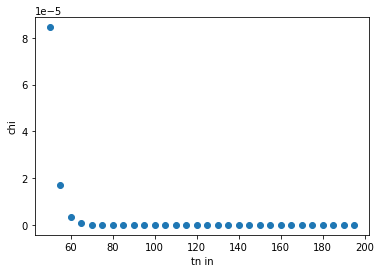

THE RESULT: 160.00002360855237
chisqds:  0.0
BUT ARE WE SURE?: 20064220089.319736


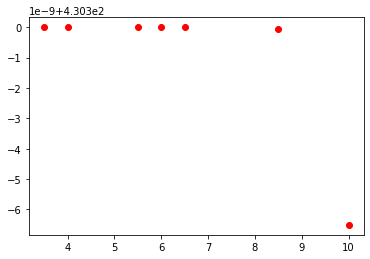

highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  8
ACTION            :  [0.5]
curtemp:  10.5
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998]


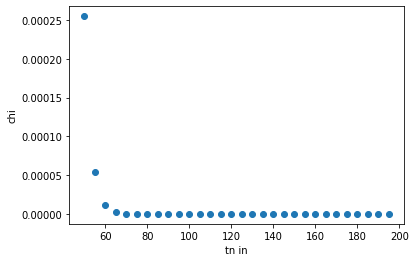

THE RESULT: 159.9999950079388
chisqds:  0.0
BUT ARE WE SURE?: 5980102181.258612


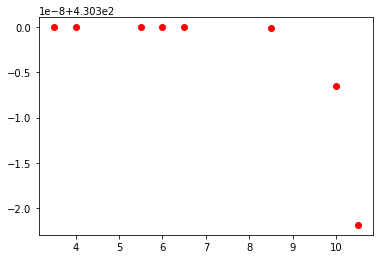

highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  8
ACTION            :  [1.2306542]
curtemp:  11.5
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982]


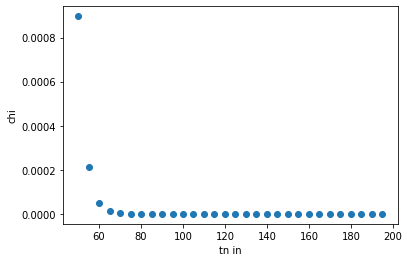

THE RESULT: 160.00000124659147
chisqds:  0.0
BUT ARE WE SURE?: 824026499.8539392


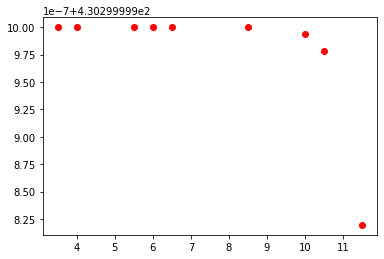

highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  8
ACTION            :  [0.6225477]
curtemp:  12.0
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955]


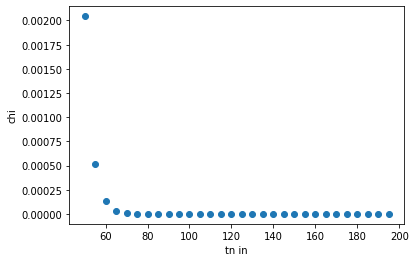

THE RESULT: 159.99999919312307
chisqds:  0.0
BUT ARE WE SURE?: 318304070.8413083


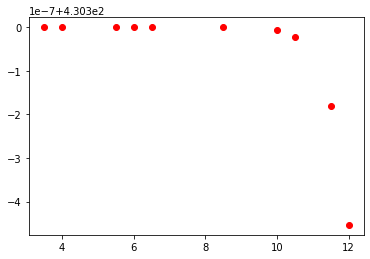

highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  8
ACTION            :  [0.5]
curtemp:  12.5
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12.  12.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955
 430.29999894]


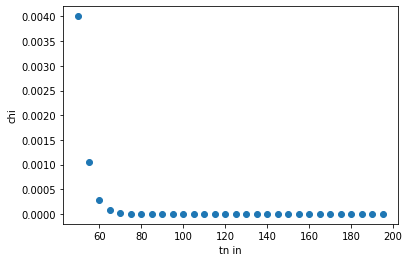

THE RESULT: 159.99999995600214
chisqds:  0.0
BUT ARE WE SURE?: 138489812.60922185


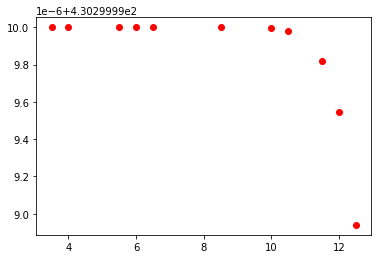

highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  8
ACTION            :  [0.5]
curtemp:  13.0
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12.  12.5 13. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955
 430.29999894 430.29999768]


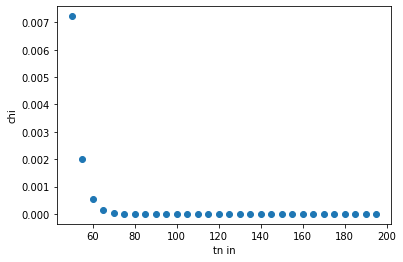

THE RESULT: 159.99999978065932
chisqds:  2.730589047992174e-30
BUT ARE WE SURE?: 64626814.25609439


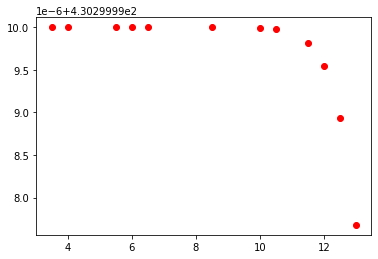

highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  8
ACTION            :  [0.79512376]
curtemp:  14.0
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12.  12.5 13.  14. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955
 430.29999894 430.29999768 430.2999906 ]


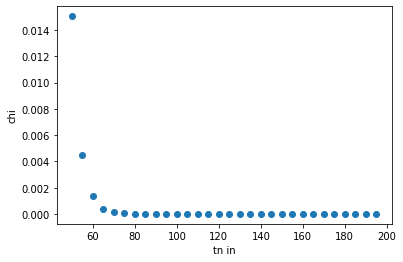

THE RESULT: 160.0000000213203
chisqds:  6.257599874491476e-31
BUT ARE WE SURE?: 18598609.182333704


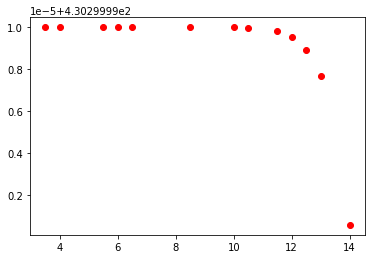

highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  8
ACTION            :  [0.5]
curtemp:  14.5
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12.  12.5 13.  14.  14.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955
 430.29999894 430.29999768 430.2999906  430.29998239]


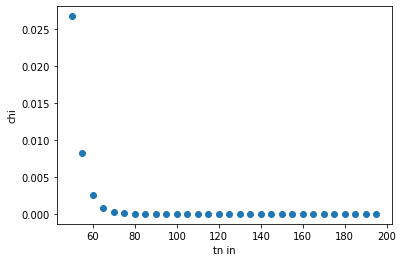

THE RESULT: 160.00000000036127
chisqds:  0.0
BUT ARE WE SURE?: 9302061.838950569


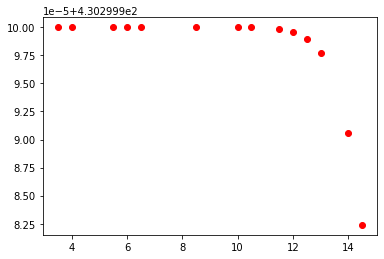

highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  8
ACTION            :  [0.5]
curtemp:  15.0
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12.  12.5 13.  14.  14.5
 15. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955
 430.29999894 430.29999768 430.2999906  430.29998239 430.29996838]


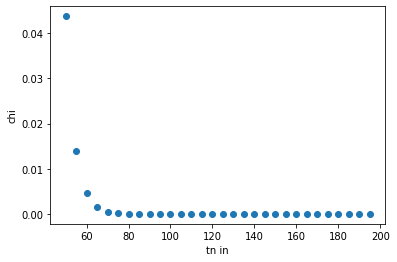

THE RESULT: 159.99999999218485
chisqds:  5.363657249116927e-31
BUT ARE WE SURE?: 5152327.756574559


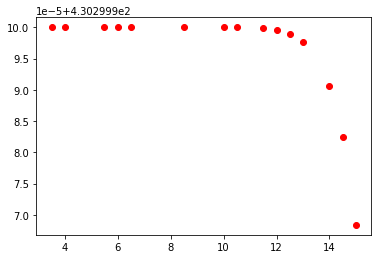

highHIIIIGHHHHHH:  325.0
rewaRD::  -100
stepping:  8
ACTION            :  [0.8899912]
curtemp:  16.0
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12.  12.5 13.  14.  14.5
 15.  16. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955
 430.29999894 430.29999768 430.2999906  430.29998239 430.29996838
 430.29990864]


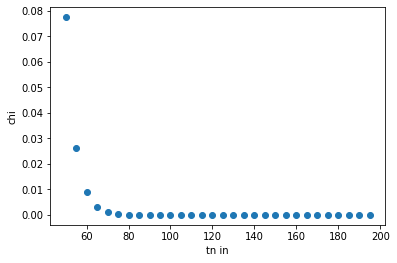

THE RESULT: 159.99999999844815
chisqds:  2.5030403927909826e-30
BUT ARE WE SURE?: 2088401.4462320942


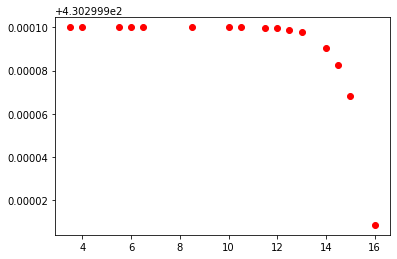

highHIIIIGHHHHHH:  324.0
rewaRD::  -100
stepping:  8
ACTION            :  [0.5]
curtemp:  16.5
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12.  12.5 13.  14.  14.5
 15.  16.  16.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955
 430.29999894 430.29999768 430.2999906  430.29998239 430.29996838
 430.29990864 430.29985202]


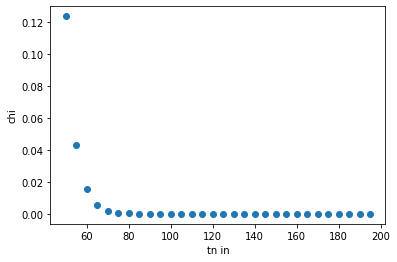

THE RESULT: 160.00000000006696
chisqds:  0.0
BUT ARE WE SURE?: 1193506.5382909367


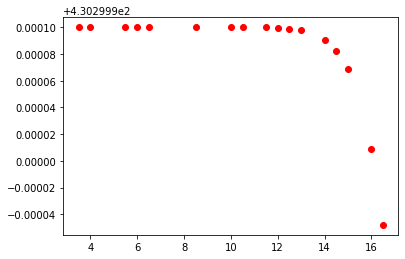

highHIIIIGHHHHHH:  323.5
rewaRD::  -100
stepping:  8
ACTION            :  [0.8954343]
curtemp:  17.5
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12.  12.5 13.  14.  14.5
 15.  16.  16.5 17.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955
 430.29999894 430.29999768 430.2999906  430.29998239 430.29996838
 430.29990864 430.29985202 430.29964256]


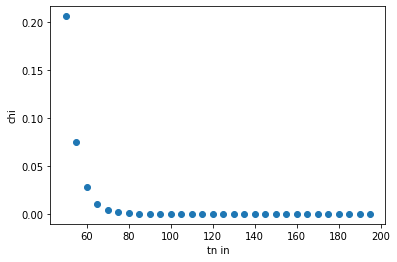

THE RESULT: 159.99999999882783
chisqds:  3.9754182475394945e-30
BUT ARE WE SURE?: 563063.4753400168


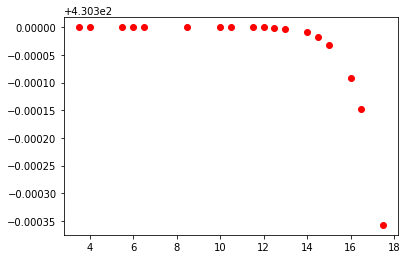

highHIIIIGHHHHHH:  322.5
rewaRD::  -100
stepping:  8
ACTION            :  [0.5]
curtemp:  18.0
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12.  12.5 13.  14.  14.5
 15.  16.  16.5 17.5 18. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955
 430.29999894 430.29999768 430.2999906  430.29998239 430.29996838
 430.29990864 430.29985202 430.29964256 430.29946452]


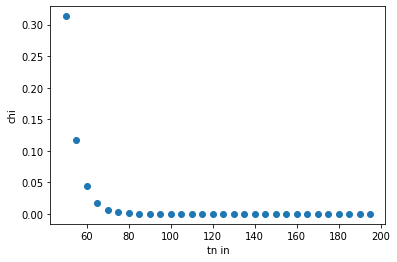

THE RESULT: 160.00000000046282
chisqds:  0.0
BUT ARE WE SURE?: 345934.03607651946


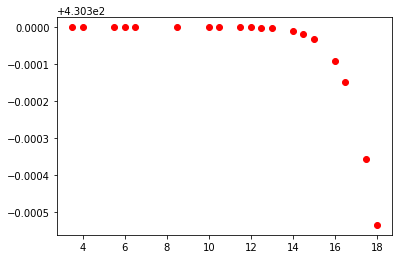

highHIIIIGHHHHHH:  322.0
rewaRD::  -100
stepping:  8
ACTION            :  [0.5]
curtemp:  18.5
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12.  12.5 13.  14.  14.5
 15.  16.  16.5 17.5 18.  18.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955
 430.29999894 430.29999768 430.2999906  430.29998239 430.29996838
 430.29990864 430.29985202 430.29964256 430.29946452 430.29921514]


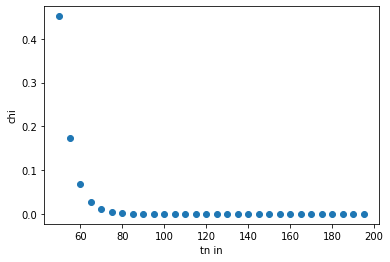

THE RESULT: 159.9999999998172
chisqds:  1.580870218533084e-30
BUT ARE WE SURE?: 229798.10619779731


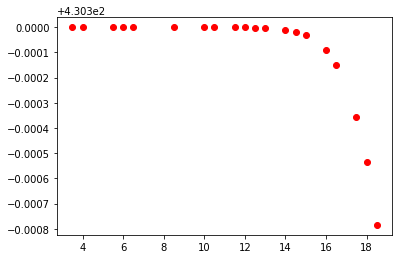

highHIIIIGHHHHHH:  321.5
rewaRD::  -100
stepping:  8
ACTION            :  [1.1166298]
curtemp:  19.5
Temperature:  [ 3.5  4.   5.5  6.   6.5  8.5 10.  10.5 11.5 12.  12.5 13.  14.  14.5
 15.  16.  16.5 17.5 18.  18.5 19.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.29999999 430.29999998 430.29999982 430.29999955
 430.29999894 430.29999768 430.2999906  430.29998239 430.29996838
 430.29990864 430.29985202 430.29964256 430.29946452 430.29921514
 430.29841016]


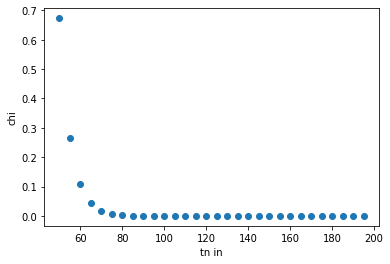

THE RESULT: 160.0000000002045
chisqds:  0.0
BUT ARE WE SURE?: 131287.99840740577


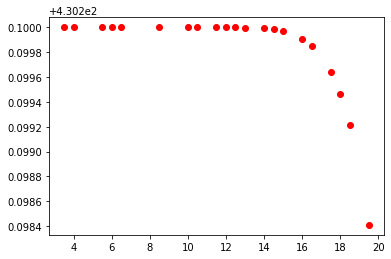

highHIIIIGHHHHHH:  320.5
rewaRD::  -100
terminated: excellent conditions
reset
stepping:  9
ACTION            :  [0.8136609]
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  4.5
Temperature:  [4.  4.5]
Intensity:  [430.3 430.3]


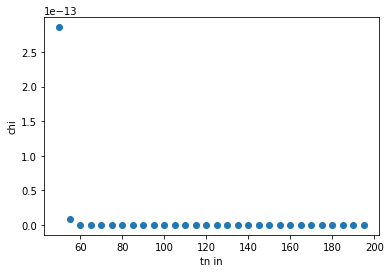

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


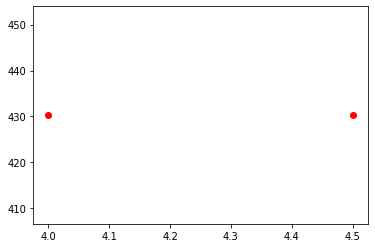

highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  5.0
Temperature:  [4.  4.5 5. ]
Intensity:  [430.3 430.3 430.3]


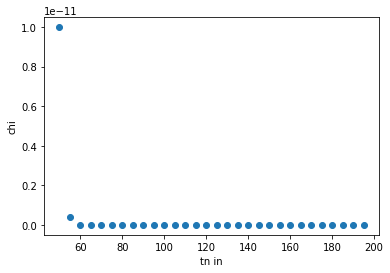

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


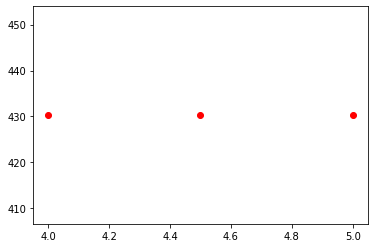

highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  5.5
Temperature:  [4.  4.5 5.  5.5]
Intensity:  [430.3 430.3 430.3 430.3]


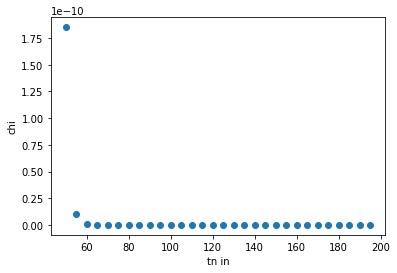

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


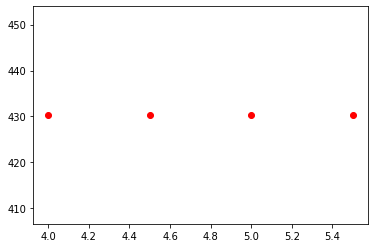

highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  6.0
Temperature:  [4.  4.5 5.  5.5 6. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


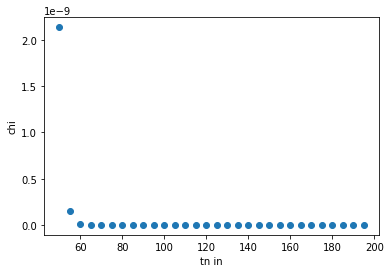

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


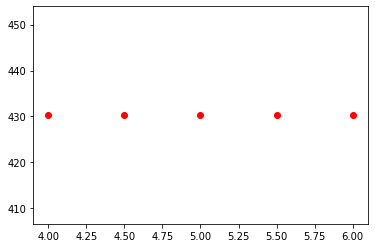

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  9
ACTION            :  [2.0398316]
curtemp:  8.0
Temperature:  [4.  4.5 5.  5.5 6.  8. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


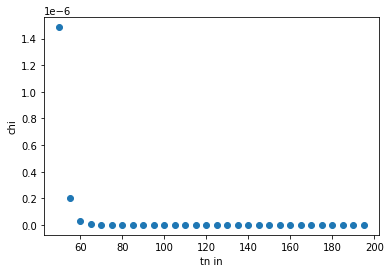

THE RESULT: 195.0
chisqds:  5.769406956599672e-26
BUT ARE WE SURE?: 99999999.99999999


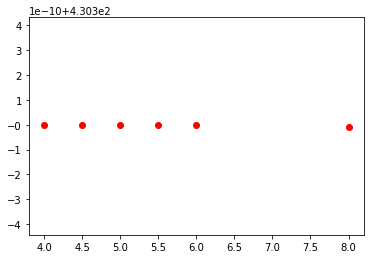

highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  8.5
Temperature:  [4.  4.5 5.  5.5 6.  8.  8.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3]


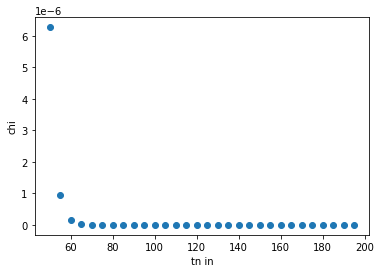

THE RESULT: 170.0984999999971
chisqds:  1.512206577995395e-24
BUT ARE WE SURE?: 99999999.99999999


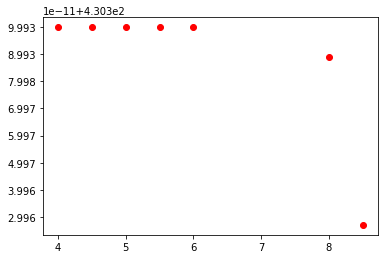

highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  9.0
Temperature:  [4.  4.5 5.  5.5 6.  8.  8.5 9. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


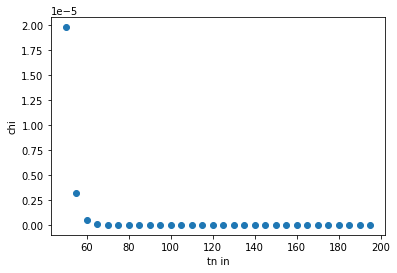

THE RESULT: 160.0000047628957
chisqds:  0.0
BUT ARE WE SURE?: 322395191702.3586


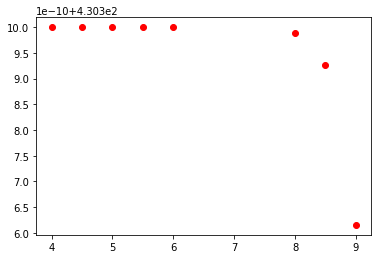

highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  9
ACTION            :  [0.8616127]
curtemp:  10.0
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999]


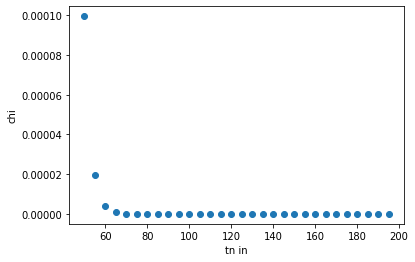

THE RESULT: 160.00003929093862
chisqds:  0.0
BUT ARE WE SURE?: 20025949555.293747


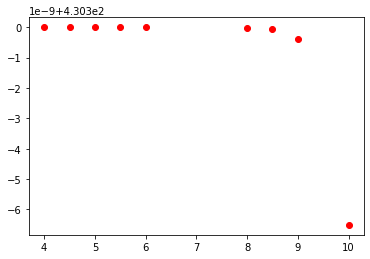

highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  10.5
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998]


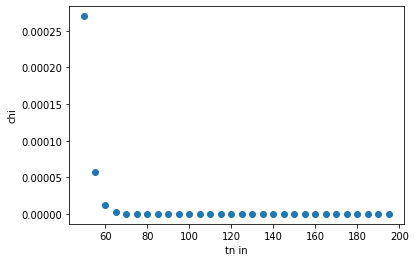

THE RESULT: 160.0000027371531
chisqds:  0.0
BUT ARE WE SURE?: 5973248478.663004


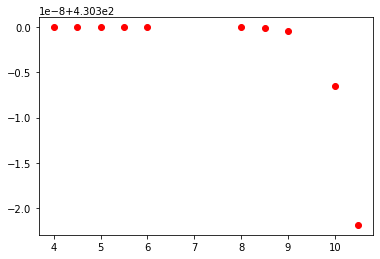

highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  9
ACTION            :  [1.2244705]
curtemp:  11.5
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5 11.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998
 430.29999982]


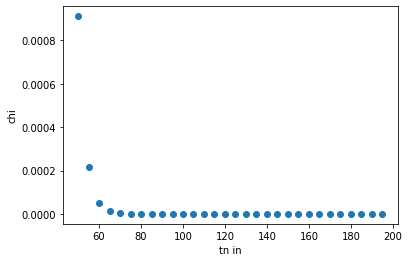

THE RESULT: 159.99999839504034
chisqds:  0.0
BUT ARE WE SURE?: 824369513.6428399


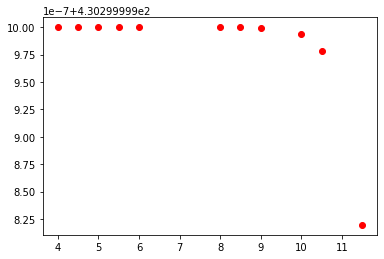

highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  12.0
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5 11.5 12. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998
 430.29999982 430.29999955]


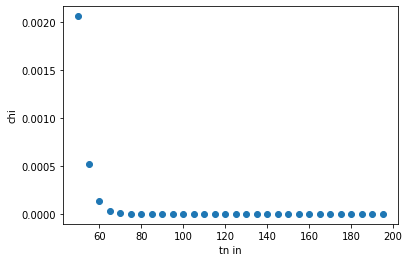

THE RESULT: 160.00000137095597
chisqds:  6.826472590354337e-31
BUT ARE WE SURE?: 318268010.3723937


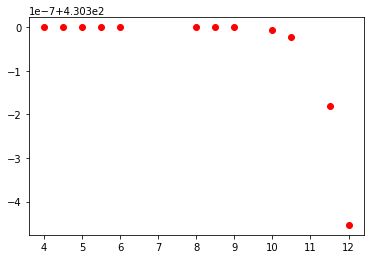

highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  12.5
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5 11.5 12.  12.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998
 430.29999982 430.29999955 430.29999894]


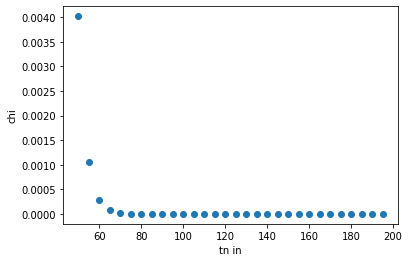

THE RESULT: 159.99999993922762
chisqds:  0.0
BUT ARE WE SURE?: 138489799.9730125


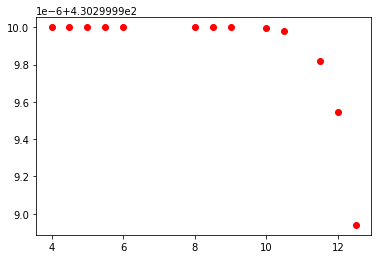

highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  9
ACTION            :  [1.2755902]
curtemp:  14.0
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5 11.5 12.  12.5 14. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906 ]


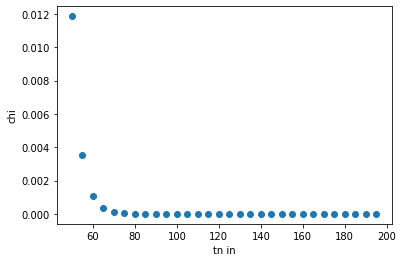

THE RESULT: 159.9999999898672
chisqds:  0.0
BUT ARE WE SURE?: 19232050.429521043


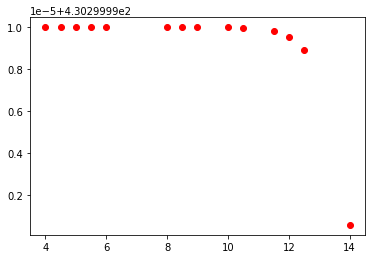

highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  14.5
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5 11.5 12.  12.5 14.
 14.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29998239]


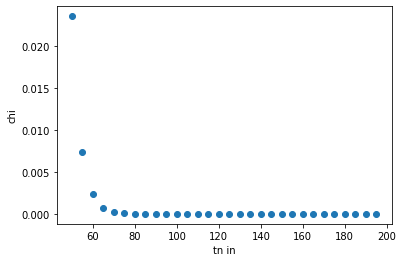

THE RESULT: 160.00000001686982
chisqds:  5.363657035278408e-31
BUT ARE WE SURE?: 9378355.238348423


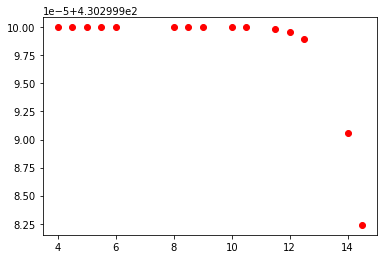

highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  15.0
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5 11.5 12.  12.5 14.
 14.5 15. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29998239
 430.29996838]


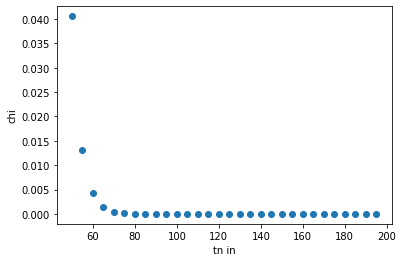

THE RESULT: 159.99999998155874
chisqds:  5.0060800991757985e-31
BUT ARE WE SURE?: 5165189.283458337


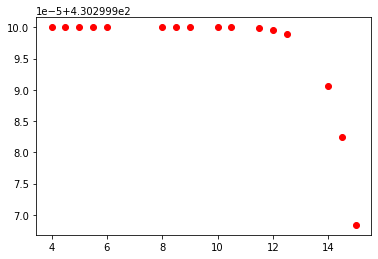

highHIIIIGHHHHHH:  325.0
rewaRD::  -100
stepping:  9
ACTION            :  [1.7881209]
curtemp:  17.0
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5 11.5 12.  12.5 14.
 14.5 15.  17. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29998239
 430.29996838 430.29976701]


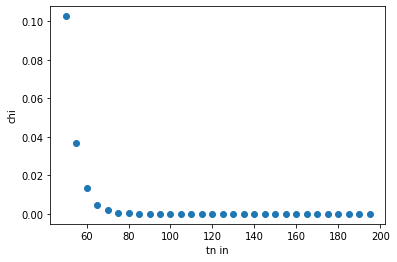

THE RESULT: 159.99999999626817
chisqds:  9.386402535055698e-31
BUT ARE WE SURE?: 935973.8363700163


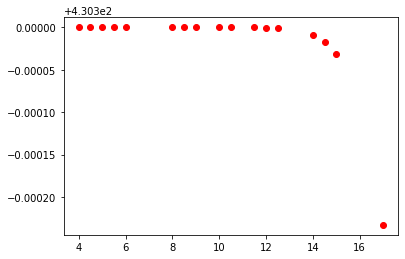

highHIIIIGHHHHHH:  323.0
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  17.5
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5 11.5 12.  12.5 14.
 14.5 15.  17.  17.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29998239
 430.29996838 430.29976701 430.29964256]


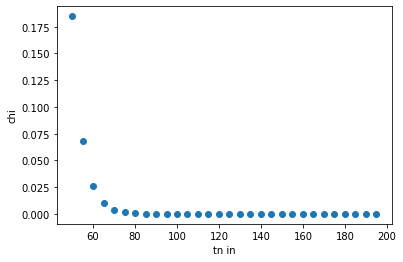

THE RESULT: 159.99999999988668
chisqds:  0.0
BUT ARE WE SURE?: 527512.372777048


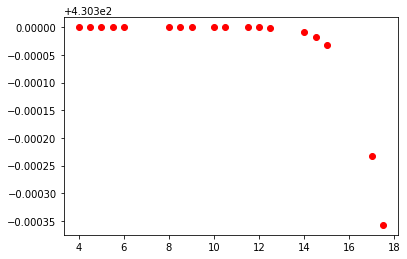

highHIIIIGHHHHHH:  322.5
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  18.0
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5 11.5 12.  12.5 14.
 14.5 15.  17.  17.5 18. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29998239
 430.29996838 430.29976701 430.29964256 430.29946452]


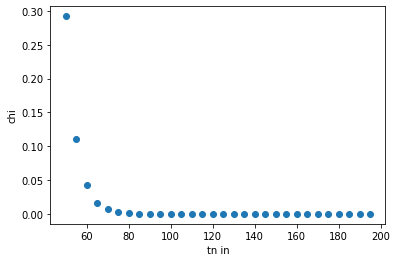

THE RESULT: 159.9999999995984
chisqds:  1.6686946842392596e-30
BUT ARE WE SURE?: 337181.214731231


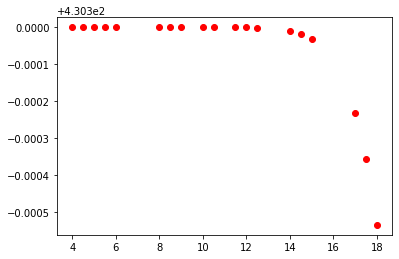

highHIIIIGHHHHHH:  322.0
rewaRD::  -100
stepping:  9
ACTION            :  [0.5]
curtemp:  18.5
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5 11.5 12.  12.5 14.
 14.5 15.  17.  17.5 18.  18.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29998239
 430.29996838 430.29976701 430.29964256 430.29946452 430.29921514]


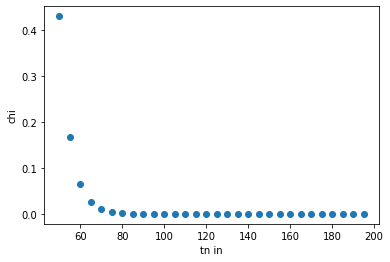

THE RESULT: 160.00000000048732
chisqds:  0.0
BUT ARE WE SURE?: 227177.14553345545


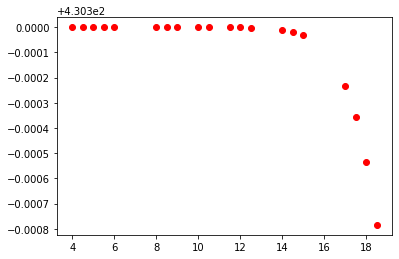

highHIIIIGHHHHHH:  321.5
rewaRD::  -100
stepping:  9
ACTION            :  [0.99893403]
curtemp:  19.5
Temperature:  [ 4.   4.5  5.   5.5  6.   8.   8.5  9.  10.  10.5 11.5 12.  12.5 14.
 14.5 15.  17.  17.5 18.  18.5 19.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999999 430.29999998
 430.29999982 430.29999955 430.29999894 430.2999906  430.29998239
 430.29996838 430.29976701 430.29964256 430.29946452 430.29921514
 430.29841016]


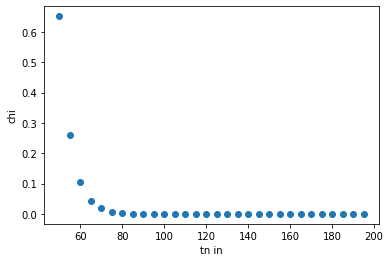

THE RESULT: 160.0000000002549
chisqds:  0.0
BUT ARE WE SURE?: 130793.55792676241


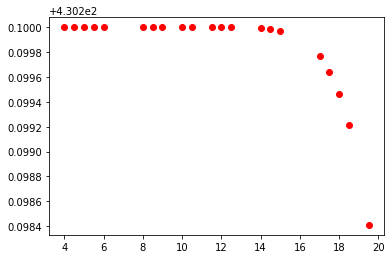

highHIIIIGHHHHHH:  320.5
rewaRD::  -100
terminated: excellent conditions
reset
stepping:  10
ACTION            :  [1.4891661]
curtemp:  4.5
Temperature:  [4.5]
highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  10
ACTION            :  [0.5]
curtemp:  5.0
Temperature:  [4.5 5. ]
Intensity:  [430.3 430.3]


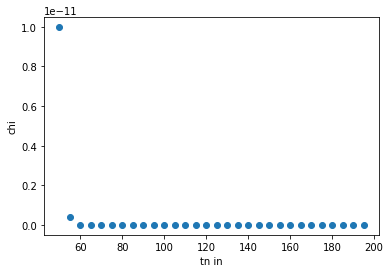

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


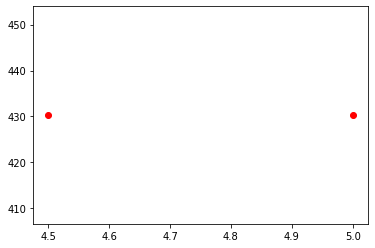

highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  10
ACTION            :  [0.5]
curtemp:  5.5
Temperature:  [4.5 5.  5.5]
Intensity:  [430.3 430.3 430.3]


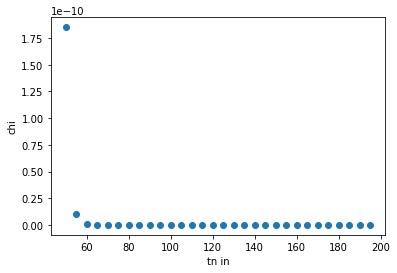

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


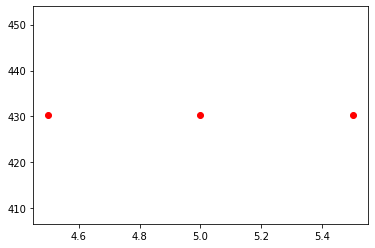

highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  10
ACTION            :  [0.5]
curtemp:  6.0
Temperature:  [4.5 5.  5.5 6. ]
Intensity:  [430.3 430.3 430.3 430.3]


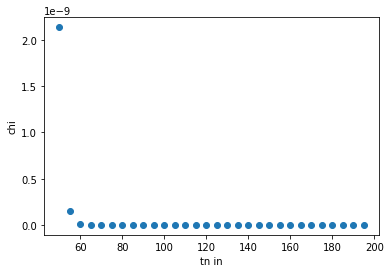

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


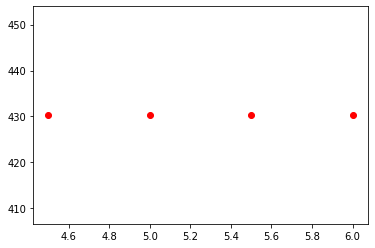

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  10
ACTION            :  [1.7530091]
curtemp:  8.0
Temperature:  [4.5 5.  5.5 6.  8. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


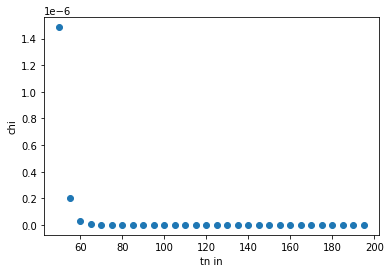

THE RESULT: 195.0
chisqds:  7.21175869574959e-26
BUT ARE WE SURE?: 99999999.99999999


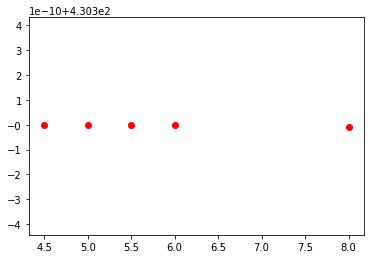

highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  10
ACTION            :  [1.0658181]
curtemp:  9.0
Temperature:  [4.5 5.  5.5 6.  8.  9. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


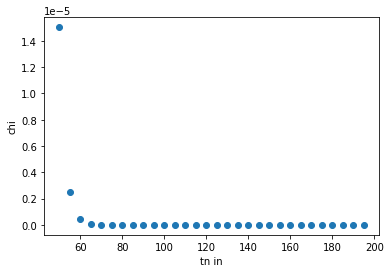

THE RESULT: 195.0
chisqds:  6.848454862503785e-23
BUT ARE WE SURE?: 99999999.99999999


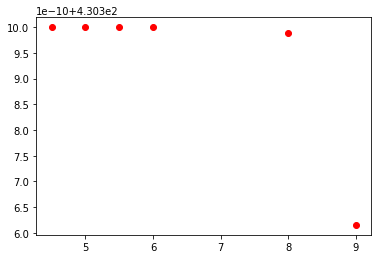

highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  10
ACTION            :  [0.60609376]
curtemp:  9.5
Temperature:  [4.5 5.  5.5 6.  8.  9.  9.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3]


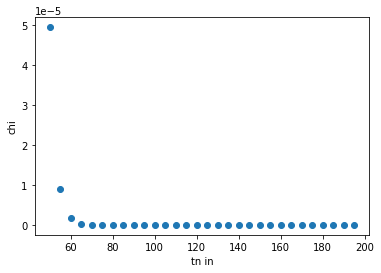

THE RESULT: 195.0
chisqds:  1.1758669891280796e-21
BUT ARE WE SURE?: 99999999.99999999


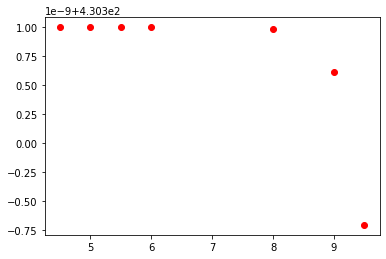

highHIIIIGHHHHHH:  330.5
rewaRD::  -100
stepping:  10
ACTION            :  [0.74484944]
curtemp:  10.0
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999]


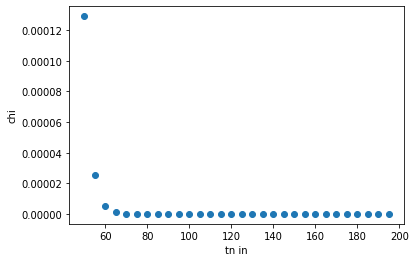

THE RESULT: 159.99998105703685
chisqds:  0.0
BUT ARE WE SURE?: 19329405453.4553


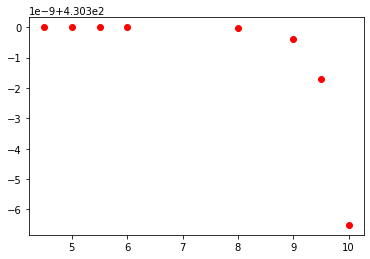

highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  10
ACTION            :  [0.5]
curtemp:  10.5
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998]


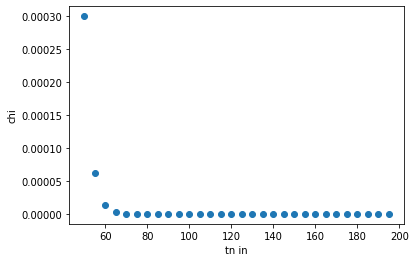

THE RESULT: 160.0000005320969
chisqds:  0.0
BUT ARE WE SURE?: 5953848172.657495


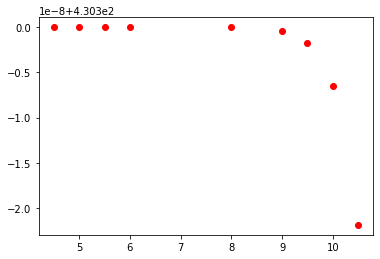

highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  10
ACTION            :  [0.9698793]
curtemp:  11.5
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982]


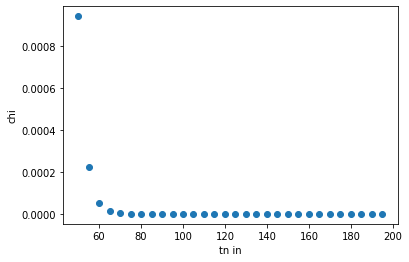

THE RESULT: 159.9999999609973
chisqds:  0.0
BUT ARE WE SURE?: 823972657.5687492


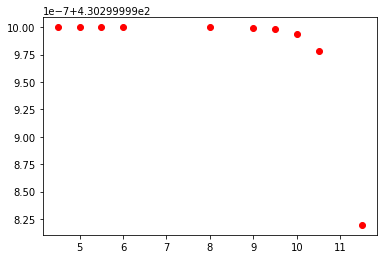

highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  10
ACTION            :  [0.7979262]
curtemp:  12.5
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5 12.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982
 430.29999894]


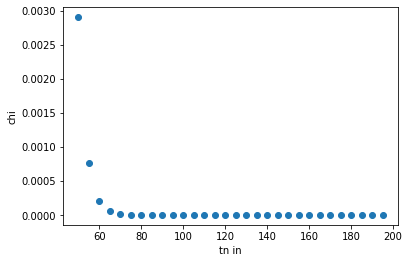

THE RESULT: 159.99999982735915
chisqds:  0.0
BUT ARE WE SURE?: 151207076.8972072


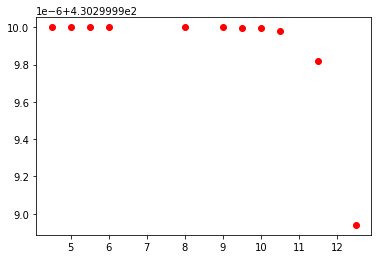

highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  10
ACTION            :  [0.5]
curtemp:  13.0
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5 12.5 13. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982
 430.29999894 430.29999768]


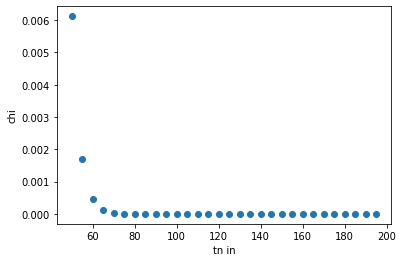

THE RESULT: 160.00000013083263
chisqds:  6.826472599977376e-31
BUT ARE WE SURE?: 65789321.55266091


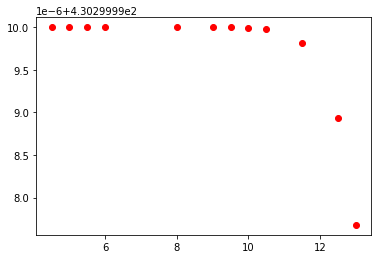

highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  10
ACTION            :  [0.6817818]
curtemp:  13.5
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5 12.5 13.  13.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982
 430.29999894 430.29999768 430.29999521]


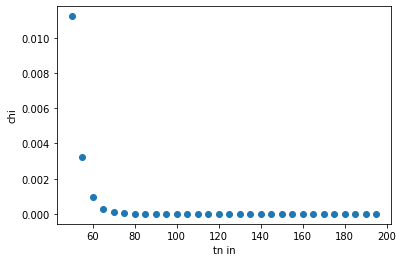

THE RESULT: 159.99999995541023
chisqds:  0.0
BUT ARE WE SURE?: 32071491.977326017


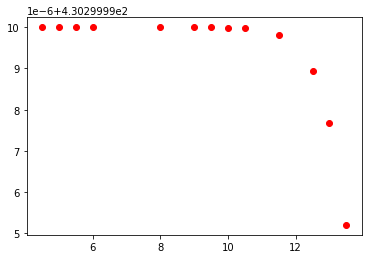

highHIIIIGHHHHHH:  326.5
rewaRD::  -100
stepping:  10
ACTION            :  [0.5]
curtemp:  14.0
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5 12.5 13.  13.5 14. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982
 430.29999894 430.29999768 430.29999521 430.2999906 ]


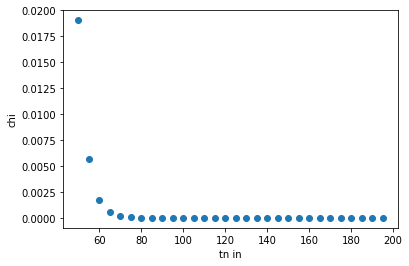

THE RESULT: 160.00000001453768
chisqds:  0.0
BUT ARE WE SURE?: 16612021.170420814


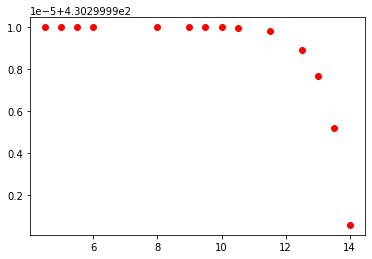

highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  10
ACTION            :  [0.5]
curtemp:  14.5
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5 12.5 13.  13.5 14.
 14.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982
 430.29999894 430.29999768 430.29999521 430.2999906  430.29998239]


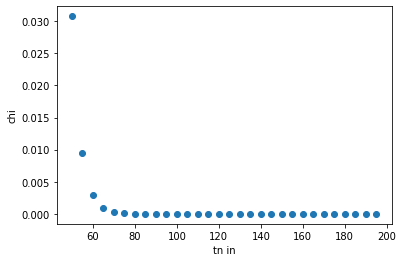

THE RESULT: 160.0000000185329
chisqds:  0.0
BUT ARE WE SURE?: 9020466.742908828


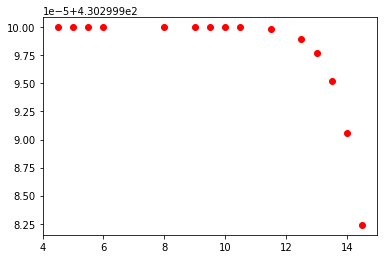

highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  10
ACTION            :  [0.5110997]
curtemp:  15.0
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5 12.5 13.  13.5 14.
 14.5 15. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982
 430.29999894 430.29999768 430.29999521 430.2999906  430.29998239
 430.29996838]


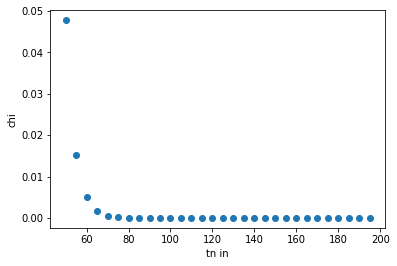

THE RESULT: 159.9999999780987
chisqds:  5.0060800991757985e-31
BUT ARE WE SURE?: 5102943.11606703


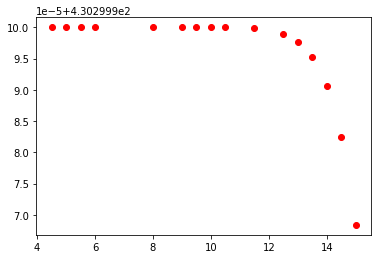

highHIIIIGHHHHHH:  325.0
rewaRD::  -100
stepping:  10
ACTION            :  [0.5]
curtemp:  15.5
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5 12.5 13.  13.5 14.
 14.5 15.  15.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982
 430.29999894 430.29999768 430.29999521 430.2999906  430.29998239
 430.29996838 430.29994532]


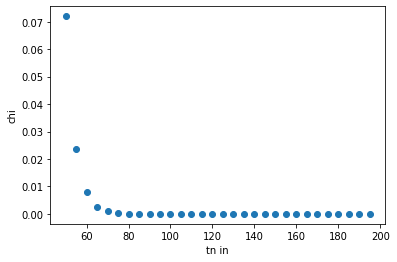

THE RESULT: 159.99999999847583
chisqds:  4.693200092977311e-31
BUT ARE WE SURE?: 2994421.5549952667


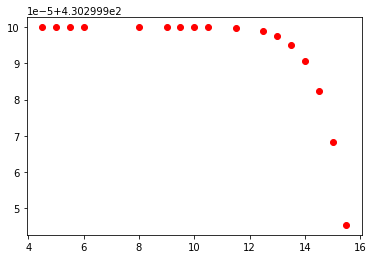

highHIIIIGHHHHHH:  324.5
rewaRD::  -100
stepping:  10
ACTION            :  [0.5]
curtemp:  16.0
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5 12.5 13.  13.5 14.
 14.5 15.  15.5 16. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982
 430.29999894 430.29999768 430.29999521 430.2999906  430.29998239
 430.29996838 430.29994532 430.29990864]


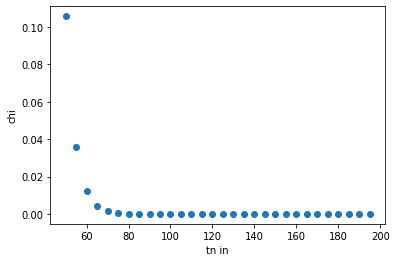

THE RESULT: 159.999999995175
chisqds:  2.2085650524626315e-30
BUT ARE WE SURE?: 1816264.5715168433


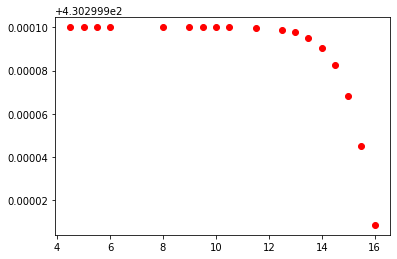

highHIIIIGHHHHHH:  324.0
rewaRD::  -100
stepping:  10
ACTION            :  [0.5]
curtemp:  16.5
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5 12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982
 430.29999894 430.29999768 430.29999521 430.2999906  430.29998239
 430.29996838 430.29994532 430.29990864 430.29985202]


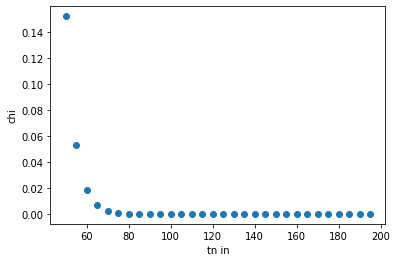

THE RESULT: 160.00000000076466
chisqds:  1.6686934207266663e-30
BUT ARE WE SURE?: 1135281.340389132


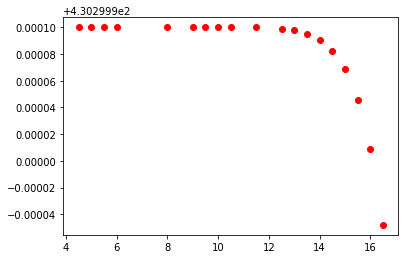

highHIIIIGHHHHHH:  323.5
rewaRD::  -100
stepping:  10
ACTION            :  [0.76180565]
curtemp:  17.5
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5 12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982
 430.29999894 430.29999768 430.29999521 430.2999906  430.29998239
 430.29996838 430.29994532 430.29990864 430.29985202 430.29964256]


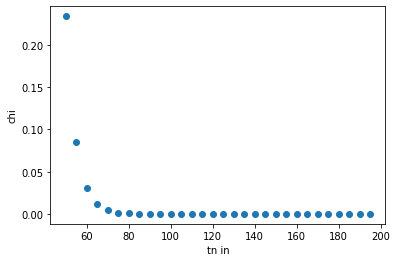

THE RESULT: 159.999999999995
chisqds:  0.0
BUT ARE WE SURE?: 556584.9144284683


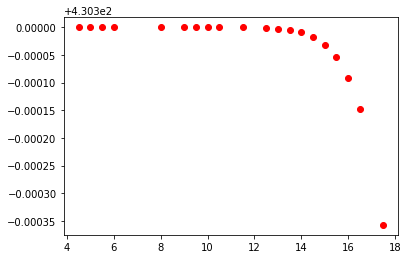

highHIIIIGHHHHHH:  322.5
rewaRD::  -100
stepping:  10
ACTION            :  [0.5]
curtemp:  18.0
Temperature:  [ 4.5  5.   5.5  6.   8.   9.   9.5 10.  10.5 11.5 12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.5 18. ]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.29999999 430.29999998 430.29999982
 430.29999894 430.29999768 430.29999521 430.2999906  430.29998239
 430.29996838 430.29994532 430.29990864 430.29985202 430.29964256
 430.29946452]


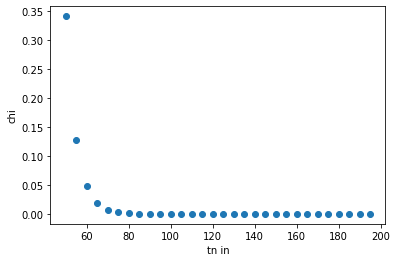

THE RESULT: 160.00000000053123
chisqds:  0.0
BUT ARE WE SURE?: 344415.3491998169


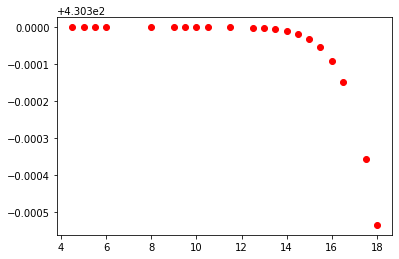

highHIIIIGHHHHHH:  322.0
rewaRD::  -100
terminated: excellent conditions
reset
stepping:  11
ACTION            :  [0.5]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  11
ACTION            :  [2.2816641]
curtemp:  6.0
Temperature:  [3.5 6. ]
Intensity:  [430.3 430.3]


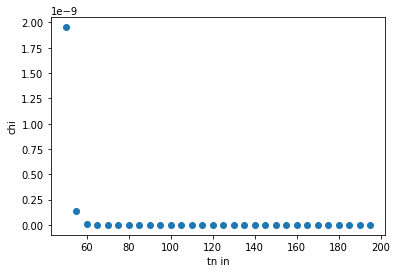

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999


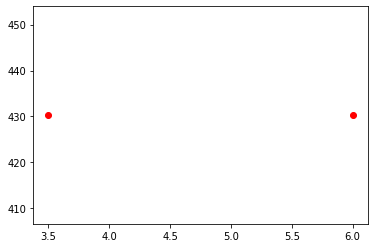

highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  11
ACTION            :  [1.0058843]
curtemp:  7.0
Temperature:  [3.5 6.  7. ]
Intensity:  [430.3 430.3 430.3]


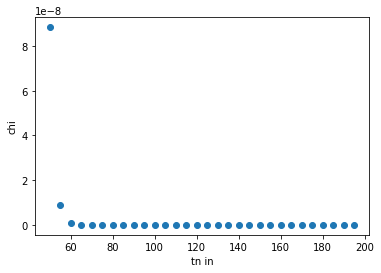

THE RESULT: 195.0
chisqds:  3.3791039286622573e-29
BUT ARE WE SURE?: 99999999.99999999


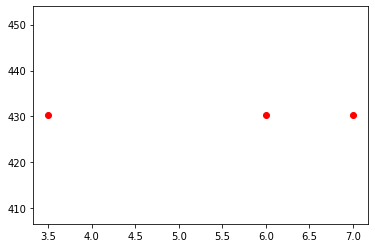

highHIIIIGHHHHHH:  333.0
rewaRD::  -100
stepping:  11
ACTION            :  [0.5]
curtemp:  7.5
Temperature:  [3.5 6.  7.  7.5]
Intensity:  [430.3 430.3 430.3 430.3]


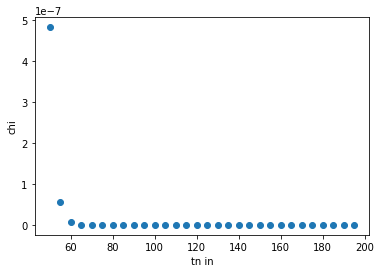

THE RESULT: 195.0
chisqds:  1.346635491570592e-27
BUT ARE WE SURE?: 99999999.99999999


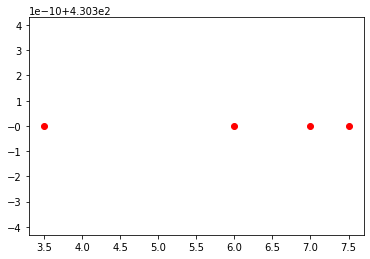

highHIIIIGHHHHHH:  332.5
rewaRD::  -100
stepping:  11
ACTION            :  [0.5]
curtemp:  8.0
Temperature:  [3.5 6.  7.  7.5 8. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3]


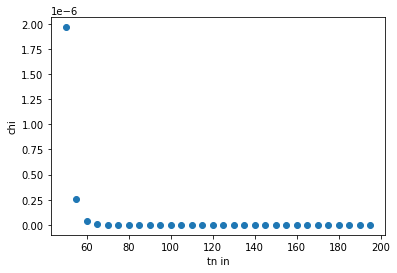

THE RESULT: 195.0
chisqds:  7.312756357617384e-26
BUT ARE WE SURE?: 99999999.99999999


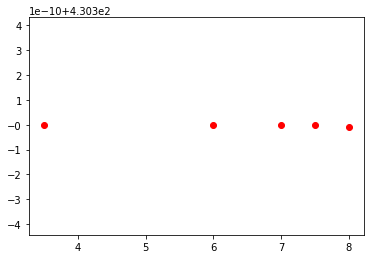

highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  11
ACTION            :  [0.5]
curtemp:  8.5
Temperature:  [3.5 6.  7.  7.5 8.  8.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3]


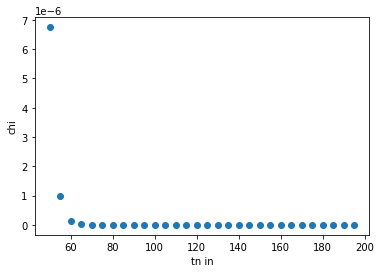

THE RESULT: 170.0984999999971
chisqds:  1.8152621395975064e-24
BUT ARE WE SURE?: 99999999.99999999


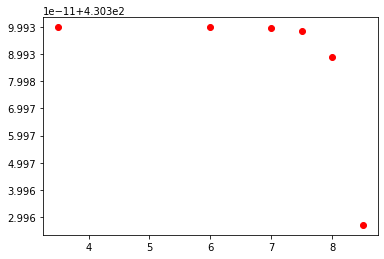

highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  11
ACTION            :  [0.5]
curtemp:  9.0
Temperature:  [3.5 6.  7.  7.5 8.  8.5 9. ]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3]


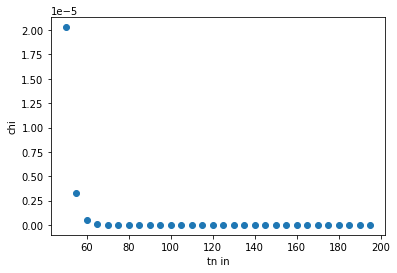

THE RESULT: 160.00017237194893
chisqds:  0.0
BUT ARE WE SURE?: 322395529429.55383


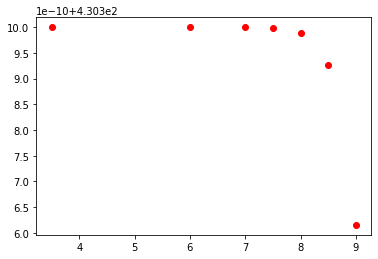

highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  11
ACTION            :  [0.5]
curtemp:  9.5
Temperature:  [3.5 6.  7.  7.5 8.  8.5 9.  9.5]
Intensity:  [430.3 430.3 430.3 430.3 430.3 430.3 430.3 430.3]


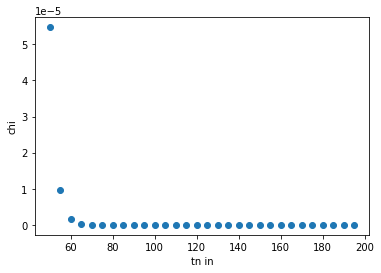

THE RESULT: 159.99995406482773
chisqds:  0.0
BUT ARE WE SURE?: 72040332610.91313


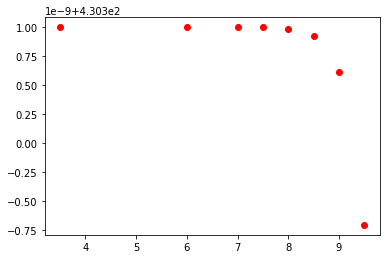

highHIIIIGHHHHHH:  330.5
rewaRD::  -100
stepping:  11
ACTION            :  [0.9210423]
curtemp:  10.5
Temperature:  [ 3.5  6.   7.   7.5  8.   8.5  9.   9.5 10.5]
Intensity:  [430.3        430.3        430.3        430.3        430.3
 430.3        430.3        430.3        430.29999998]


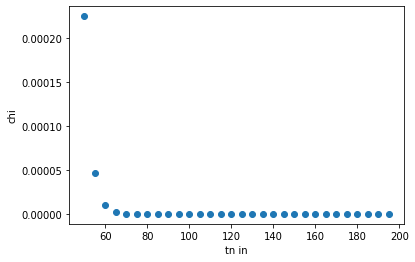

THE RESULT: 159.99999695180537
chisqds:  0.0
BUT ARE WE SURE?: 6234638821.92481


KeyboardInterrupt: ignored

In [ ]:
# Train the agent
model = PPO2('MlpPolicy', env, verbose=1).learn(5000)

In [ ]:
# Test the trained agent
obs = env.reset()
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render(mode='console')
  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("Goal reached!", "reward=", reward)
    break

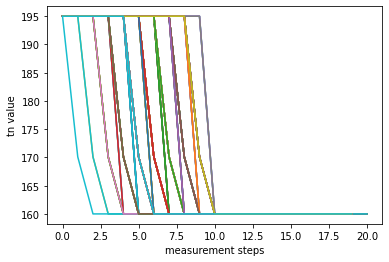

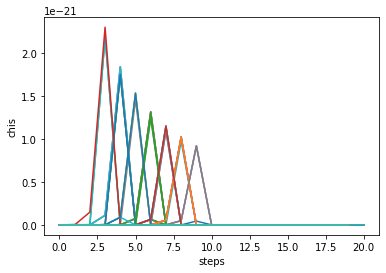

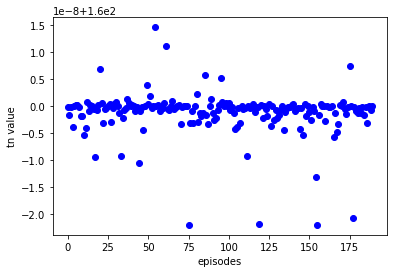

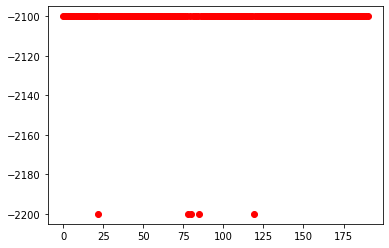

In [ ]:
numTrials = 190

endParams = [[] for i in range(numTrials)]
data = [[] for i in range(numTrials)]
chis = [[] for i in range(numTrials)]
endtns = []
imagestore = "logs/"
logstore = "logs/"

for i in range(1,numTrials+1):
    data[i-1] = np.loadtxt(logstore +  "temps/tnLog-" + str(i) + ".txt")
    #print(data[i-1])
    chis[i-1] = np.loadtxt(logstore + "chis/chiLog-" + str(i) + ".txt")

for i in range (0, len(data)): 
    plt.plot(data[i], label = str(i))
    endtns.append(data[i][-1])

plt.xlabel("measurement steps")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "tns.png")
plt.close()

for i in range (0, len(chis)):
  plt.plot(chis[i], label = str(i))

plt.xlabel("steps")
plt.ylabel("chis")
plt.show()
plt.close()

plt.plot(endtns, 'bo')
plt.xlabel("episodes")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "endtns.png")
plt.close()

rewards = np.loadtxt('logs/runrewards.txt')
plt.plot(rewards, 'ro')
plt.show()
plt.close()


temperature:  [14.5 15. ]
Intensity:  [330.29998239 330.29996838]


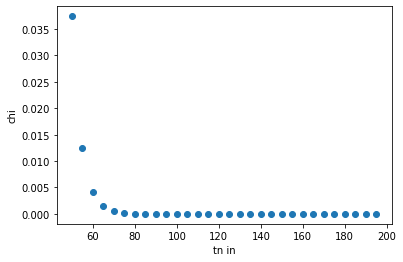

[160.]


In [ ]:
p=[.885,330,.3]
#T=np.arange(3, 300, 4)
T = np.array([14.5, 15])
print("temperature: ", T)
#T=N.arange(10,300,2)
I=[]
error = []

I=OrderMethods.orderparameter(T, 160,p[0],p[1],p[2])
print("Intensity: ", I)
error= np.sqrt(I)
#print(error)

M = Curve(OrderMethods.orderparameter, T, I, error, Jt = p[0], Nf = p[1], Bk = p[2])
M.Tn.range(10,400)

x, dx, chisq, params = OrderMethods.fit(M)
print(x)

fitI = OrderMethods.orderparameter(T, x, p[0],p[1],p[2])

plt.errorbar(T, I, error)
plt.plot(T, fitI,'ro', markersize = 2)
plt.xlabel("Temperature")
plt.ylabel("Intensity") 
plt.savefig("test")
plt.close()